In [ ]:
path = F"D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data/" #This is where you load the data from
path_save_model = 'D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/'#This is where you save the models

# Do not Modify

## Imports

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from sklearn.model_selection import train_test_split
import time

from plotly.subplots import make_subplots
import numpy as np
from plotly import graph_objs as go
from tqdm.notebook import trange
import pandas as pd
from scipy.interpolate import interp1d
from IPython.display import clear_output
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

np.random.seed(42)

In [2]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    # 'opacity': 0.2,
    'xaxis': {
        'title': 'Time (\u03BCs)',
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        },
    'yaxis': {
        'title': 'Coherence',
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        },
    'font':{'family':'mathjax',
            'size': 22,
            },
    'colorway': ["#d9ed92","#b5e48c","#99d98c","#76c893","#52b69a","#34a0a4","#168aad","#1a759f","#1e6091","#184e77"]
}

## Data loading and preprocessing 

In [4]:
def training(model, input, output, batch=64, epochs=20,lr=False):
  ec = EarlyStopping(monitor='val_loss', patience=30),
  mc = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True),
  if type(lr) != bool:
    K.set_value(model.optimizer.learning_rate, lr)
  history = model.fit(input,output,batch,epochs,validation_split=0.1,verbose=1,
                  callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7), mc, ec])
  return model, history

def percent_error(data_test,data_predict):
  return 100*np.mean(np.abs(data_test-data_predict)/(data_test + 1e-6),axis=(1,2))

In [5]:
# Prepare data for training
data_1 = np.load(path+"Data2D.npz")

print('-- data loaded')
print(data_1.files)

#== format the data for the training stage

# x_train, x_test, y_train, y_test = train_test_split(data_1['network_in'], data_1['network_out'], test_size=0.15)
x_train, x_test, y_train, y_test = train_test_split(data_1["vImages"], data_1["fImages"], test_size=0.15)

print('-- data split for training:')
print("  x_train = ",np.shape(x_train))
print("  y_train = ",np.shape(y_train))
print("  x_test = ",np.shape(x_test))
print("  y_test = ",np.shape(y_test))

-- data loaded
['vImages', 'fImages', 'vFlat', 'fFlat']
-- data split for training:
  x_train =  (17000, 32, 32)
  y_train =  (17000, 32, 32)
  x_test =  (3000, 32, 32)
  y_test =  (3000, 32, 32)


## Useful Functions

In [6]:
def modelBuilder(k_size, filter_num, dropout_rate = 0):
    model2d = Sequential()
    model2d.add(layers.Input(shape=(32,32,1)))
    model2d.add(layers.Conv2D(filters=filter_num[0],kernel_size=k_size[0], strides=1, activation="relu",padding='same'))
    model2d.add(layers.Conv2D(filters=filter_num[1],kernel_size=k_size[1], strides=2, activation="relu",padding='same'))
    model2d.add(layers.Conv2DTranspose(filter_num[1], kernel_size=k_size[1], strides=2, activation="relu", padding="same"))
    model2d.add(layers.Conv2DTranspose(filter_num[0], kernel_size=k_size[0], strides=1, activation="relu", padding="same"))
    model2d.add(layers.Conv2DTranspose(filters=1,kernel_size=k_size[0],activation="relu",padding='same'))
    model2d.add(layers.Dropout(dropout_rate))
    model2d.compile(loss='MAPE',optimizer='adam')
    return model2d

def train_model(model2d, n_epochs = 1000):
    start = time.time()
    dnn, history_dnn = training(model2d,x_train,y_train,batch=64,epochs=n_epochs,
                                lr=1e-4#0.001,#Experiment w lower LR
                                )
    end = time.time()
    time_dnn = end - start
    path = 'D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp'

    dnn.save(path+'/dnn', overwrite=True)
    pd.DataFrame(history_dnn.history).to_csv(path+'/dnn_history'+'.csv')

    final_accuracy = np.round(history_dnn.history['val_loss'][-1],2)
    print('-- time taken=', time_dnn)
    print('-- final accuracy=', final_accuracy)
    return dnn, history_dnn

def model_plots(dnn, dnn_history, n_plot = 150):
    
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Velocity-Amplitude', 'Force-Amplitude-Calculated', 'Force-Amplitude-Predicted'))


    fig.add_heatmap(x=np.arange(0,32),y=np.arange(0,32),z=np.squeeze(x_test[n_plot,:,:]), row=1, col=1,
                    # zmin=0, zmax=1.1,
                    showscale=False,
                    # zsmooth='best',
                    colorscale='Viridis', 
                    )

    fig.add_heatmap(x=np.arange(0,32),y=np.arange(0,32),z=np.squeeze(y_test[n_plot,:,:]), row=1, col=2,
                    # zmin=0, zmax=1e-3,
                    showscale=False,
                    # zsmooth='best',
                    colorscale='Viridis',
                    )
    fig.add_heatmap(x=np.arange(0,32),y=np.arange(0,32),z=np.squeeze(y_predict[n_plot,:,:]), row=1, col=3,
                    # zmin=0, zmax=1e-3,
                    showscale=True,
                    # zsmooth='best',
                    colorscale='Viridis',
                    )

    fig.layout.xaxis1.title = 'X'
    fig.layout.yaxis1.title = 'Y'
    fig.layout.xaxis2.title = 'X'
    fig.layout.yaxis2.title = 'Y'
    fig.layout.xaxis3.title = 'X'
    fig.layout.yaxis3.title = 'Y'

    fig.update_layout(height=525,width=1000)
    fig.show()
    return fig

def model_error_plots(history_dnn, n_epochs = 1000):
    fig = go.Figure()
    fig.add_scatter(x=np.arange( 1, n_epochs+1 ),y=history_dnn.history['val_loss'] ,line=dict(width=2,color='royalblue'),opacity=1,name=f'Validation loss')
    fig.update_layout(template=fig_template,
                    xaxis = dict(title='Epochs'),
                    yaxis = dict(title='Mean absolute error on validation set',type="log",),
                    )

    fig.show()
    return fig

def model_error_hist_plots(y_predict):
    err_perc = percent_error(np.squeeze(y_test),np.squeeze(y_predict))
    print(f'The error percent is {np.mean(err_perc)}')
    plt.hist(err_perc, bins="auto")
    plt.title("Error Percentages")
    mean = np.mean(err_perc)
    median = np.median(err_perc)
    plt.axvline(mean, color='r', linestyle='--')
    plt.axvline(median, color='g', linestyle='-')
    print(f'The mean error is {mean} and the median error is {median}')

def predictions(dnn):
    y_predict = np.squeeze(dnn.predict(x_test))
    err_perc = percent_error(np.squeeze(y_test),np.squeeze(y_predict))
    return y_predict, err_perc

def save_model(model2d, history_dnn, filter_num, k_size, path, dropout_rate = 0, n_epochs = 1000):
    filename=str( np.round(history_dnn.history['val_loss'][-1],2) )\
			+"_fil="+str(filter_num)+"_ker="+str(k_size)+"_dr"+str(dropout_rate)\
            +'_LRini='+str("1e-4")+'_LRmin='+str(1e-7)\
            +'_bs='+str(64)+"_ep="+str(n_epochs)+"_NOISE_TYPES=lor"
    
    model2d.save(path+'/MODEL2d_CNN'+filename, overwrite=True)
    pd.DataFrame(history_dnn.history).to_csv(path+'/History_'+ filename +'.csv')
    return None

## Main Loop

In [7]:
K_MainList =[[4,6], [6,4], [4,4], [6,6], [8,8], [6,8], [8,6]]#[[i,j] for i in [4,6,8,12] for j in [4,6,8,12]]
Filter_MainList =[[64, 256], [128, 128], [32, 256], [128, 256], [256, 256]]#[[i,j] for i in [16, 32, 64, 128] for j in [16, 32, 64, 128]]
dnn_list = []
dnn_history_list = []
for k_size in K_MainList:
    for filter_num in Filter_MainList:
        model2d = modelBuilder(k_size=k_size,filter_num = filter_num)
        dnn, history_dnn = train_model(model2d=model2d)
        dnn_list.append(dnn)
        dnn_history_list.append(history_dnn)
        y_predict, err_perc = predictions(dnn)
        save_model(model2d,history_dnn,filter_num,k_size, path = path_save_model)
        print(f'For the model with kernel = {str(k_size)} and filters = {str(filter_num)} the error is {str(err_perc)}')
        model_plots(dnn, history_dnn)
        model_error_plots(history_dnn)
        model_error_hist_plots(y_predict)





Epoch 1/1000

236/240 [============================>.] - ETA: 0s - loss: 99.7841INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 16ms/step - loss: 99.7416 - val_loss: 97.3937 - lr: 1.0000e-04
Epoch 2/1000
240/240 [==============================] - ETA: 0s - loss: 93.4711INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 93.4711 - val_loss: 94.0158 - lr: 1.0000e-04
Epoch 3/1000
235/240 [============================>.] - ETA: 0s - loss: 91.5844INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 91.5852 - val_loss: 91.5577 - lr: 1.0000e-04
Epoch 4/1000
237/240 [============================>.] - ETA: 0s - loss: 91.0014INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 90.9971 - val_loss: 91.0225 - lr: 1.0000e-04
Epoch 5/1000
240/240 [==============================] - 3s 13ms/step - loss: 90.7648 - val_loss: 92.1616 - lr: 1.0000e-04
Epoch 6/1000
237/240 [============================>.] - ETA: 0s - loss: 89.4420INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 89.4215 - val_loss: 89.4140 - lr: 1.0000e-04
Epoch 7/1000
240/240 [==============================] - 3s 13ms/step - loss: 88.7115 - val_loss: 90.8618 - lr: 1.0000e-04
Epoch 8/1000
239/240 [============================>.] - ETA: 0s - loss: 88.6806INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 88.6804 - val_loss: 88.5159 - lr: 1.0000e-04
Epoch 9/1000
240/240 [==============================] - 3s 13ms/step - loss: 87.4974 - val_loss: 88.6126 - lr: 1.0000e-04
Epoch 10/1000
236/240 [============================>.] - ETA: 0s - loss: 86.9233INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 86.8913 - val_loss: 88.0865 - lr: 1.0000e-04
Epoch 11/1000
240/240 [==============================] - 3s 13ms/step - loss: 86.5845 - val_loss: 89.4372 - lr: 1.0000e-04
Epoch 12/1000
236/240 [============================>.] - ETA: 0s - loss: 86.2360INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 86.2396 - val_loss: 86.4868 - lr: 1.0000e-04
Epoch 13/1000
240/240 [==============================] - 3s 13ms/step - loss: 85.2875 - val_loss: 87.3673 - lr: 1.0000e-04
Epoch 14/1000
240/240 [==============================] - 3s 13ms/step - loss: 85.0225 - val_loss: 86.7096 - lr: 1.0000e-04
Epoch 15/1000
240/240 [==============================] - 3s 13ms/step - loss: 84.3479 - val_loss: 88.3485 - lr: 1.0000e-04
Epoch 16/1000
240/240 [==============================] - ETA: 0s - loss: 83.9372INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 83.9372 - val_loss: 85.8990 - lr: 1.0000e-04
Epoch 17/1000
240/240 [==============================] - 3s 13ms/step - loss: 82.9651 - val_loss: 86.8366 - lr: 1.0000e-04
Epoch 18/1000
238/240 [============================>.] - ETA: 0s - loss: 82.3839INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 82.3988 - val_loss: 83.4436 - lr: 1.0000e-04
Epoch 19/1000
240/240 [==============================] - ETA: 0s - loss: 81.5169INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 81.5169 - val_loss: 82.6282 - lr: 1.0000e-04
Epoch 20/1000
237/240 [============================>.] - ETA: 0s - loss: 80.8607INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 80.8530 - val_loss: 82.3135 - lr: 1.0000e-04
Epoch 21/1000
240/240 [==============================] - 3s 13ms/step - loss: 80.4243 - val_loss: 86.0359 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - 3s 13ms/step - loss: 80.4485 - val_loss: 87.0384 - lr: 1.0000e-04
Epoch 23/1000
238/240 [============================>.] - ETA: 0s - loss: 79.9225INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 79.9287 - val_loss: 81.4196 - lr: 1.0000e-04
Epoch 24/1000
238/240 [============================>.] - ETA: 0s - loss: 79.4298INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 79.4343 - val_loss: 79.6931 - lr: 1.0000e-04
Epoch 25/1000
240/240 [==============================] - 3s 13ms/step - loss: 77.7190 - val_loss: 80.0766 - lr: 1.0000e-04
Epoch 26/1000
240/240 [==============================] - 3s 13ms/step - loss: 77.3896 - val_loss: 94.8931 - lr: 1.0000e-04
Epoch 27/1000
240/240 [==============================] - 3s 13ms/step - loss: 89.2810 - val_loss: 85.8471 - lr: 1.0000e-04
Epoch 28/1000
240/240 [==============================] - 3s 13ms/step - loss: 83.3421 - val_loss: 84.2817 - lr: 1.0000e-04
Epoch 29/1000
240/240 [==============================] - 3s 13ms/step - loss: 81.3366 - val_loss: 82.5047 - lr: 1.0000e-04
Epoch 30/1000
240/240 [==============================] - 3s 13ms/step - loss: 80.5246 - val_loss: 82.9569 - lr: 1.0000e-04
Epoch 31/1000
240/240 [==============================] - 3s 13ms/step - loss: 78.8808 - val_loss: 82.6683 - lr: 5.0000e-05
Epoch 32/1000
240/240 [=======

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 78.6381 - val_loss: 79.6597 - lr: 5.0000e-05
Epoch 33/1000
236/240 [============================>.] - ETA: 0s - loss: 77.8935INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 77.9224 - val_loss: 78.9213 - lr: 5.0000e-05
Epoch 34/1000
240/240 [==============================] - ETA: 0s - loss: 77.9508INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 77.9508 - val_loss: 78.6241 - lr: 5.0000e-05
Epoch 35/1000
240/240 [==============================] - 3s 13ms/step - loss: 76.8359 - val_loss: 78.6358 - lr: 5.0000e-05
Epoch 36/1000
236/240 [============================>.] - ETA: 0s - loss: 80.3522INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 80.3121 - val_loss: 78.5160 - lr: 5.0000e-05
Epoch 37/1000
236/240 [============================>.] - ETA: 0s - loss: 76.3239INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 76.3179 - val_loss: 77.6728 - lr: 5.0000e-05
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 78.5342INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 78.5347 - val_loss: 77.1931 - lr: 5.0000e-05
Epoch 39/1000
240/240 [==============================] - 3s 13ms/step - loss: 75.7597 - val_loss: 78.0553 - lr: 5.0000e-05
Epoch 40/1000
239/240 [============================>.] - ETA: 0s - loss: 75.4597INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 75.4583 - val_loss: 76.9089 - lr: 5.0000e-05
Epoch 41/1000
240/240 [==============================] - 3s 13ms/step - loss: 76.5270 - val_loss: 79.8333 - lr: 5.0000e-05
Epoch 42/1000
240/240 [==============================] - ETA: 0s - loss: 76.0862INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 76.0862 - val_loss: 76.7745 - lr: 5.0000e-05
Epoch 43/1000
240/240 [==============================] - ETA: 0s - loss: 74.4451INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 74.4451 - val_loss: 75.7102 - lr: 5.0000e-05
Epoch 44/1000
240/240 [==============================] - 3s 13ms/step - loss: 74.2601 - val_loss: 76.1323 - lr: 5.0000e-05
Epoch 45/1000
240/240 [==============================] - 3s 13ms/step - loss: 73.6895 - val_loss: 76.6399 - lr: 5.0000e-05
Epoch 46/1000
237/240 [============================>.] - ETA: 0s - loss: 73.6847INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 73.6911 - val_loss: 74.9061 - lr: 5.0000e-05
Epoch 47/1000
240/240 [==============================] - 3s 13ms/step - loss: 74.1738 - val_loss: 78.3152 - lr: 5.0000e-05
Epoch 48/1000
240/240 [==============================] - 3s 13ms/step - loss: 73.8893 - val_loss: 75.4540 - lr: 5.0000e-05
Epoch 49/1000
240/240 [==============================] - 3s 13ms/step - loss: 73.4973 - val_loss: 75.2854 - lr: 5.0000e-05
Epoch 50/1000
237/240 [============================>.] - ETA: 0s - loss: 72.4847INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 72.4720 - val_loss: 74.1684 - lr: 5.0000e-05
Epoch 51/1000
236/240 [============================>.] - ETA: 0s - loss: 72.2926INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 72.2841 - val_loss: 74.1550 - lr: 5.0000e-05
Epoch 52/1000
240/240 [==============================] - 3s 13ms/step - loss: 72.1504 - val_loss: 74.2484 - lr: 5.0000e-05
Epoch 53/1000
240/240 [==============================] - 3s 13ms/step - loss: 74.8362 - val_loss: 77.0340 - lr: 5.0000e-05
Epoch 54/1000
238/240 [============================>.] - ETA: 0s - loss: 73.0725INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 73.0582 - val_loss: 73.2289 - lr: 5.0000e-05
Epoch 55/1000
240/240 [==============================] - 3s 13ms/step - loss: 72.1386 - val_loss: 73.8305 - lr: 5.0000e-05
Epoch 56/1000
240/240 [==============================] - 3s 13ms/step - loss: 71.3665 - val_loss: 73.2969 - lr: 5.0000e-05
Epoch 57/1000
240/240 [==============================] - 3s 13ms/step - loss: 71.4836 - val_loss: 75.1375 - lr: 5.0000e-05
Epoch 58/1000
239/240 [============================>.] - ETA: 0s - loss: 71.1826INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 71.1829 - val_loss: 72.6024 - lr: 5.0000e-05
Epoch 59/1000
237/240 [============================>.] - ETA: 0s - loss: 70.7529INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 70.7641 - val_loss: 72.2153 - lr: 5.0000e-05
Epoch 60/1000
238/240 [============================>.] - ETA: 0s - loss: 70.4799INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 70.4847 - val_loss: 72.1033 - lr: 5.0000e-05
Epoch 61/1000
237/240 [============================>.] - ETA: 0s - loss: 70.4563INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 70.4599 - val_loss: 71.9413 - lr: 5.0000e-05
Epoch 62/1000
236/240 [============================>.] - ETA: 0s - loss: 70.1419INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 70.1325 - val_loss: 71.7729 - lr: 5.0000e-05
Epoch 63/1000
237/240 [============================>.] - ETA: 0s - loss: 69.9897INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 69.9798 - val_loss: 71.4929 - lr: 5.0000e-05
Epoch 64/1000
240/240 [==============================] - 3s 13ms/step - loss: 69.7576 - val_loss: 72.1009 - lr: 5.0000e-05
Epoch 65/1000
237/240 [============================>.] - ETA: 0s - loss: 69.8620INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 69.8536 - val_loss: 71.0893 - lr: 5.0000e-05
Epoch 66/1000
237/240 [============================>.] - ETA: 0s - loss: 69.4988INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 69.5015 - val_loss: 70.7038 - lr: 5.0000e-05
Epoch 67/1000
237/240 [============================>.] - ETA: 0s - loss: 69.1868INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 69.1792 - val_loss: 70.6637 - lr: 5.0000e-05
Epoch 68/1000
238/240 [============================>.] - ETA: 0s - loss: 68.9663INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 20ms/step - loss: 68.9738 - val_loss: 70.4612 - lr: 5.0000e-05
Epoch 69/1000
240/240 [==============================] - 4s 17ms/step - loss: 68.8689 - val_loss: 70.5803 - lr: 5.0000e-05
Epoch 70/1000
237/240 [============================>.] - ETA: 0s - loss: 69.1058INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 19ms/step - loss: 69.0888 - val_loss: 70.3572 - lr: 5.0000e-05
Epoch 71/1000
237/240 [============================>.] - ETA: 0s - loss: 68.6585INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 19ms/step - loss: 68.6591 - val_loss: 69.6166 - lr: 5.0000e-05
Epoch 72/1000
240/240 [==============================] - 4s 17ms/step - loss: 68.2553 - val_loss: 69.8186 - lr: 5.0000e-05
Epoch 73/1000
239/240 [============================>.] - ETA: 0s - loss: 68.4892INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 19ms/step - loss: 68.4894 - val_loss: 69.5959 - lr: 5.0000e-05
Epoch 74/1000
240/240 [==============================] - 4s 16ms/step - loss: 67.9842 - val_loss: 69.8368 - lr: 5.0000e-05
Epoch 75/1000
240/240 [==============================] - 3s 14ms/step - loss: 67.8888 - val_loss: 69.6059 - lr: 5.0000e-05
Epoch 76/1000
240/240 [==============================] - 3s 14ms/step - loss: 67.6677 - val_loss: 69.9837 - lr: 5.0000e-05
Epoch 77/1000
240/240 [==============================] - 3s 14ms/step - loss: 67.4283 - val_loss: 69.7832 - lr: 5.0000e-05
Epoch 78/1000
240/240 [==============================] - 3s 14ms/step - loss: 68.4589 - val_loss: 79.5155 - lr: 5.0000e-05
Epoch 79/1000
237/240 [============================>.] - ETA: 0s - loss: 68.4777INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 68.4695 - val_loss: 68.6998 - lr: 5.0000e-05
Epoch 80/1000
240/240 [==============================] - 4s 15ms/step - loss: 67.0451 - val_loss: 68.9721 - lr: 5.0000e-05
Epoch 81/1000
236/240 [============================>.] - ETA: 0s - loss: 66.9358INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 66.9438 - val_loss: 68.5229 - lr: 5.0000e-05
Epoch 82/1000
238/240 [============================>.] - ETA: 0s - loss: 68.6521INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 68.6376 - val_loss: 68.1271 - lr: 5.0000e-05
Epoch 83/1000
240/240 [==============================] - 4s 15ms/step - loss: 66.9854 - val_loss: 68.3655 - lr: 5.0000e-05
Epoch 84/1000
240/240 [==============================] - ETA: 0s - loss: 66.5522INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 66.5522 - val_loss: 67.7044 - lr: 5.0000e-05
Epoch 85/1000
239/240 [============================>.] - ETA: 0s - loss: 66.7415INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 66.7420 - val_loss: 67.6750 - lr: 5.0000e-05
Epoch 86/1000
240/240 [==============================] - 3s 14ms/step - loss: 66.2425 - val_loss: 67.9322 - lr: 5.0000e-05
Epoch 87/1000
240/240 [==============================] - 4s 15ms/step - loss: 66.0937 - val_loss: 67.6947 - lr: 5.0000e-05
Epoch 88/1000
240/240 [==============================] - 4s 15ms/step - loss: 66.1729 - val_loss: 70.3881 - lr: 5.0000e-05
Epoch 89/1000
238/240 [============================>.] - ETA: 0s - loss: 67.1823INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 19ms/step - loss: 67.1722 - val_loss: 67.3284 - lr: 5.0000e-05
Epoch 90/1000
240/240 [==============================] - 4s 16ms/step - loss: 67.3116 - val_loss: 68.0756 - lr: 5.0000e-05
Epoch 91/1000
236/240 [============================>.] - ETA: 0s - loss: 65.8561INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 65.8446 - val_loss: 67.2502 - lr: 5.0000e-05
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 65.6817INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 65.6855 - val_loss: 66.9422 - lr: 5.0000e-05
Epoch 93/1000
239/240 [============================>.] - ETA: 0s - loss: 65.6965INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 65.6971 - val_loss: 66.7332 - lr: 5.0000e-05
Epoch 94/1000
237/240 [============================>.] - ETA: 0s - loss: 65.4855INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 65.4894 - val_loss: 66.7322 - lr: 5.0000e-05
Epoch 95/1000
236/240 [============================>.] - ETA: 0s - loss: 65.4921INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 65.4843 - val_loss: 66.4239 - lr: 5.0000e-05
Epoch 96/1000
240/240 [==============================] - 3s 13ms/step - loss: 65.2030 - val_loss: 66.9085 - lr: 5.0000e-05
Epoch 97/1000
237/240 [============================>.] - ETA: 0s - loss: 65.1795INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 65.1805 - val_loss: 66.3679 - lr: 5.0000e-05
Epoch 98/1000
240/240 [==============================] - 3s 13ms/step - loss: 65.0089 - val_loss: 66.3772 - lr: 5.0000e-05
Epoch 99/1000
240/240 [==============================] - 3s 13ms/step - loss: 67.3257 - val_loss: 66.6660 - lr: 5.0000e-05
Epoch 100/1000
239/240 [============================>.] - ETA: 0s - loss: 65.0837INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 65.0880 - val_loss: 66.1574 - lr: 5.0000e-05
Epoch 101/1000
240/240 [==============================] - 3s 13ms/step - loss: 64.9095 - val_loss: 66.2243 - lr: 5.0000e-05
Epoch 102/1000
238/240 [============================>.] - ETA: 0s - loss: 64.6783INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 64.6822 - val_loss: 66.1078 - lr: 5.0000e-05
Epoch 103/1000
236/240 [============================>.] - ETA: 0s - loss: 64.4954INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 64.4907 - val_loss: 66.0890 - lr: 5.0000e-05
Epoch 104/1000
239/240 [============================>.] - ETA: 0s - loss: 64.3410INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 64.3403 - val_loss: 65.8239 - lr: 5.0000e-05
Epoch 105/1000
240/240 [==============================] - 3s 13ms/step - loss: 64.3173 - val_loss: 66.1917 - lr: 5.0000e-05
Epoch 106/1000
240/240 [==============================] - ETA: 0s - loss: 64.2109INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 64.2109 - val_loss: 65.4217 - lr: 5.0000e-05
Epoch 107/1000
240/240 [==============================] - 3s 13ms/step - loss: 64.2871 - val_loss: 65.5392 - lr: 5.0000e-05
Epoch 108/1000
238/240 [============================>.] - ETA: 0s - loss: 64.0136INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 64.0119 - val_loss: 65.2993 - lr: 5.0000e-05
Epoch 109/1000
240/240 [==============================] - 3s 13ms/step - loss: 69.3004 - val_loss: 67.8797 - lr: 5.0000e-05
Epoch 110/1000
240/240 [==============================] - 3s 13ms/step - loss: 64.6301 - val_loss: 65.3504 - lr: 5.0000e-05
Epoch 111/1000
240/240 [==============================] - 3s 14ms/step - loss: 63.8635 - val_loss: 65.7479 - lr: 5.0000e-05
Epoch 112/1000
238/240 [============================>.] - ETA: 0s - loss: 63.6319INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 63.6212 - val_loss: 65.1093 - lr: 5.0000e-05
Epoch 113/1000
239/240 [============================>.] - ETA: 0s - loss: 63.6089INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 63.6089 - val_loss: 64.9517 - lr: 5.0000e-05
Epoch 114/1000
240/240 [==============================] - 3s 14ms/step - loss: 63.6038 - val_loss: 66.4163 - lr: 5.0000e-05
Epoch 115/1000
239/240 [============================>.] - ETA: 0s - loss: 63.5137INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 63.5133 - val_loss: 64.5555 - lr: 5.0000e-05
Epoch 116/1000
240/240 [==============================] - 3s 15ms/step - loss: 63.3004 - val_loss: 64.8002 - lr: 5.0000e-05
Epoch 117/1000
240/240 [==============================] - 4s 15ms/step - loss: 63.3513 - val_loss: 65.3188 - lr: 5.0000e-05
Epoch 118/1000
240/240 [==============================] - 4s 15ms/step - loss: 63.8010 - val_loss: 65.0027 - lr: 5.0000e-05
Epoch 119/1000
239/240 [============================>.] - ETA: 0s - loss: 63.0870INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 18ms/step - loss: 63.0859 - val_loss: 64.3134 - lr: 5.0000e-05
Epoch 120/1000
239/240 [============================>.] - ETA: 0s - loss: 63.0518INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 63.0519 - val_loss: 64.3038 - lr: 5.0000e-05
Epoch 121/1000
239/240 [============================>.] - ETA: 0s - loss: 62.9344INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 62.9328 - val_loss: 64.0841 - lr: 5.0000e-05
Epoch 122/1000
240/240 [==============================] - 3s 13ms/step - loss: 63.0520 - val_loss: 66.6754 - lr: 5.0000e-05
Epoch 123/1000
240/240 [==============================] - ETA: 0s - loss: 63.2574INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 63.2574 - val_loss: 63.9713 - lr: 5.0000e-05
Epoch 124/1000
240/240 [==============================] - 3s 13ms/step - loss: 62.6035 - val_loss: 64.1706 - lr: 5.0000e-05
Epoch 125/1000
237/240 [============================>.] - ETA: 0s - loss: 62.6230INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 62.6184 - val_loss: 63.7744 - lr: 5.0000e-05
Epoch 126/1000
240/240 [==============================] - 3s 13ms/step - loss: 62.4119 - val_loss: 63.8060 - lr: 5.0000e-05
Epoch 127/1000
240/240 [==============================] - ETA: 0s - loss: 62.3744INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 62.3744 - val_loss: 63.6331 - lr: 5.0000e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 62.5222INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 62.5222 - val_loss: 63.5024 - lr: 5.0000e-05
Epoch 129/1000
240/240 [==============================] - 3s 13ms/step - loss: 62.3140 - val_loss: 63.6743 - lr: 5.0000e-05
Epoch 130/1000
237/240 [============================>.] - ETA: 0s - loss: 62.6507INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 62.6412 - val_loss: 63.2015 - lr: 5.0000e-05
Epoch 131/1000
240/240 [==============================] - 3s 13ms/step - loss: 62.1865 - val_loss: 63.8593 - lr: 5.0000e-05
Epoch 132/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.9374 - val_loss: 63.4311 - lr: 5.0000e-05
Epoch 133/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.9003 - val_loss: 63.7355 - lr: 5.0000e-05
Epoch 134/1000
240/240 [==============================] - 3s 14ms/step - loss: 61.8064 - val_loss: 64.4759 - lr: 5.0000e-05
Epoch 135/1000
240/240 [==============================] - ETA: 0s - loss: 61.9284INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 61.9284 - val_loss: 62.7288 - lr: 5.0000e-05
Epoch 136/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.7005 - val_loss: 63.0504 - lr: 5.0000e-05
Epoch 137/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.9013 - val_loss: 63.0962 - lr: 5.0000e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 61.5587INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 61.5589 - val_loss: 62.5380 - lr: 5.0000e-05
Epoch 139/1000
237/240 [============================>.] - ETA: 0s - loss: 61.5174INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 61.5207 - val_loss: 62.3428 - lr: 5.0000e-05
Epoch 140/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.5025 - val_loss: 63.1308 - lr: 5.0000e-05
Epoch 141/1000
237/240 [============================>.] - ETA: 0s - loss: 61.2144INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 61.2095 - val_loss: 62.2988 - lr: 5.0000e-05
Epoch 142/1000
239/240 [============================>.] - ETA: 0s - loss: 61.4528INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 61.4531 - val_loss: 62.0868 - lr: 5.0000e-05
Epoch 143/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.1376 - val_loss: 62.1095 - lr: 5.0000e-05
Epoch 144/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.0104 - val_loss: 62.4642 - lr: 5.0000e-05
Epoch 145/1000
238/240 [============================>.] - ETA: 0s - loss: 60.9167INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 60.9147 - val_loss: 61.8987 - lr: 5.0000e-05
Epoch 146/1000
237/240 [============================>.] - ETA: 0s - loss: 60.7753INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 15ms/step - loss: 60.7738 - val_loss: 61.8939 - lr: 5.0000e-05
Epoch 147/1000
240/240 [==============================] - 3s 13ms/step - loss: 60.7513 - val_loss: 61.9137 - lr: 5.0000e-05
Epoch 148/1000
240/240 [==============================] - 3s 13ms/step - loss: 60.7738 - val_loss: 61.9651 - lr: 5.0000e-05
Epoch 149/1000
240/240 [==============================] - 3s 13ms/step - loss: 61.1817 - val_loss: 62.1258 - lr: 5.0000e-05
Epoch 150/1000
237/240 [============================>.] - ETA: 0s - loss: 60.7233INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 60.7187 - val_loss: 61.7556 - lr: 5.0000e-05
Epoch 151/1000
240/240 [==============================] - ETA: 0s - loss: 60.4764INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 18ms/step - loss: 60.4764 - val_loss: 61.6003 - lr: 5.0000e-05
Epoch 152/1000
237/240 [============================>.] - ETA: 0s - loss: 60.3159INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 20ms/step - loss: 60.3163 - val_loss: 61.4251 - lr: 5.0000e-05
Epoch 153/1000
240/240 [==============================] - 4s 17ms/step - loss: 60.2704 - val_loss: 62.6768 - lr: 5.0000e-05
Epoch 154/1000
240/240 [==============================] - 4s 17ms/step - loss: 60.3131 - val_loss: 61.8596 - lr: 5.0000e-05
Epoch 155/1000
239/240 [============================>.] - ETA: 0s - loss: 60.0318INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 19ms/step - loss: 60.0318 - val_loss: 60.9064 - lr: 5.0000e-05
Epoch 156/1000
240/240 [==============================] - 3s 14ms/step - loss: 60.1893 - val_loss: 61.5725 - lr: 5.0000e-05
Epoch 157/1000
240/240 [==============================] - 3s 14ms/step - loss: 60.1316 - val_loss: 61.0644 - lr: 5.0000e-05
Epoch 158/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.8956 - val_loss: 60.9113 - lr: 5.0000e-05
Epoch 159/1000
237/240 [============================>.] - ETA: 0s - loss: 59.8308INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 59.8286 - val_loss: 60.6518 - lr: 5.0000e-05
Epoch 160/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.8715 - val_loss: 60.7740 - lr: 5.0000e-05
Epoch 161/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.7831 - val_loss: 60.9803 - lr: 5.0000e-05
Epoch 162/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.6943 - val_loss: 60.9757 - lr: 5.0000e-05
Epoch 163/1000
240/240 [==============================] - 4s 16ms/step - loss: 60.7778 - val_loss: 60.9972 - lr: 5.0000e-05
Epoch 164/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.4504 - val_loss: 60.9538 - lr: 5.0000e-05
Epoch 165/1000
238/240 [============================>.] - ETA: 0s - loss: 59.4042INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 59.4074 - val_loss: 60.2562 - lr: 5.0000e-05
Epoch 166/1000
240/240 [==============================] - 4s 15ms/step - loss: 59.3819 - val_loss: 61.3948 - lr: 5.0000e-05
Epoch 167/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.3346 - val_loss: 60.3081 - lr: 5.0000e-05
Epoch 168/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.2986 - val_loss: 60.2820 - lr: 5.0000e-05
Epoch 169/1000
238/240 [============================>.] - ETA: 0s - loss: 59.0972INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 59.1011 - val_loss: 60.1868 - lr: 5.0000e-05
Epoch 170/1000
237/240 [============================>.] - ETA: 0s - loss: 59.0276INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 59.0275 - val_loss: 59.8734 - lr: 5.0000e-05
Epoch 171/1000
240/240 [==============================] - 3s 15ms/step - loss: 59.0511 - val_loss: 60.4644 - lr: 5.0000e-05
Epoch 172/1000
240/240 [==============================] - 4s 15ms/step - loss: 59.1341 - val_loss: 60.0177 - lr: 5.0000e-05
Epoch 173/1000
240/240 [==============================] - 4s 16ms/step - loss: 58.9734 - val_loss: 60.4206 - lr: 5.0000e-05
Epoch 174/1000
239/240 [============================>.] - ETA: 0s - loss: 58.8344INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 18ms/step - loss: 58.8335 - val_loss: 59.8632 - lr: 5.0000e-05
Epoch 175/1000
240/240 [==============================] - 4s 16ms/step - loss: 58.7836 - val_loss: 60.0925 - lr: 5.0000e-05
Epoch 176/1000
239/240 [============================>.] - ETA: 0s - loss: 58.8580INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 58.8591 - val_loss: 59.8097 - lr: 5.0000e-05
Epoch 177/1000
239/240 [============================>.] - ETA: 0s - loss: 58.5552INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 17ms/step - loss: 58.5573 - val_loss: 59.6189 - lr: 5.0000e-05
Epoch 178/1000
236/240 [============================>.] - ETA: 0s - loss: 58.5376INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 58.5434 - val_loss: 59.4542 - lr: 5.0000e-05
Epoch 179/1000
240/240 [==============================] - 3s 14ms/step - loss: 58.5832 - val_loss: 59.8496 - lr: 5.0000e-05
Epoch 180/1000
240/240 [==============================] - 3s 14ms/step - loss: 58.4973 - val_loss: 59.6841 - lr: 5.0000e-05
Epoch 181/1000
237/240 [============================>.] - ETA: 0s - loss: 58.3559INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 58.3591 - val_loss: 59.2821 - lr: 5.0000e-05
Epoch 182/1000
240/240 [==============================] - 3s 14ms/step - loss: 58.3544 - val_loss: 59.3020 - lr: 5.0000e-05
Epoch 183/1000
240/240 [==============================] - 3s 14ms/step - loss: 58.3496 - val_loss: 59.3456 - lr: 5.0000e-05
Epoch 184/1000
240/240 [==============================] - 3s 14ms/step - loss: 58.0842 - val_loss: 59.5471 - lr: 5.0000e-05
Epoch 185/1000
239/240 [============================>.] - ETA: 0s - loss: 58.0977INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 16ms/step - loss: 58.0967 - val_loss: 59.1286 - lr: 5.0000e-05
Epoch 186/1000
240/240 [==============================] - 3s 14ms/step - loss: 70.5709 - val_loss: 72.2312 - lr: 5.0000e-05
Epoch 187/1000
240/240 [==============================] - 3s 14ms/step - loss: 67.6380 - val_loss: 64.5567 - lr: 5.0000e-05
Epoch 188/1000
240/240 [==============================] - 3s 14ms/step - loss: 63.1227 - val_loss: 63.2608 - lr: 5.0000e-05
Epoch 189/1000
240/240 [==============================] - 3s 14ms/step - loss: 61.5413 - val_loss: 61.5826 - lr: 5.0000e-05
Epoch 190/1000
240/240 [==============================] - 3s 14ms/step - loss: 60.6180 - val_loss: 60.8122 - lr: 5.0000e-05
Epoch 191/1000
240/240 [==============================] - 3s 14ms/step - loss: 59.9691 - val_loss: 60.5554 - lr: 5.0000e-05
Epoch 192/1000
240/240 [==============================] - 4s 15ms/step - loss: 59.5314 - val_loss: 60.3707 - lr: 2.5000e-05
Epoch 193/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 19ms/step - loss: 57.9670 - val_loss: 59.0953 - lr: 3.1250e-06
Epoch 213/1000
240/240 [==============================] - 4s 18ms/step - loss: 57.9499 - val_loss: 59.1371 - lr: 3.1250e-06
Epoch 214/1000
240/240 [==============================] - 5s 21ms/step - loss: 57.9313 - val_loss: 59.1324 - lr: 3.1250e-06
Epoch 215/1000
240/240 [==============================] - 5s 19ms/step - loss: 57.9181 - val_loss: 59.1338 - lr: 3.1250e-06
Epoch 216/1000
238/240 [============================>.] - ETA: 0s - loss: 57.9458INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 23ms/step - loss: 57.9464 - val_loss: 59.0036 - lr: 3.1250e-06
Epoch 217/1000
240/240 [==============================] - 4s 17ms/step - loss: 57.8800 - val_loss: 59.1343 - lr: 3.1250e-06
Epoch 218/1000
240/240 [==============================] - 4s 16ms/step - loss: 57.8735 - val_loss: 59.0512 - lr: 3.1250e-06
Epoch 219/1000
240/240 [==============================] - 4s 16ms/step - loss: 57.8504 - val_loss: 59.1187 - lr: 3.1250e-06
Epoch 220/1000
237/240 [============================>.] - ETA: 0s - loss: 57.8358INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 4s 18ms/step - loss: 57.8341 - val_loss: 58.9131 - lr: 3.1250e-06
Epoch 221/1000
240/240 [==============================] - 4s 15ms/step - loss: 57.8222 - val_loss: 59.1034 - lr: 3.1250e-06
Epoch 222/1000
240/240 [==============================] - 4s 17ms/step - loss: 57.8222 - val_loss: 58.9504 - lr: 3.1250e-06
Epoch 223/1000
240/240 [==============================] - 5s 21ms/step - loss: 57.8180 - val_loss: 58.9638 - lr: 3.1250e-06
Epoch 224/1000
239/240 [============================>.] - ETA: 0s - loss: 57.7831INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 5s 22ms/step - loss: 57.7823 - val_loss: 58.9043 - lr: 3.1250e-06
Epoch 225/1000
240/240 [==============================] - 6s 27ms/step - loss: 57.7684 - val_loss: 58.9339 - lr: 3.1250e-06
Epoch 226/1000
238/240 [============================>.] - ETA: 0s - loss: 57.7517INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 57.7594 - val_loss: 58.8737 - lr: 3.1250e-06
Epoch 227/1000
240/240 [==============================] - 6s 23ms/step - loss: 57.7458 - val_loss: 58.9000 - lr: 3.1250e-06
Epoch 228/1000
240/240 [==============================] - 6s 26ms/step - loss: 57.7285 - val_loss: 58.9056 - lr: 3.1250e-06
Epoch 229/1000
240/240 [==============================] - 7s 28ms/step - loss: 57.7196 - val_loss: 58.9604 - lr: 3.1250e-06
Epoch 230/1000
240/240 [==============================] - 7s 28ms/step - loss: 57.7042 - val_loss: 58.9562 - lr: 3.1250e-06
Epoch 231/1000
240/240 [==============================] - 7s 31ms/step - loss: 57.7129 - val_loss: 58.9769 - lr: 3.1250e-06
Epoch 232/1000
240/240 [==============================] - 6s 25ms/step - loss: 57.6823 - val_loss: 58.9785 - lr: 3.1250e-06
Epoch 233/1000
239/240 [============================>.] - ETA: 0s - loss: 57.6623INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 57.6623 - val_loss: 58.8443 - lr: 1.5625e-06
Epoch 234/1000
240/240 [==============================] - 6s 25ms/step - loss: 57.6612 - val_loss: 58.8960 - lr: 1.5625e-06
Epoch 235/1000
240/240 [==============================] - 6s 24ms/step - loss: 57.6467 - val_loss: 58.9349 - lr: 1.5625e-06
Epoch 236/1000
240/240 [==============================] - 6s 24ms/step - loss: 57.6472 - val_loss: 58.8710 - lr: 1.5625e-06
Epoch 237/1000
240/240 [==============================] - 6s 25ms/step - loss: 57.6402 - val_loss: 58.8515 - lr: 1.5625e-06
Epoch 238/1000
240/240 [==============================] - 6s 25ms/step - loss: 57.6366 - val_loss: 58.9629 - lr: 1.5625e-06
Epoch 239/1000
240/240 [==============================] - 6s 24ms/step - loss: 57.6309 - val_loss: 58.8860 - lr: 1.5625e-06
Epoch 240/1000
240/240 [==============================] - 7s 29ms/step - loss: 57.6186 - val_loss: 58.8664 - lr: 7.8125e-07
Epoch 241/1000
240/240 

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 1009.1414797306061
-- final accuracy= 58.85
94/94 [==============================] - 1s 6ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN58.85_fil=[16, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN58.85_fil=[16, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [16, 16] the error is [48.81316237 57.32624811 51.28206546 ... 53.29684885 61.99737914
 60.49391994]


The error percent is 58.15154265347003
The mean error is 58.15154265347003 and the median error is 56.423646680606566
Epoch 1/1000
238/240 [============================>.] - ETA: 0s - loss: 102.5578INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 38ms/step - loss: 102.5399 - val_loss: 98.4293 - lr: 1.0000e-04
Epoch 2/1000
240/240 [==============================] - ETA: 0s - loss: 96.8007INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 96.8007 - val_loss: 95.6370 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 93.4416INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 93.4422 - val_loss: 92.1458 - lr: 1.0000e-04
Epoch 4/1000
238/240 [============================>.] - ETA: 0s - loss: 91.5167INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 27ms/step - loss: 91.4978 - val_loss: 91.6343 - lr: 1.0000e-04
Epoch 5/1000
238/240 [============================>.] - ETA: 0s - loss: 90.4596INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 90.4472 - val_loss: 91.0905 - lr: 1.0000e-04
Epoch 6/1000
239/240 [============================>.] - ETA: 0s - loss: 89.6215INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 89.6205 - val_loss: 89.6500 - lr: 1.0000e-04
Epoch 7/1000
239/240 [============================>.] - ETA: 0s - loss: 88.8566INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 88.8546 - val_loss: 89.4911 - lr: 1.0000e-04
Epoch 8/1000
240/240 [==============================] - ETA: 0s - loss: 88.3647INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 88.3647 - val_loss: 89.3213 - lr: 1.0000e-04
Epoch 9/1000
240/240 [==============================] - ETA: 0s - loss: 87.1843INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 38ms/step - loss: 87.1843 - val_loss: 87.7665 - lr: 1.0000e-04
Epoch 10/1000
240/240 [==============================] - 9s 36ms/step - loss: 86.8840 - val_loss: 91.0055 - lr: 1.0000e-04
Epoch 11/1000
238/240 [============================>.] - ETA: 0s - loss: 87.3109INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 87.2958 - val_loss: 87.2907 - lr: 1.0000e-04
Epoch 12/1000
240/240 [==============================] - ETA: 0s - loss: 85.4164INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 85.4164 - val_loss: 85.9919 - lr: 1.0000e-04
Epoch 13/1000
239/240 [============================>.] - ETA: 0s - loss: 84.9988INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 84.9977 - val_loss: 85.6821 - lr: 1.0000e-04
Epoch 14/1000
239/240 [============================>.] - ETA: 0s - loss: 83.9672INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 83.9657 - val_loss: 84.2852 - lr: 1.0000e-04
Epoch 15/1000
240/240 [==============================] - 9s 38ms/step - loss: 83.3529 - val_loss: 84.6148 - lr: 1.0000e-04
Epoch 16/1000
238/240 [============================>.] - ETA: 0s - loss: 82.3528INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 82.3671 - val_loss: 83.1759 - lr: 1.0000e-04
Epoch 17/1000
240/240 [==============================] - 9s 35ms/step - loss: 82.2681 - val_loss: 83.9328 - lr: 1.0000e-04
Epoch 18/1000
240/240 [==============================] - 8s 33ms/step - loss: 81.1522 - val_loss: 83.9648 - lr: 1.0000e-04
Epoch 19/1000
238/240 [============================>.] - ETA: 0s - loss: 80.2074INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 80.2162 - val_loss: 82.9444 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 79.6382INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 79.6416 - val_loss: 80.3279 - lr: 1.0000e-04
Epoch 21/1000
240/240 [==============================] - 9s 39ms/step - loss: 78.0755 - val_loss: 81.6604 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - ETA: 0s - loss: 78.7531INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 78.7531 - val_loss: 78.7093 - lr: 1.0000e-04
Epoch 23/1000
240/240 [==============================] - ETA: 0s - loss: 76.4914INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 38ms/step - loss: 76.4914 - val_loss: 77.2501 - lr: 1.0000e-04
Epoch 24/1000
240/240 [==============================] - 10s 40ms/step - loss: 75.9114 - val_loss: 81.0188 - lr: 1.0000e-04
Epoch 25/1000
238/240 [============================>.] - ETA: 0s - loss: 74.9574INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 74.9533 - val_loss: 76.6168 - lr: 1.0000e-04
Epoch 26/1000
240/240 [==============================] - 6s 26ms/step - loss: 79.4591 - val_loss: 77.6022 - lr: 1.0000e-04
Epoch 27/1000
240/240 [==============================] - ETA: 0s - loss: 74.5326INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 74.5326 - val_loss: 74.9545 - lr: 1.0000e-04
Epoch 28/1000
239/240 [============================>.] - ETA: 0s - loss: 73.2210INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 73.2201 - val_loss: 74.7770 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 72.1094INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 38ms/step - loss: 72.1093 - val_loss: 72.2653 - lr: 1.0000e-04
Epoch 30/1000
240/240 [==============================] - 7s 28ms/step - loss: 72.3975 - val_loss: 73.1232 - lr: 1.0000e-04
Epoch 31/1000
240/240 [==============================] - 6s 25ms/step - loss: 71.3461 - val_loss: 82.9519 - lr: 1.0000e-04
Epoch 32/1000
240/240 [==============================] - ETA: 0s - loss: 73.1864INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 27ms/step - loss: 73.1864 - val_loss: 71.5445 - lr: 1.0000e-04
Epoch 33/1000
240/240 [==============================] - 6s 26ms/step - loss: 69.8418 - val_loss: 71.8001 - lr: 1.0000e-04
Epoch 34/1000
240/240 [==============================] - ETA: 0s - loss: 69.3630INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 27ms/step - loss: 69.3630 - val_loss: 70.1874 - lr: 1.0000e-04
Epoch 35/1000
238/240 [============================>.] - ETA: 0s - loss: 69.2667INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 69.2617 - val_loss: 70.1320 - lr: 1.0000e-04
Epoch 36/1000
240/240 [==============================] - ETA: 0s - loss: 69.6282INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 69.6282 - val_loss: 69.5524 - lr: 1.0000e-04
Epoch 37/1000
238/240 [============================>.] - ETA: 0s - loss: 68.6033INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 68.5955 - val_loss: 68.3690 - lr: 1.0000e-04
Epoch 38/1000
240/240 [==============================] - 7s 30ms/step - loss: 68.5368 - val_loss: 68.7604 - lr: 1.0000e-04
Epoch 39/1000
238/240 [============================>.] - ETA: 0s - loss: 66.9249INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 66.9152 - val_loss: 67.4615 - lr: 1.0000e-04
Epoch 40/1000
239/240 [============================>.] - ETA: 0s - loss: 66.3624INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 66.3615 - val_loss: 66.8679 - lr: 1.0000e-04
Epoch 41/1000
240/240 [==============================] - 10s 43ms/step - loss: 66.0891 - val_loss: 68.0890 - lr: 1.0000e-04
Epoch 42/1000
240/240 [==============================] - ETA: 0s - loss: 65.8773INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 65.8773 - val_loss: 66.8141 - lr: 1.0000e-04
Epoch 43/1000
239/240 [============================>.] - ETA: 0s - loss: 65.1243INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 65.1237 - val_loss: 65.6644 - lr: 1.0000e-04
Epoch 44/1000
240/240 [==============================] - 19s 81ms/step - loss: 66.3563 - val_loss: 65.9228 - lr: 1.0000e-04
Epoch 45/1000
239/240 [============================>.] - ETA: 0s - loss: 64.8451INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 72ms/step - loss: 64.8442 - val_loss: 64.9704 - lr: 1.0000e-04
Epoch 46/1000
239/240 [============================>.] - ETA: 0s - loss: 63.9777INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 63.9768 - val_loss: 64.5088 - lr: 1.0000e-04
Epoch 47/1000
240/240 [==============================] - 13s 55ms/step - loss: 63.9798 - val_loss: 64.6907 - lr: 1.0000e-04
Epoch 48/1000
239/240 [============================>.] - ETA: 0s - loss: 63.3519INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 63.3556 - val_loss: 64.5062 - lr: 1.0000e-04
Epoch 49/1000
240/240 [==============================] - 13s 54ms/step - loss: 64.5867 - val_loss: 64.7091 - lr: 1.0000e-04
Epoch 50/1000
240/240 [==============================] - ETA: 0s - loss: 62.9634INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 62.9634 - val_loss: 63.3028 - lr: 1.0000e-04
Epoch 51/1000
240/240 [==============================] - 14s 59ms/step - loss: 63.5774 - val_loss: 67.1901 - lr: 1.0000e-04
Epoch 52/1000
239/240 [============================>.] - ETA: 0s - loss: 62.1820INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 62.1816 - val_loss: 62.9196 - lr: 1.0000e-04
Epoch 53/1000
240/240 [==============================] - ETA: 0s - loss: 61.8222INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 61.8222 - val_loss: 62.5378 - lr: 1.0000e-04
Epoch 54/1000
239/240 [============================>.] - ETA: 0s - loss: 61.4777INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 61.4780 - val_loss: 62.2195 - lr: 1.0000e-04
Epoch 55/1000
239/240 [============================>.] - ETA: 0s - loss: 61.2759INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 61.2777 - val_loss: 62.0202 - lr: 1.0000e-04
Epoch 56/1000
240/240 [==============================] - 13s 53ms/step - loss: 61.0955 - val_loss: 63.0289 - lr: 1.0000e-04
Epoch 57/1000
239/240 [============================>.] - ETA: 0s - loss: 60.8246INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 60.8283 - val_loss: 61.7320 - lr: 1.0000e-04
Epoch 58/1000
240/240 [==============================] - ETA: 0s - loss: 60.8015INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 60.8015 - val_loss: 61.3083 - lr: 1.0000e-04
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 60.2930INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 60.2937 - val_loss: 60.9317 - lr: 1.0000e-04
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 59.8348INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 59.8351 - val_loss: 60.9015 - lr: 1.0000e-04
Epoch 61/1000
240/240 [==============================] - ETA: 0s - loss: 59.6402INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 56ms/step - loss: 59.6402 - val_loss: 60.3615 - lr: 1.0000e-04
Epoch 62/1000
239/240 [============================>.] - ETA: 0s - loss: 59.3205INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 59.3195 - val_loss: 59.9430 - lr: 1.0000e-04
Epoch 63/1000
239/240 [============================>.] - ETA: 0s - loss: 59.2914INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 59.2904 - val_loss: 59.6277 - lr: 1.0000e-04
Epoch 64/1000
240/240 [==============================] - 13s 53ms/step - loss: 59.2833 - val_loss: 59.7774 - lr: 1.0000e-04
Epoch 65/1000
240/240 [==============================] - 13s 54ms/step - loss: 58.4971 - val_loss: 59.9486 - lr: 1.0000e-04
Epoch 66/1000
240/240 [==============================] - 13s 54ms/step - loss: 58.5425 - val_loss: 66.7964 - lr: 1.0000e-04
Epoch 67/1000
240/240 [==============================] - 13s 54ms/step - loss: 58.8995 - val_loss: 60.2499 - lr: 1.0000e-04
Epoch 68/1000
239/240 [============================>.] - ETA: 0s - loss: 58.0854INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 58.0839 - val_loss: 59.3578 - lr: 1.0000e-04
Epoch 69/1000
239/240 [============================>.] - ETA: 0s - loss: 57.6613INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 57.6622 - val_loss: 58.7877 - lr: 1.0000e-04
Epoch 70/1000
240/240 [==============================] - 13s 54ms/step - loss: 58.9281 - val_loss: 67.0960 - lr: 1.0000e-04
Epoch 71/1000
239/240 [============================>.] - ETA: 0s - loss: 58.7140INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 58.7137 - val_loss: 58.3479 - lr: 1.0000e-04
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 56.9736INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 56.9732 - val_loss: 57.9293 - lr: 1.0000e-04
Epoch 73/1000
239/240 [============================>.] - ETA: 0s - loss: 56.6048INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 56.6054 - val_loss: 57.7512 - lr: 1.0000e-04
Epoch 74/1000
238/240 [============================>.] - ETA: 0s - loss: 56.5224INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 56.5215 - val_loss: 57.4397 - lr: 1.0000e-04
Epoch 75/1000
240/240 [==============================] - 13s 56ms/step - loss: 56.2465 - val_loss: 57.7958 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 56.1291INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 56.1276 - val_loss: 56.8528 - lr: 1.0000e-04
Epoch 77/1000
240/240 [==============================] - 12s 50ms/step - loss: 55.7511 - val_loss: 59.0406 - lr: 1.0000e-04
Epoch 78/1000
239/240 [============================>.] - ETA: 0s - loss: 55.7463INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 55.7494 - val_loss: 56.7530 - lr: 1.0000e-04
Epoch 79/1000
240/240 [==============================] - 12s 51ms/step - loss: 55.9812 - val_loss: 57.0147 - lr: 1.0000e-04
Epoch 80/1000
240/240 [==============================] - ETA: 0s - loss: 55.2414INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 55.2414 - val_loss: 56.3368 - lr: 1.0000e-04
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 55.5384INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 55.5378 - val_loss: 55.8503 - lr: 1.0000e-04
Epoch 82/1000
240/240 [==============================] - 12s 50ms/step - loss: 54.9742 - val_loss: 55.9956 - lr: 1.0000e-04
Epoch 83/1000
240/240 [==============================] - 12s 52ms/step - loss: 54.6680 - val_loss: 56.2300 - lr: 1.0000e-04
Epoch 84/1000
240/240 [==============================] - 12s 52ms/step - loss: 56.0551 - val_loss: 88.8693 - lr: 1.0000e-04
Epoch 85/1000
240/240 [==============================] - 12s 49ms/step - loss: 66.6439 - val_loss: 61.3281 - lr: 1.0000e-04
Epoch 86/1000
240/240 [==============================] - 12s 50ms/step - loss: 56.7468 - val_loss: 56.4616 - lr: 1.0000e-04
Epoch 87/1000
239/240 [============================>.] - ETA: 0s - loss: 55.0182INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 55.0173 - val_loss: 55.7866 - lr: 1.0000e-04
Epoch 88/1000
239/240 [============================>.] - ETA: 0s - loss: 54.5164INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 54.5153 - val_loss: 55.4436 - lr: 1.0000e-04
Epoch 89/1000
240/240 [==============================] - ETA: 0s - loss: 54.1461INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 54.1461 - val_loss: 55.0266 - lr: 1.0000e-04
Epoch 90/1000
240/240 [==============================] - 12s 51ms/step - loss: 53.9054 - val_loss: 55.0350 - lr: 1.0000e-04
Epoch 91/1000
240/240 [==============================] - 12s 51ms/step - loss: 53.6625 - val_loss: 55.0289 - lr: 1.0000e-04
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 53.5378INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 53.5378 - val_loss: 54.5612 - lr: 1.0000e-04
Epoch 93/1000
239/240 [============================>.] - ETA: 0s - loss: 53.3342INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 53.3338 - val_loss: 54.2679 - lr: 1.0000e-04
Epoch 94/1000
240/240 [==============================] - 13s 54ms/step - loss: 53.4356 - val_loss: 54.5306 - lr: 1.0000e-04
Epoch 95/1000
240/240 [==============================] - 12s 52ms/step - loss: 53.2369 - val_loss: 54.9990 - lr: 1.0000e-04
Epoch 96/1000
239/240 [============================>.] - ETA: 0s - loss: 53.1874INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 53.1869 - val_loss: 53.7558 - lr: 1.0000e-04
Epoch 97/1000
240/240 [==============================] - 12s 51ms/step - loss: 53.7828 - val_loss: 54.1542 - lr: 1.0000e-04
Epoch 98/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7169INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 52.7185 - val_loss: 53.6475 - lr: 1.0000e-04
Epoch 99/1000
240/240 [==============================] - 12s 51ms/step - loss: 53.4724 - val_loss: 54.0498 - lr: 1.0000e-04
Epoch 100/1000
240/240 [==============================] - 13s 52ms/step - loss: 52.3422 - val_loss: 53.9653 - lr: 1.0000e-04
Epoch 101/1000
240/240 [==============================] - 12s 51ms/step - loss: 52.2328 - val_loss: 53.9861 - lr: 1.0000e-04
Epoch 102/1000
240/240 [==============================] - 12s 49ms/step - loss: 52.6807 - val_loss: 54.1877 - lr: 1.0000e-04
Epoch 103/1000
239/240 [============================>.] - ETA: 0s - loss: 52.0246INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 52.0252 - val_loss: 52.8027 - lr: 1.0000e-04
Epoch 104/1000
240/240 [==============================] - 12s 49ms/step - loss: 51.8688 - val_loss: 53.6883 - lr: 1.0000e-04
Epoch 105/1000
240/240 [==============================] - 12s 50ms/step - loss: 51.7399 - val_loss: 53.9961 - lr: 1.0000e-04
Epoch 106/1000
240/240 [==============================] - 12s 51ms/step - loss: 52.6094 - val_loss: 58.2840 - lr: 1.0000e-04
Epoch 107/1000
239/240 [============================>.] - ETA: 0s - loss: 52.3532INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 52.3522 - val_loss: 52.3258 - lr: 1.0000e-04
Epoch 108/1000
240/240 [==============================] - 12s 50ms/step - loss: 51.3187 - val_loss: 52.3910 - lr: 1.0000e-04
Epoch 109/1000
240/240 [==============================] - ETA: 0s - loss: 51.1383INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 51.1383 - val_loss: 52.0978 - lr: 1.0000e-04
Epoch 110/1000
240/240 [==============================] - 12s 51ms/step - loss: 52.0754 - val_loss: 52.5625 - lr: 1.0000e-04
Epoch 111/1000
240/240 [==============================] - 12s 50ms/step - loss: 51.0380 - val_loss: 52.8502 - lr: 1.0000e-04
Epoch 112/1000
240/240 [==============================] - 12s 50ms/step - loss: 50.8288 - val_loss: 52.1903 - lr: 1.0000e-04
Epoch 113/1000
240/240 [==============================] - 12s 51ms/step - loss: 50.7888 - val_loss: 53.5714 - lr: 1.0000e-04
Epoch 114/1000
240/240 [==============================] - ETA: 0s - loss: 50.8194INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 50.8194 - val_loss: 51.5947 - lr: 1.0000e-04
Epoch 115/1000
240/240 [==============================] - 12s 50ms/step - loss: 52.5092 - val_loss: 52.7791 - lr: 1.0000e-04
Epoch 116/1000
240/240 [==============================] - 12s 51ms/step - loss: 50.6841 - val_loss: 51.7123 - lr: 1.0000e-04
Epoch 117/1000
239/240 [============================>.] - ETA: 0s - loss: 50.4541INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 50.4545 - val_loss: 51.5123 - lr: 1.0000e-04
Epoch 118/1000
240/240 [==============================] - 12s 51ms/step - loss: 51.0514 - val_loss: 51.6978 - lr: 1.0000e-04
Epoch 119/1000
240/240 [==============================] - 12s 52ms/step - loss: 50.2734 - val_loss: 51.7187 - lr: 1.0000e-04
Epoch 120/1000
240/240 [==============================] - 11s 45ms/step - loss: 49.9483 - val_loss: 51.6004 - lr: 1.0000e-04
Epoch 121/1000
239/240 [============================>.] - ETA: 0s - loss: 49.8984INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 49.8980 - val_loss: 51.4526 - lr: 1.0000e-04
Epoch 122/1000
240/240 [==============================] - 10s 41ms/step - loss: 49.8173 - val_loss: 51.5802 - lr: 1.0000e-04
Epoch 123/1000
238/240 [============================>.] - ETA: 0s - loss: 50.0684INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 50.0737 - val_loss: 51.4012 - lr: 1.0000e-04
Epoch 124/1000
239/240 [============================>.] - ETA: 0s - loss: 49.7016INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 49.7026 - val_loss: 50.3812 - lr: 1.0000e-04
Epoch 125/1000
240/240 [==============================] - 10s 42ms/step - loss: 49.5492 - val_loss: 51.3458 - lr: 1.0000e-04
Epoch 126/1000
240/240 [==============================] - 10s 42ms/step - loss: 49.4944 - val_loss: 51.0063 - lr: 1.0000e-04
Epoch 127/1000
240/240 [==============================] - 10s 42ms/step - loss: 49.3111 - val_loss: 50.6227 - lr: 1.0000e-04
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 49.3201INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 49.3205 - val_loss: 50.0785 - lr: 1.0000e-04
Epoch 129/1000
240/240 [==============================] - 12s 51ms/step - loss: 49.5627 - val_loss: 62.9746 - lr: 1.0000e-04
Epoch 130/1000
240/240 [==============================] - 12s 51ms/step - loss: 51.2101 - val_loss: 50.1304 - lr: 1.0000e-04
Epoch 131/1000
240/240 [==============================] - 12s 51ms/step - loss: 49.0286 - val_loss: 50.1941 - lr: 1.0000e-04
Epoch 132/1000
240/240 [==============================] - 12s 50ms/step - loss: 48.8342 - val_loss: 50.1244 - lr: 1.0000e-04
Epoch 133/1000
239/240 [============================>.] - ETA: 0s - loss: 48.9965INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 48.9957 - val_loss: 50.0599 - lr: 1.0000e-04
Epoch 134/1000
239/240 [============================>.] - ETA: 0s - loss: 49.4277INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 49.4269 - val_loss: 50.0020 - lr: 1.0000e-04
Epoch 135/1000
239/240 [============================>.] - ETA: 0s - loss: 48.6413INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 48.6416 - val_loss: 49.5659 - lr: 1.0000e-04
Epoch 136/1000
240/240 [==============================] - 14s 59ms/step - loss: 48.6925 - val_loss: 50.5654 - lr: 1.0000e-04
Epoch 137/1000
240/240 [==============================] - 13s 54ms/step - loss: 48.4451 - val_loss: 49.6213 - lr: 1.0000e-04
Epoch 138/1000
240/240 [==============================] - 11s 46ms/step - loss: 48.4418 - val_loss: 53.5201 - lr: 1.0000e-04
Epoch 139/1000
240/240 [==============================] - 11s 46ms/step - loss: 48.8156 - val_loss: 49.9183 - lr: 1.0000e-04
Epoch 140/1000
240/240 [==============================] - 12s 52ms/step - loss: 48.5636 - val_loss: 51.0646 - lr: 1.0000e-04
Epoch 141/1000
240/240 [==============================] - 13s 53ms/step - loss: 49.4397 - val_loss: 51.0399 - lr: 1.0000e-04
Epoch 142/1000
238/240 [============================>.] - ETA: 0s - loss: 48.0206INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 48.0185 - val_loss: 49.1319 - lr: 5.0000e-05
Epoch 143/1000
239/240 [============================>.] - ETA: 0s - loss: 47.9060INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 47.9057 - val_loss: 48.9740 - lr: 5.0000e-05
Epoch 144/1000
240/240 [==============================] - 10s 43ms/step - loss: 47.8117 - val_loss: 49.4702 - lr: 5.0000e-05
Epoch 145/1000
238/240 [============================>.] - ETA: 0s - loss: 47.7183INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 47.7191 - val_loss: 48.9017 - lr: 5.0000e-05
Epoch 146/1000
239/240 [============================>.] - ETA: 0s - loss: 47.7411INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 47.7398 - val_loss: 48.7382 - lr: 5.0000e-05
Epoch 147/1000
240/240 [==============================] - 11s 45ms/step - loss: 47.6425 - val_loss: 48.8888 - lr: 5.0000e-05
Epoch 148/1000
240/240 [==============================] - 10s 42ms/step - loss: 47.7316 - val_loss: 49.0038 - lr: 5.0000e-05
Epoch 149/1000
239/240 [============================>.] - ETA: 0s - loss: 47.5381INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 47.5380 - val_loss: 48.5538 - lr: 5.0000e-05
Epoch 150/1000
240/240 [==============================] - 10s 43ms/step - loss: 47.5573 - val_loss: 49.3617 - lr: 5.0000e-05
Epoch 151/1000
238/240 [============================>.] - ETA: 0s - loss: 47.7452INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 47.7438 - val_loss: 48.5075 - lr: 5.0000e-05
Epoch 152/1000
240/240 [==============================] - 10s 42ms/step - loss: 47.3811 - val_loss: 48.9875 - lr: 5.0000e-05
Epoch 153/1000
238/240 [============================>.] - ETA: 0s - loss: 47.4283INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 47.4286 - val_loss: 48.3700 - lr: 5.0000e-05
Epoch 154/1000
240/240 [==============================] - 10s 41ms/step - loss: 47.4052 - val_loss: 48.4273 - lr: 5.0000e-05
Epoch 155/1000
240/240 [==============================] - 10s 42ms/step - loss: 47.2632 - val_loss: 48.9806 - lr: 5.0000e-05
Epoch 156/1000
239/240 [============================>.] - ETA: 0s - loss: 47.3767INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 48ms/step - loss: 47.3771 - val_loss: 48.3227 - lr: 5.0000e-05
Epoch 157/1000
240/240 [==============================] - 16s 66ms/step - loss: 47.2221 - val_loss: 48.6328 - lr: 5.0000e-05
Epoch 158/1000
240/240 [==============================] - 7s 29ms/step - loss: 47.1708 - val_loss: 48.6402 - lr: 5.0000e-05
Epoch 159/1000
238/240 [============================>.] - ETA: 0s - loss: 47.1745INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 47.1707 - val_loss: 48.1664 - lr: 5.0000e-05
Epoch 160/1000
240/240 [==============================] - 7s 28ms/step - loss: 47.2723 - val_loss: 48.1715 - lr: 5.0000e-05
Epoch 161/1000
239/240 [============================>.] - ETA: 0s - loss: 47.0670INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 47.0669 - val_loss: 48.1518 - lr: 5.0000e-05
Epoch 162/1000
240/240 [==============================] - 6s 24ms/step - loss: 46.9821 - val_loss: 48.1691 - lr: 5.0000e-05
Epoch 163/1000
240/240 [==============================] - 6s 25ms/step - loss: 47.2771 - val_loss: 48.1654 - lr: 5.0000e-05
Epoch 164/1000
240/240 [==============================] - 6s 25ms/step - loss: 46.9028 - val_loss: 48.7397 - lr: 5.0000e-05
Epoch 165/1000
240/240 [==============================] - 6s 24ms/step - loss: 48.2333 - val_loss: 48.3372 - lr: 5.0000e-05
Epoch 166/1000
240/240 [==============================] - 6s 24ms/step - loss: 46.9289 - val_loss: 48.1584 - lr: 5.0000e-05
Epoch 167/1000
238/240 [============================>.] - ETA: 0s - loss: 46.9311INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 46.9399 - val_loss: 47.7818 - lr: 5.0000e-05
Epoch 168/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.7536 - val_loss: 48.1333 - lr: 5.0000e-05
Epoch 169/1000
240/240 [==============================] - 6s 24ms/step - loss: 46.7519 - val_loss: 48.0026 - lr: 5.0000e-05
Epoch 170/1000
240/240 [==============================] - 6s 24ms/step - loss: 46.6838 - val_loss: 47.8700 - lr: 5.0000e-05
Epoch 171/1000
237/240 [============================>.] - ETA: 0s - loss: 46.6827INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 46.6940 - val_loss: 47.6211 - lr: 5.0000e-05
Epoch 172/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.6547 - val_loss: 47.9376 - lr: 5.0000e-05
Epoch 173/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.6234 - val_loss: 47.9016 - lr: 5.0000e-05
Epoch 174/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.5656 - val_loss: 47.9137 - lr: 5.0000e-05
Epoch 175/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5111INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 46.5094 - val_loss: 47.5128 - lr: 5.0000e-05
Epoch 176/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.4646 - val_loss: 47.5203 - lr: 5.0000e-05
Epoch 177/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.7701 - val_loss: 48.2545 - lr: 5.0000e-05
Epoch 178/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.4088 - val_loss: 47.6337 - lr: 5.0000e-05
Epoch 179/1000
238/240 [============================>.] - ETA: 0s - loss: 46.3352INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 46.3316 - val_loss: 47.4167 - lr: 5.0000e-05
Epoch 180/1000
240/240 [==============================] - 5s 23ms/step - loss: 46.3579 - val_loss: 47.4203 - lr: 5.0000e-05
Epoch 181/1000
240/240 [==============================] - 5s 23ms/step - loss: 46.2680 - val_loss: 47.7980 - lr: 5.0000e-05
Epoch 182/1000
238/240 [============================>.] - ETA: 0s - loss: 46.5369INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 46.5431 - val_loss: 47.2826 - lr: 5.0000e-05
Epoch 183/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.2323 - val_loss: 47.9563 - lr: 5.0000e-05
Epoch 184/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.2780 - val_loss: 47.9497 - lr: 5.0000e-05
Epoch 185/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.1634 - val_loss: 47.4600 - lr: 5.0000e-05
Epoch 186/1000
240/240 [==============================] - 6s 23ms/step - loss: 46.1693 - val_loss: 47.2836 - lr: 5.0000e-05
Epoch 187/1000
240/240 [==============================] - 5s 23ms/step - loss: 46.1309 - val_loss: 47.5727 - lr: 5.0000e-05
Epoch 188/1000
240/240 [==============================] - 6s 25ms/step - loss: 46.0991 - val_loss: 47.4445 - lr: 5.0000e-05
Epoch 189/1000
237/240 [============================>.] - ETA: 0s - loss: 45.8820INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.8898 - val_loss: 47.2703 - lr: 2.5000e-05
Epoch 190/1000
238/240 [============================>.] - ETA: 0s - loss: 45.8543INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.8517 - val_loss: 47.1682 - lr: 2.5000e-05
Epoch 191/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.8635 - val_loss: 47.2683 - lr: 2.5000e-05
Epoch 192/1000
239/240 [============================>.] - ETA: 0s - loss: 45.8217INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.8215 - val_loss: 47.0529 - lr: 2.5000e-05
Epoch 193/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.8394 - val_loss: 47.2600 - lr: 2.5000e-05
Epoch 194/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.8051 - val_loss: 47.3005 - lr: 2.5000e-05
Epoch 195/1000
237/240 [============================>.] - ETA: 0s - loss: 45.7879INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.7885 - val_loss: 46.8648 - lr: 2.5000e-05
Epoch 196/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.7443 - val_loss: 47.2739 - lr: 2.5000e-05
Epoch 197/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.7990 - val_loss: 47.0649 - lr: 2.5000e-05
Epoch 198/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.7172 - val_loss: 46.9360 - lr: 2.5000e-05
Epoch 199/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6726INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.6743 - val_loss: 46.8630 - lr: 2.5000e-05
Epoch 200/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.7216 - val_loss: 47.0653 - lr: 2.5000e-05
Epoch 201/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.6766 - val_loss: 47.1325 - lr: 2.5000e-05
Epoch 202/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.6310 - val_loss: 46.9468 - lr: 2.5000e-05
Epoch 203/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.6683 - val_loss: 46.9275 - lr: 2.5000e-05
Epoch 204/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6076INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.6069 - val_loss: 46.8523 - lr: 2.5000e-05
Epoch 205/1000
237/240 [============================>.] - ETA: 0s - loss: 45.5717INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.5706 - val_loss: 46.6067 - lr: 2.5000e-05
Epoch 206/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.5849 - val_loss: 46.8181 - lr: 2.5000e-05
Epoch 207/1000
240/240 [==============================] - 6s 25ms/step - loss: 45.5237 - val_loss: 46.7189 - lr: 2.5000e-05
Epoch 208/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.5249 - val_loss: 46.8060 - lr: 2.5000e-05
Epoch 209/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.5207 - val_loss: 46.8927 - lr: 2.5000e-05
Epoch 210/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.4828 - val_loss: 46.6958 - lr: 2.5000e-05
Epoch 211/1000
239/240 [============================>.] - ETA: 0s - loss: 45.4702INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.4714 - val_loss: 46.5552 - lr: 2.5000e-05
Epoch 212/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.4640 - val_loss: 46.6239 - lr: 2.5000e-05
Epoch 213/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.4433 - val_loss: 46.5723 - lr: 2.5000e-05
Epoch 214/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.4266 - val_loss: 46.7145 - lr: 2.5000e-05
Epoch 215/1000
240/240 [==============================] - 6s 24ms/step - loss: 45.3930 - val_loss: 46.5811 - lr: 2.5000e-05
Epoch 216/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6707INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.6716 - val_loss: 46.5072 - lr: 2.5000e-05
Epoch 217/1000
240/240 [==============================] - 6s 24ms/step - loss: 45.3359 - val_loss: 46.6519 - lr: 2.5000e-05
Epoch 218/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.3116 - val_loss: 46.6254 - lr: 2.5000e-05
Epoch 219/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.3161 - val_loss: 46.7285 - lr: 2.5000e-05
Epoch 220/1000
238/240 [============================>.] - ETA: 0s - loss: 45.3755INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.3718 - val_loss: 46.4642 - lr: 2.5000e-05
Epoch 221/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.2815 - val_loss: 46.6306 - lr: 2.5000e-05
Epoch 222/1000
239/240 [============================>.] - ETA: 0s - loss: 45.2962INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.2967 - val_loss: 46.4085 - lr: 2.5000e-05
Epoch 223/1000
240/240 [==============================] - 6s 23ms/step - loss: 45.2561 - val_loss: 46.4310 - lr: 2.5000e-05
Epoch 224/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.2306 - val_loss: 46.5730 - lr: 2.5000e-05
Epoch 225/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.2870 - val_loss: 46.4817 - lr: 2.5000e-05
Epoch 226/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.2329 - val_loss: 46.4721 - lr: 2.5000e-05
Epoch 227/1000
239/240 [============================>.] - ETA: 0s - loss: 45.2163INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.2166 - val_loss: 46.2746 - lr: 2.5000e-05
Epoch 228/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.1836 - val_loss: 46.3880 - lr: 2.5000e-05
Epoch 229/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.2690 - val_loss: 46.3780 - lr: 2.5000e-05
Epoch 230/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.1171 - val_loss: 46.4389 - lr: 2.5000e-05
Epoch 231/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1201INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 45.1201 - val_loss: 46.2660 - lr: 2.5000e-05
Epoch 232/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.1121 - val_loss: 46.4589 - lr: 2.5000e-05
Epoch 233/1000
237/240 [============================>.] - ETA: 0s - loss: 45.0642INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.0595 - val_loss: 46.2055 - lr: 2.5000e-05
Epoch 234/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.0601 - val_loss: 46.5729 - lr: 2.5000e-05
Epoch 235/1000
240/240 [==============================] - 5s 23ms/step - loss: 45.0658 - val_loss: 46.3958 - lr: 2.5000e-05
Epoch 236/1000
238/240 [============================>.] - ETA: 0s - loss: 45.0257INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.0273 - val_loss: 46.1484 - lr: 2.5000e-05
Epoch 237/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.0271 - val_loss: 46.7206 - lr: 2.5000e-05
Epoch 238/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.0006 - val_loss: 46.3927 - lr: 2.5000e-05
Epoch 239/1000
240/240 [==============================] - 5s 22ms/step - loss: 45.0072 - val_loss: 46.4464 - lr: 2.5000e-05
Epoch 240/1000
237/240 [============================>.] - ETA: 0s - loss: 45.0374INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 45.0373 - val_loss: 46.1310 - lr: 2.5000e-05
Epoch 241/1000
238/240 [============================>.] - ETA: 0s - loss: 44.9642INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.9674 - val_loss: 46.1043 - lr: 2.5000e-05
Epoch 242/1000
238/240 [============================>.] - ETA: 0s - loss: 46.1263INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 46.1255 - val_loss: 46.0765 - lr: 2.5000e-05
Epoch 243/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.9446 - val_loss: 46.4781 - lr: 2.5000e-05
Epoch 244/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.8972 - val_loss: 46.1564 - lr: 2.5000e-05
Epoch 245/1000
238/240 [============================>.] - ETA: 0s - loss: 44.8765INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 44.8746 - val_loss: 45.9614 - lr: 2.5000e-05
Epoch 246/1000
240/240 [==============================] - 6s 26ms/step - loss: 44.8548 - val_loss: 46.0223 - lr: 2.5000e-05
Epoch 247/1000
240/240 [==============================] - 6s 25ms/step - loss: 44.8435 - val_loss: 46.1613 - lr: 2.5000e-05
Epoch 248/1000
238/240 [============================>.] - ETA: 0s - loss: 44.8434INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.8485 - val_loss: 45.8819 - lr: 2.5000e-05
Epoch 249/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.8359 - val_loss: 46.2531 - lr: 2.5000e-05
Epoch 250/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.8145 - val_loss: 45.8885 - lr: 2.5000e-05
Epoch 251/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.7901 - val_loss: 45.9963 - lr: 2.5000e-05
Epoch 252/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.7810 - val_loss: 46.2509 - lr: 2.5000e-05
Epoch 253/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.7926 - val_loss: 45.9152 - lr: 2.5000e-05
Epoch 254/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.7555 - val_loss: 45.8997 - lr: 2.5000e-05
Epoch 255/1000
237/240 [============================>.] - ETA: 0s - loss: 44.6674INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.6720 - val_loss: 45.8182 - lr: 1.2500e-05
Epoch 256/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6613INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.6602 - val_loss: 45.8083 - lr: 1.2500e-05
Epoch 257/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.6683 - val_loss: 45.8367 - lr: 1.2500e-05
Epoch 258/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6404INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 44.6415 - val_loss: 45.7622 - lr: 1.2500e-05
Epoch 259/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.6325 - val_loss: 45.9487 - lr: 1.2500e-05
Epoch 260/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.6335 - val_loss: 45.8172 - lr: 1.2500e-05
Epoch 261/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.6250 - val_loss: 45.8340 - lr: 1.2500e-05
Epoch 262/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6164INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.6162 - val_loss: 45.7536 - lr: 1.2500e-05
Epoch 263/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.6054 - val_loss: 45.8557 - lr: 1.2500e-05
Epoch 264/1000
238/240 [============================>.] - ETA: 0s - loss: 44.5997INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.6026 - val_loss: 45.7088 - lr: 1.2500e-05
Epoch 265/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.5909 - val_loss: 45.8066 - lr: 1.2500e-05
Epoch 266/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.5711 - val_loss: 45.7700 - lr: 1.2500e-05
Epoch 267/1000
240/240 [==============================] - 6s 25ms/step - loss: 44.5736 - val_loss: 45.8060 - lr: 1.2500e-05
Epoch 268/1000
239/240 [============================>.] - ETA: 0s - loss: 44.5840INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 44.5859 - val_loss: 45.6590 - lr: 1.2500e-05
Epoch 269/1000
240/240 [==============================] - 6s 23ms/step - loss: 44.5443 - val_loss: 45.7187 - lr: 1.2500e-05
Epoch 270/1000
239/240 [============================>.] - ETA: 0s - loss: 44.5686INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.5692 - val_loss: 45.6509 - lr: 1.2500e-05
Epoch 271/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.5336 - val_loss: 45.6743 - lr: 1.2500e-05
Epoch 272/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.5184 - val_loss: 45.8063 - lr: 1.2500e-05
Epoch 273/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.5290 - val_loss: 46.1052 - lr: 1.2500e-05
Epoch 274/1000
238/240 [============================>.] - ETA: 0s - loss: 44.5425INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.5378 - val_loss: 45.6118 - lr: 1.2500e-05
Epoch 275/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.5096 - val_loss: 45.6603 - lr: 1.2500e-05
Epoch 276/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.4851 - val_loss: 45.6138 - lr: 1.2500e-05
Epoch 277/1000
240/240 [==============================] - 6s 27ms/step - loss: 44.4748 - val_loss: 45.6823 - lr: 1.2500e-05
Epoch 278/1000
240/240 [==============================] - 6s 24ms/step - loss: 44.4730 - val_loss: 45.6730 - lr: 1.2500e-05
Epoch 279/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.4718 - val_loss: 45.6219 - lr: 1.2500e-05
Epoch 280/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.4420 - val_loss: 45.8097 - lr: 1.2500e-05
Epoch 281/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.4063 - val_loss: 45.6786 - lr: 6.2500e-06
Epoch 282/1000
238/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.4009 - val_loss: 45.6049 - lr: 6.2500e-06
Epoch 283/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.4031 - val_loss: 45.6230 - lr: 6.2500e-06
Epoch 284/1000
238/240 [============================>.] - ETA: 0s - loss: 44.4023INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.4035 - val_loss: 45.5775 - lr: 6.2500e-06
Epoch 285/1000
238/240 [============================>.] - ETA: 0s - loss: 44.3858INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.3873 - val_loss: 45.5320 - lr: 6.2500e-06
Epoch 286/1000
240/240 [==============================] - 6s 23ms/step - loss: 44.3865 - val_loss: 45.5678 - lr: 6.2500e-06
Epoch 287/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.3837 - val_loss: 45.7203 - lr: 6.2500e-06
Epoch 288/1000
240/240 [==============================] - 6s 23ms/step - loss: 44.3765 - val_loss: 45.6066 - lr: 6.2500e-06
Epoch 289/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3773 - val_loss: 45.6646 - lr: 6.2500e-06
Epoch 290/1000
238/240 [============================>.] - ETA: 0s - loss: 44.3756INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.3733 - val_loss: 45.5234 - lr: 6.2500e-06
Epoch 291/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.3594 - val_loss: 45.6068 - lr: 6.2500e-06
Epoch 292/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.3641 - val_loss: 45.5919 - lr: 6.2500e-06
Epoch 293/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.3529 - val_loss: 45.5895 - lr: 6.2500e-06
Epoch 294/1000
240/240 [==============================] - ETA: 0s - loss: 44.3455INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.3455 - val_loss: 45.4861 - lr: 6.2500e-06
Epoch 295/1000
240/240 [==============================] - 6s 25ms/step - loss: 44.3492 - val_loss: 45.4868 - lr: 6.2500e-06
Epoch 296/1000
240/240 [==============================] - 6s 26ms/step - loss: 44.3446 - val_loss: 45.5818 - lr: 6.2500e-06
Epoch 297/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3417 - val_loss: 45.5269 - lr: 6.2500e-06
Epoch 298/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3354 - val_loss: 45.5290 - lr: 6.2500e-06
Epoch 299/1000
239/240 [============================>.] - ETA: 0s - loss: 44.3241INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 44.3242 - val_loss: 45.4785 - lr: 6.2500e-06
Epoch 300/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3236 - val_loss: 45.5671 - lr: 6.2500e-06
Epoch 301/1000
237/240 [============================>.] - ETA: 0s - loss: 44.3183INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.3121 - val_loss: 45.4290 - lr: 6.2500e-06
Epoch 302/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3241 - val_loss: 45.5020 - lr: 6.2500e-06
Epoch 303/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3087 - val_loss: 45.4700 - lr: 6.2500e-06
Epoch 304/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3041 - val_loss: 45.4839 - lr: 6.2500e-06
Epoch 305/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.3113 - val_loss: 45.4793 - lr: 6.2500e-06
Epoch 306/1000
238/240 [============================>.] - ETA: 0s - loss: 44.2910INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.2883 - val_loss: 45.4140 - lr: 6.2500e-06
Epoch 307/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2853 - val_loss: 45.5437 - lr: 6.2500e-06
Epoch 308/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2802 - val_loss: 45.4837 - lr: 6.2500e-06
Epoch 309/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2848 - val_loss: 45.5067 - lr: 6.2500e-06
Epoch 310/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2745 - val_loss: 45.4405 - lr: 6.2500e-06
Epoch 311/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2741 - val_loss: 45.4386 - lr: 6.2500e-06
Epoch 312/1000
239/240 [============================>.] - ETA: 0s - loss: 44.2607INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 44.2604 - val_loss: 45.4086 - lr: 6.2500e-06
Epoch 313/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2675 - val_loss: 45.6220 - lr: 6.2500e-06
Epoch 314/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2651 - val_loss: 45.4717 - lr: 6.2500e-06
Epoch 315/1000
240/240 [==============================] - 6s 23ms/step - loss: 44.2608 - val_loss: 45.4676 - lr: 6.2500e-06
Epoch 316/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2513 - val_loss: 45.4943 - lr: 6.2500e-06
Epoch 317/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2528 - val_loss: 45.4221 - lr: 6.2500e-06
Epoch 318/1000
240/240 [==============================] - 6s 24ms/step - loss: 44.2516 - val_loss: 45.4879 - lr: 6.2500e-06
Epoch 319/1000
240/240 [==============================] - 6s 25ms/step - loss: 44.2140 - val_loss: 45.4275 - lr: 3.1250e-06
Epoch 320/1000
238/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 27ms/step - loss: 44.2142 - val_loss: 45.3552 - lr: 3.1250e-06
Epoch 321/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2142 - val_loss: 45.4271 - lr: 3.1250e-06
Epoch 322/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2081 - val_loss: 45.3891 - lr: 3.1250e-06
Epoch 323/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2015 - val_loss: 45.4139 - lr: 3.1250e-06
Epoch 324/1000
240/240 [==============================] - 6s 23ms/step - loss: 44.2026 - val_loss: 45.4276 - lr: 3.1250e-06
Epoch 325/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.2006 - val_loss: 45.3582 - lr: 3.1250e-06
Epoch 326/1000
240/240 [==============================] - 5s 23ms/step - loss: 44.2034 - val_loss: 45.3654 - lr: 3.1250e-06
Epoch 327/1000
240/240 [==============================] - 5s 22ms/step - loss: 44.1876 - val_loss: 45.3926 - lr: 1.5625e-06
Epoch 328/1000
240/240 

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 2906.5328290462494
-- final accuracy= 45.39
94/94 [==============================] - 1s 6ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN45.39_fil=[16, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN45.39_fil=[16, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [16, 32] the error is [41.13438713 43.96359252 42.0508949  ... 39.72981337 52.87886767
 44.84160169]


The error percent is 45.18167626478292
The mean error is 45.18167626478292 and the median error is 44.09088705181665
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 97.1663INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 47ms/step - loss: 97.1838 - val_loss: 93.6583 - lr: 1.0000e-04
Epoch 2/1000
238/240 [============================>.] - ETA: 0s - loss: 97.0801INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 97.0489 - val_loss: 92.2945 - lr: 1.0000e-04
Epoch 3/1000
240/240 [==============================] - ETA: 0s - loss: 90.6469INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 48ms/step - loss: 90.6469 - val_loss: 91.4258 - lr: 1.0000e-04
Epoch 4/1000
240/240 [==============================] - 12s 50ms/step - loss: 89.0320 - val_loss: 93.5700 - lr: 1.0000e-04
Epoch 5/1000
240/240 [==============================] - 11s 44ms/step - loss: 87.3389 - val_loss: 92.9101 - lr: 1.0000e-04
Epoch 6/1000
238/240 [============================>.] - ETA: 0s - loss: 86.1136INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 48ms/step - loss: 86.1259 - val_loss: 85.8170 - lr: 1.0000e-04
Epoch 7/1000
238/240 [============================>.] - ETA: 0s - loss: 85.0756INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 85.1091 - val_loss: 85.6793 - lr: 1.0000e-04
Epoch 8/1000
239/240 [============================>.] - ETA: 0s - loss: 83.5561INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 83.5641 - val_loss: 84.2842 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 82.6794INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 82.6792 - val_loss: 83.1263 - lr: 1.0000e-04
Epoch 10/1000
240/240 [==============================] - 11s 45ms/step - loss: 85.9744 - val_loss: 84.6808 - lr: 1.0000e-04
Epoch 11/1000
239/240 [============================>.] - ETA: 0s - loss: 82.1173INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 82.1351 - val_loss: 82.5872 - lr: 1.0000e-04
Epoch 12/1000
239/240 [============================>.] - ETA: 0s - loss: 81.6523INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 81.6566 - val_loss: 81.0749 - lr: 1.0000e-04
Epoch 13/1000
240/240 [==============================] - 11s 46ms/step - loss: 79.1340 - val_loss: 84.5409 - lr: 1.0000e-04
Epoch 14/1000
240/240 [==============================] - 11s 47ms/step - loss: 78.0135 - val_loss: 83.9305 - lr: 1.0000e-04
Epoch 15/1000
239/240 [============================>.] - ETA: 0s - loss: 79.5075INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 79.5069 - val_loss: 79.9659 - lr: 1.0000e-04
Epoch 16/1000
240/240 [==============================] - 13s 54ms/step - loss: 77.1736 - val_loss: 93.7333 - lr: 1.0000e-04
Epoch 17/1000
240/240 [==============================] - 11s 44ms/step - loss: 80.1706 - val_loss: 89.1923 - lr: 1.0000e-04
Epoch 18/1000
238/240 [============================>.] - ETA: 0s - loss: 78.1766INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 78.1605 - val_loss: 76.2998 - lr: 1.0000e-04
Epoch 19/1000
238/240 [============================>.] - ETA: 0s - loss: 74.2374INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 74.2287 - val_loss: 74.0736 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 72.2730INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 72.2749 - val_loss: 72.7480 - lr: 1.0000e-04
Epoch 21/1000
238/240 [============================>.] - ETA: 0s - loss: 71.6755INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 71.6584 - val_loss: 71.1810 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - ETA: 0s - loss: 69.8753INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 69.8753 - val_loss: 70.2021 - lr: 1.0000e-04
Epoch 23/1000
240/240 [==============================] - ETA: 0s - loss: 68.8250INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 48ms/step - loss: 68.8250 - val_loss: 69.6128 - lr: 1.0000e-04
Epoch 24/1000
238/240 [============================>.] - ETA: 0s - loss: 67.7866INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 48ms/step - loss: 67.7914 - val_loss: 68.2709 - lr: 1.0000e-04
Epoch 25/1000
240/240 [==============================] - 11s 44ms/step - loss: 67.0061 - val_loss: 68.3734 - lr: 1.0000e-04
Epoch 26/1000
240/240 [==============================] - 11s 44ms/step - loss: 75.0705 - val_loss: 74.3844 - lr: 1.0000e-04
Epoch 27/1000
240/240 [==============================] - 11s 44ms/step - loss: 71.9767 - val_loss: 69.4806 - lr: 1.0000e-04
Epoch 28/1000
239/240 [============================>.] - ETA: 0s - loss: 67.5283INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 67.5360 - val_loss: 68.2188 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 66.5312INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 66.5320 - val_loss: 67.0420 - lr: 1.0000e-04
Epoch 30/1000
238/240 [============================>.] - ETA: 0s - loss: 65.1997INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 65.1916 - val_loss: 65.8984 - lr: 1.0000e-04
Epoch 31/1000
238/240 [============================>.] - ETA: 0s - loss: 64.8750INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 64.8682 - val_loss: 65.1137 - lr: 1.0000e-04
Epoch 32/1000
239/240 [============================>.] - ETA: 0s - loss: 63.5654INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 63.5662 - val_loss: 64.5591 - lr: 1.0000e-04
Epoch 33/1000
240/240 [==============================] - ETA: 0s - loss: 62.7728INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 62.7728 - val_loss: 63.5789 - lr: 1.0000e-04
Epoch 34/1000
238/240 [============================>.] - ETA: 0s - loss: 62.2218INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 62.2390 - val_loss: 62.9956 - lr: 1.0000e-04
Epoch 35/1000
239/240 [============================>.] - ETA: 0s - loss: 61.5938INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 61.5962 - val_loss: 62.7903 - lr: 1.0000e-04
Epoch 36/1000
239/240 [============================>.] - ETA: 0s - loss: 60.7600INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 60.7595 - val_loss: 61.5388 - lr: 1.0000e-04
Epoch 37/1000
238/240 [============================>.] - ETA: 0s - loss: 60.2773INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 60.2800 - val_loss: 61.4020 - lr: 1.0000e-04
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 59.6780INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 59.6769 - val_loss: 61.0790 - lr: 1.0000e-04
Epoch 39/1000
240/240 [==============================] - ETA: 0s - loss: 59.5502INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 59.5502 - val_loss: 59.8840 - lr: 1.0000e-04
Epoch 40/1000
239/240 [============================>.] - ETA: 0s - loss: 58.6308INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 58.6302 - val_loss: 58.8049 - lr: 1.0000e-04
Epoch 41/1000
240/240 [==============================] - ETA: 0s - loss: 57.7470INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 57.7470 - val_loss: 58.3598 - lr: 1.0000e-04
Epoch 42/1000
238/240 [============================>.] - ETA: 0s - loss: 57.0789INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 57.0780 - val_loss: 57.9255 - lr: 1.0000e-04
Epoch 43/1000
239/240 [============================>.] - ETA: 0s - loss: 56.8363INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 56.8367 - val_loss: 57.1537 - lr: 1.0000e-04
Epoch 44/1000
240/240 [==============================] - ETA: 0s - loss: 56.3702INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 56.3702 - val_loss: 57.0724 - lr: 1.0000e-04
Epoch 45/1000
240/240 [==============================] - 12s 48ms/step - loss: 55.5831 - val_loss: 57.3353 - lr: 1.0000e-04
Epoch 46/1000
238/240 [============================>.] - ETA: 0s - loss: 56.0859INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 56.0754 - val_loss: 55.8386 - lr: 1.0000e-04
Epoch 47/1000
238/240 [============================>.] - ETA: 0s - loss: 54.5467INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 54.5459 - val_loss: 55.3751 - lr: 1.0000e-04
Epoch 48/1000
240/240 [==============================] - 11s 44ms/step - loss: 54.4571 - val_loss: 55.8124 - lr: 1.0000e-04
Epoch 49/1000
238/240 [============================>.] - ETA: 0s - loss: 53.6343INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 53.6289 - val_loss: 54.3581 - lr: 1.0000e-04
Epoch 50/1000
239/240 [============================>.] - ETA: 0s - loss: 53.1463INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 53.1452 - val_loss: 53.9895 - lr: 1.0000e-04
Epoch 51/1000
240/240 [==============================] - 10s 43ms/step - loss: 53.4494 - val_loss: 54.2975 - lr: 1.0000e-04
Epoch 52/1000
240/240 [==============================] - 10s 43ms/step - loss: 52.6653 - val_loss: 54.7029 - lr: 1.0000e-04
Epoch 53/1000
238/240 [============================>.] - ETA: 0s - loss: 52.2771INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 52.2817 - val_loss: 52.9754 - lr: 1.0000e-04
Epoch 54/1000
239/240 [============================>.] - ETA: 0s - loss: 51.7378INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 51.7374 - val_loss: 52.6631 - lr: 1.0000e-04
Epoch 55/1000
239/240 [============================>.] - ETA: 0s - loss: 52.1480INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 52.1481 - val_loss: 52.2789 - lr: 1.0000e-04
Epoch 56/1000
238/240 [============================>.] - ETA: 0s - loss: 51.6331INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 51.6289 - val_loss: 52.0156 - lr: 1.0000e-04
Epoch 57/1000
238/240 [============================>.] - ETA: 0s - loss: 50.9444INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 50.9474 - val_loss: 51.9838 - lr: 1.0000e-04
Epoch 58/1000
240/240 [==============================] - 10s 43ms/step - loss: 50.4205 - val_loss: 53.1107 - lr: 1.0000e-04
Epoch 59/1000
240/240 [==============================] - 10s 44ms/step - loss: 50.5727 - val_loss: 52.0982 - lr: 1.0000e-04
Epoch 60/1000
238/240 [============================>.] - ETA: 0s - loss: 51.9954INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 51.9895 - val_loss: 51.5029 - lr: 1.0000e-04
Epoch 61/1000
239/240 [============================>.] - ETA: 0s - loss: 49.9667INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 49.9665 - val_loss: 50.4697 - lr: 1.0000e-04
Epoch 62/1000
240/240 [==============================] - 10s 43ms/step - loss: 49.5187 - val_loss: 50.6841 - lr: 1.0000e-04
Epoch 63/1000
240/240 [==============================] - 10s 43ms/step - loss: 50.8417 - val_loss: 50.8771 - lr: 1.0000e-04
Epoch 64/1000
240/240 [==============================] - 10s 44ms/step - loss: 49.3663 - val_loss: 52.7652 - lr: 1.0000e-04
Epoch 65/1000
238/240 [============================>.] - ETA: 0s - loss: 49.9252INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 49.9237 - val_loss: 50.1902 - lr: 1.0000e-04
Epoch 66/1000
238/240 [============================>.] - ETA: 0s - loss: 48.6113INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 48.6126 - val_loss: 49.4859 - lr: 1.0000e-04
Epoch 67/1000
240/240 [==============================] - 10s 44ms/step - loss: 48.3022 - val_loss: 49.9068 - lr: 1.0000e-04
Epoch 68/1000
238/240 [============================>.] - ETA: 0s - loss: 48.5435INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 48.5426 - val_loss: 49.2962 - lr: 1.0000e-04
Epoch 69/1000
239/240 [============================>.] - ETA: 0s - loss: 48.2048INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 48.2044 - val_loss: 48.9536 - lr: 1.0000e-04
Epoch 70/1000
240/240 [==============================] - 10s 44ms/step - loss: 49.9699 - val_loss: 49.6084 - lr: 1.0000e-04
Epoch 71/1000
240/240 [==============================] - 10s 44ms/step - loss: 49.7201 - val_loss: 61.6482 - lr: 1.0000e-04
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 50.1502INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 50.1528 - val_loss: 48.9188 - lr: 1.0000e-04
Epoch 73/1000
238/240 [============================>.] - ETA: 0s - loss: 47.7804INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 47.7733 - val_loss: 48.2832 - lr: 1.0000e-04
Epoch 74/1000
240/240 [==============================] - 10s 44ms/step - loss: 47.1005 - val_loss: 48.7600 - lr: 1.0000e-04
Epoch 75/1000
240/240 [==============================] - 12s 49ms/step - loss: 46.9214 - val_loss: 48.8133 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 46.7357INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 46.7356 - val_loss: 48.0090 - lr: 1.0000e-04
Epoch 77/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5807INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 46.5807 - val_loss: 47.5935 - lr: 1.0000e-04
Epoch 78/1000
240/240 [==============================] - 11s 48ms/step - loss: 46.4428 - val_loss: 48.1215 - lr: 1.0000e-04
Epoch 79/1000
240/240 [==============================] - 11s 47ms/step - loss: 46.1295 - val_loss: 47.7384 - lr: 1.0000e-04
Epoch 80/1000
240/240 [==============================] - ETA: 0s - loss: 46.0059INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 46.0059 - val_loss: 46.8688 - lr: 1.0000e-04
Epoch 81/1000
240/240 [==============================] - 13s 53ms/step - loss: 45.9398 - val_loss: 47.8338 - lr: 1.0000e-04
Epoch 82/1000
239/240 [============================>.] - ETA: 0s - loss: 45.7665INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 45.7664 - val_loss: 46.7998 - lr: 1.0000e-04
Epoch 83/1000
240/240 [==============================] - 15s 61ms/step - loss: 46.5332 - val_loss: 46.8960 - lr: 1.0000e-04
Epoch 84/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 45.6788 - val_loss: 46.6348 - lr: 1.0000e-04
Epoch 85/1000
239/240 [============================>.] - ETA: 0s - loss: 45.2359INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 45.2350 - val_loss: 45.9988 - lr: 1.0000e-04
Epoch 86/1000
240/240 [==============================] - 14s 60ms/step - loss: 45.0351 - val_loss: 47.4217 - lr: 1.0000e-04
Epoch 87/1000
240/240 [==============================] - 14s 60ms/step - loss: 44.8893 - val_loss: 46.1566 - lr: 1.0000e-04
Epoch 88/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.6176 - val_loss: 47.4091 - lr: 1.0000e-04
Epoch 89/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1216INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 65ms/step - loss: 45.1205 - val_loss: 45.8403 - lr: 1.0000e-04
Epoch 90/1000
240/240 [==============================] - 13s 54ms/step - loss: 44.4848 - val_loss: 46.0173 - lr: 1.0000e-04
Epoch 91/1000
239/240 [============================>.] - ETA: 0s - loss: 44.4877INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 65ms/step - loss: 44.4868 - val_loss: 45.4693 - lr: 1.0000e-04
Epoch 92/1000
240/240 [==============================] - ETA: 0s - loss: 44.1484INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 44.1484 - val_loss: 45.4292 - lr: 1.0000e-04
Epoch 93/1000
239/240 [============================>.] - ETA: 0s - loss: 44.0586INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 44.0580 - val_loss: 45.0443 - lr: 1.0000e-04
Epoch 94/1000
240/240 [==============================] - 14s 56ms/step - loss: 43.9188 - val_loss: 46.0543 - lr: 1.0000e-04
Epoch 95/1000
239/240 [============================>.] - ETA: 0s - loss: 44.2273INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 55ms/step - loss: 44.2258 - val_loss: 45.0182 - lr: 1.0000e-04
Epoch 96/1000
240/240 [==============================] - 12s 50ms/step - loss: 45.2330 - val_loss: 50.2550 - lr: 1.0000e-04
Epoch 97/1000
240/240 [==============================] - 12s 52ms/step - loss: 45.1422 - val_loss: 45.0804 - lr: 1.0000e-04
Epoch 98/1000
240/240 [==============================] - 12s 49ms/step - loss: 45.6447 - val_loss: 45.0655 - lr: 1.0000e-04
Epoch 99/1000
239/240 [============================>.] - ETA: 0s - loss: 43.5726INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 43.5714 - val_loss: 44.9702 - lr: 1.0000e-04
Epoch 100/1000
239/240 [============================>.] - ETA: 0s - loss: 43.3469INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 43.3445 - val_loss: 44.5151 - lr: 1.0000e-04
Epoch 101/1000
239/240 [============================>.] - ETA: 0s - loss: 43.1920INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 43.1918 - val_loss: 44.2721 - lr: 1.0000e-04
Epoch 102/1000
240/240 [==============================] - ETA: 0s - loss: 43.1453INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 43.1453 - val_loss: 44.1448 - lr: 1.0000e-04
Epoch 103/1000
240/240 [==============================] - 11s 47ms/step - loss: 42.8855 - val_loss: 44.2129 - lr: 1.0000e-04
Epoch 104/1000
240/240 [==============================] - 12s 49ms/step - loss: 42.7928 - val_loss: 44.3412 - lr: 1.0000e-04
Epoch 105/1000
239/240 [============================>.] - ETA: 0s - loss: 42.5830INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 42.5806 - val_loss: 43.9552 - lr: 1.0000e-04
Epoch 106/1000
240/240 [==============================] - 13s 52ms/step - loss: 42.7160 - val_loss: 43.9821 - lr: 1.0000e-04
Epoch 107/1000
240/240 [==============================] - 12s 50ms/step - loss: 42.3793 - val_loss: 44.0791 - lr: 1.0000e-04
Epoch 108/1000
240/240 [==============================] - 12s 49ms/step - loss: 42.5622 - val_loss: 59.2230 - lr: 1.0000e-04
Epoch 109/1000
240/240 [==============================] - ETA: 0s - loss: 43.3553INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 52ms/step - loss: 43.3553 - val_loss: 43.6848 - lr: 1.0000e-04
Epoch 110/1000
240/240 [==============================] - 13s 56ms/step - loss: 42.0572 - val_loss: 43.7177 - lr: 1.0000e-04
Epoch 111/1000
239/240 [============================>.] - ETA: 0s - loss: 41.9669INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 41.9667 - val_loss: 43.4527 - lr: 1.0000e-04
Epoch 112/1000
240/240 [==============================] - 13s 52ms/step - loss: 41.9846 - val_loss: 43.4587 - lr: 1.0000e-04
Epoch 113/1000
240/240 [==============================] - 12s 51ms/step - loss: 41.9279 - val_loss: 43.9453 - lr: 1.0000e-04
Epoch 114/1000
238/240 [============================>.] - ETA: 0s - loss: 42.3213INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 42.3206 - val_loss: 42.9082 - lr: 1.0000e-04
Epoch 115/1000
240/240 [==============================] - ETA: 0s - loss: 41.8021INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 41.8021 - val_loss: 42.8266 - lr: 1.0000e-04
Epoch 116/1000
240/240 [==============================] - 12s 49ms/step - loss: 41.5209 - val_loss: 42.9225 - lr: 1.0000e-04
Epoch 117/1000
240/240 [==============================] - 11s 47ms/step - loss: 41.5377 - val_loss: 43.6078 - lr: 1.0000e-04
Epoch 118/1000
240/240 [==============================] - 12s 51ms/step - loss: 41.4139 - val_loss: 43.0678 - lr: 1.0000e-04
Epoch 119/1000
240/240 [==============================] - 11s 46ms/step - loss: 41.2208 - val_loss: 43.6275 - lr: 1.0000e-04
Epoch 120/1000
240/240 [==============================] - 12s 49ms/step - loss: 41.3177 - val_loss: 45.9023 - lr: 1.0000e-04
Epoch 121/1000
240/240 [==============================] - 12s 48ms/step - loss: 41.1305 - val_loss: 43.5489 - lr: 1.0000e-04
Epoch 122/1000
239/240 [============================>.] - ETA: 0s - loss: 40.6760INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 40.6754 - val_loss: 42.1718 - lr: 5.0000e-05
Epoch 123/1000
240/240 [==============================] - 12s 49ms/step - loss: 40.6081 - val_loss: 42.7305 - lr: 5.0000e-05
Epoch 124/1000
238/240 [============================>.] - ETA: 0s - loss: 40.5245INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 40.5307 - val_loss: 42.0946 - lr: 5.0000e-05
Epoch 125/1000
239/240 [============================>.] - ETA: 0s - loss: 40.5837INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 40.5838 - val_loss: 42.0460 - lr: 5.0000e-05
Epoch 126/1000
240/240 [==============================] - 12s 49ms/step - loss: 40.4743 - val_loss: 42.3690 - lr: 5.0000e-05
Epoch 127/1000
240/240 [==============================] - 13s 54ms/step - loss: 40.4125 - val_loss: 42.3228 - lr: 5.0000e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 40.3491INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 52ms/step - loss: 40.3497 - val_loss: 41.9100 - lr: 5.0000e-05
Epoch 129/1000
240/240 [==============================] - 12s 50ms/step - loss: 40.3025 - val_loss: 41.9816 - lr: 5.0000e-05
Epoch 130/1000
239/240 [============================>.] - ETA: 0s - loss: 40.2415INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 40.2423 - val_loss: 41.8578 - lr: 5.0000e-05
Epoch 131/1000
240/240 [==============================] - ETA: 0s - loss: 40.2000INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 40.2000 - val_loss: 41.8387 - lr: 5.0000e-05
Epoch 132/1000
239/240 [============================>.] - ETA: 0s - loss: 40.1475INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 40.1488 - val_loss: 41.7548 - lr: 5.0000e-05
Epoch 133/1000
240/240 [==============================] - 12s 50ms/step - loss: 40.1927 - val_loss: 42.5239 - lr: 5.0000e-05
Epoch 134/1000
240/240 [==============================] - 12s 50ms/step - loss: 40.0351 - val_loss: 41.8466 - lr: 5.0000e-05
Epoch 135/1000
240/240 [==============================] - 12s 48ms/step - loss: 40.0059 - val_loss: 42.3013 - lr: 5.0000e-05
Epoch 136/1000
240/240 [==============================] - 12s 50ms/step - loss: 40.0810 - val_loss: 41.7944 - lr: 5.0000e-05
Epoch 137/1000
240/240 [==============================] - 13s 53ms/step - loss: 40.0525 - val_loss: 43.1616 - lr: 5.0000e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 39.8302INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 51ms/step - loss: 39.8302 - val_loss: 41.7266 - lr: 5.0000e-05
Epoch 139/1000
240/240 [==============================] - 13s 56ms/step - loss: 39.8465 - val_loss: 41.7526 - lr: 5.0000e-05
Epoch 140/1000
239/240 [============================>.] - ETA: 0s - loss: 39.9530INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 39.9535 - val_loss: 41.3653 - lr: 5.0000e-05
Epoch 141/1000
240/240 [==============================] - 11s 47ms/step - loss: 39.8013 - val_loss: 41.5608 - lr: 5.0000e-05
Epoch 142/1000
240/240 [==============================] - 11s 48ms/step - loss: 39.6758 - val_loss: 41.7859 - lr: 5.0000e-05
Epoch 143/1000
240/240 [==============================] - 12s 48ms/step - loss: 40.3940 - val_loss: 41.6497 - lr: 5.0000e-05
Epoch 144/1000
239/240 [============================>.] - ETA: 0s - loss: 39.6335INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 51ms/step - loss: 39.6347 - val_loss: 41.3136 - lr: 5.0000e-05
Epoch 145/1000
239/240 [============================>.] - ETA: 0s - loss: 39.5475INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 52ms/step - loss: 39.5492 - val_loss: 41.1251 - lr: 5.0000e-05
Epoch 146/1000
240/240 [==============================] - 13s 54ms/step - loss: 39.4910 - val_loss: 41.1333 - lr: 5.0000e-05
Epoch 147/1000
240/240 [==============================] - ETA: 0s - loss: 39.4699INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 39.4699 - val_loss: 41.0423 - lr: 5.0000e-05
Epoch 148/1000
240/240 [==============================] - 12s 51ms/step - loss: 39.4079 - val_loss: 41.2541 - lr: 5.0000e-05
Epoch 149/1000
240/240 [==============================] - 12s 50ms/step - loss: 39.7768 - val_loss: 41.3572 - lr: 5.0000e-05
Epoch 150/1000
240/240 [==============================] - 11s 48ms/step - loss: 39.3967 - val_loss: 41.0456 - lr: 5.0000e-05
Epoch 151/1000
240/240 [==============================] - 12s 49ms/step - loss: 39.3157 - val_loss: 41.0833 - lr: 5.0000e-05
Epoch 152/1000
240/240 [==============================] - 11s 46ms/step - loss: 39.6276 - val_loss: 41.0502 - lr: 5.0000e-05
Epoch 153/1000
239/240 [============================>.] - ETA: 0s - loss: 39.2499INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 39.2501 - val_loss: 40.9946 - lr: 5.0000e-05
Epoch 154/1000
240/240 [==============================] - 14s 58ms/step - loss: 39.1719 - val_loss: 41.1582 - lr: 5.0000e-05
Epoch 155/1000
240/240 [==============================] - 13s 54ms/step - loss: 39.0865 - val_loss: 41.1385 - lr: 5.0000e-05
Epoch 156/1000
240/240 [==============================] - 12s 51ms/step - loss: 39.1298 - val_loss: 41.0930 - lr: 5.0000e-05
Epoch 157/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1915INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 51ms/step - loss: 39.1923 - val_loss: 40.8830 - lr: 5.0000e-05
Epoch 158/1000
238/240 [============================>.] - ETA: 0s - loss: 39.0750INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 39.0741 - val_loss: 40.8234 - lr: 5.0000e-05
Epoch 159/1000
240/240 [==============================] - 12s 50ms/step - loss: 38.9561 - val_loss: 41.4464 - lr: 5.0000e-05
Epoch 160/1000
240/240 [==============================] - 14s 58ms/step - loss: 39.0470 - val_loss: 40.8478 - lr: 5.0000e-05
Epoch 161/1000
240/240 [==============================] - 11s 47ms/step - loss: 38.9313 - val_loss: 41.0493 - lr: 5.0000e-05
Epoch 162/1000
240/240 [==============================] - 12s 50ms/step - loss: 39.8400 - val_loss: 40.9358 - lr: 5.0000e-05
Epoch 163/1000
240/240 [==============================] - 13s 55ms/step - loss: 38.8403 - val_loss: 40.9706 - lr: 5.0000e-05
Epoch 164/1000
238/240 [============================>.] - ETA: 0s - loss: 38.7553INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 38.7554 - val_loss: 40.5895 - lr: 5.0000e-05
Epoch 165/1000
240/240 [==============================] - 14s 59ms/step - loss: 38.7503 - val_loss: 40.6002 - lr: 5.0000e-05
Epoch 166/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7287INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 38.7293 - val_loss: 40.5051 - lr: 5.0000e-05
Epoch 167/1000
240/240 [==============================] - 13s 53ms/step - loss: 38.6812 - val_loss: 40.6646 - lr: 5.0000e-05
Epoch 168/1000
240/240 [==============================] - 12s 51ms/step - loss: 38.6918 - val_loss: 40.5178 - lr: 5.0000e-05
Epoch 169/1000
239/240 [============================>.] - ETA: 0s - loss: 38.6007INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 56ms/step - loss: 38.6004 - val_loss: 40.4116 - lr: 5.0000e-05
Epoch 170/1000
240/240 [==============================] - 13s 56ms/step - loss: 38.6115 - val_loss: 40.5981 - lr: 5.0000e-05
Epoch 171/1000
240/240 [==============================] - 15s 63ms/step - loss: 38.5587 - val_loss: 40.4346 - lr: 5.0000e-05
Epoch 172/1000
240/240 [==============================] - 13s 54ms/step - loss: 38.5879 - val_loss: 40.5065 - lr: 5.0000e-05
Epoch 173/1000
240/240 [==============================] - 11s 47ms/step - loss: 38.4565 - val_loss: 40.8953 - lr: 5.0000e-05
Epoch 174/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4253INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 52ms/step - loss: 38.4265 - val_loss: 40.1890 - lr: 5.0000e-05
Epoch 175/1000
240/240 [==============================] - 12s 49ms/step - loss: 38.4260 - val_loss: 40.5103 - lr: 5.0000e-05
Epoch 176/1000
240/240 [==============================] - 12s 49ms/step - loss: 38.4300 - val_loss: 40.6562 - lr: 5.0000e-05
Epoch 177/1000
240/240 [==============================] - 14s 60ms/step - loss: 38.3117 - val_loss: 40.3219 - lr: 5.0000e-05
Epoch 178/1000
239/240 [============================>.] - ETA: 0s - loss: 38.3030INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 38.3032 - val_loss: 40.1259 - lr: 5.0000e-05
Epoch 179/1000
240/240 [==============================] - 12s 50ms/step - loss: 38.2680 - val_loss: 40.4885 - lr: 5.0000e-05
Epoch 180/1000
240/240 [==============================] - 11s 47ms/step - loss: 38.2247 - val_loss: 40.2682 - lr: 5.0000e-05
Epoch 181/1000
240/240 [==============================] - 12s 48ms/step - loss: 38.1715 - val_loss: 40.2200 - lr: 5.0000e-05
Epoch 182/1000
240/240 [==============================] - 12s 51ms/step - loss: 38.2934 - val_loss: 40.7331 - lr: 5.0000e-05
Epoch 183/1000
240/240 [==============================] - ETA: 0s - loss: 38.2141INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 38.2141 - val_loss: 40.0462 - lr: 5.0000e-05
Epoch 184/1000
240/240 [==============================] - 13s 56ms/step - loss: 38.1521 - val_loss: 40.2690 - lr: 5.0000e-05
Epoch 185/1000
240/240 [==============================] - 14s 56ms/step - loss: 38.0970 - val_loss: 40.1157 - lr: 5.0000e-05
Epoch 186/1000
240/240 [==============================] - 12s 51ms/step - loss: 38.0693 - val_loss: 40.3898 - lr: 5.0000e-05
Epoch 187/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7957INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 54ms/step - loss: 38.7956 - val_loss: 39.9024 - lr: 5.0000e-05
Epoch 188/1000
240/240 [==============================] - ETA: 0s - loss: 37.9736INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 51ms/step - loss: 37.9736 - val_loss: 39.8128 - lr: 5.0000e-05
Epoch 189/1000
240/240 [==============================] - ETA: 0s - loss: 37.9507INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 37.9507 - val_loss: 39.7814 - lr: 5.0000e-05
Epoch 190/1000
240/240 [==============================] - 14s 60ms/step - loss: 37.9035 - val_loss: 40.2912 - lr: 5.0000e-05
Epoch 191/1000
238/240 [============================>.] - ETA: 0s - loss: 37.8481INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 37.8499 - val_loss: 39.7814 - lr: 5.0000e-05
Epoch 192/1000
240/240 [==============================] - ETA: 0s - loss: 37.8160INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 37.8160 - val_loss: 39.7019 - lr: 5.0000e-05
Epoch 193/1000
240/240 [==============================] - 11s 46ms/step - loss: 37.7610 - val_loss: 39.7894 - lr: 5.0000e-05
Epoch 194/1000
240/240 [==============================] - 11s 46ms/step - loss: 37.7826 - val_loss: 40.0230 - lr: 5.0000e-05
Epoch 195/1000
240/240 [==============================] - 12s 50ms/step - loss: 37.7725 - val_loss: 41.4333 - lr: 5.0000e-05
Epoch 196/1000
240/240 [==============================] - 14s 59ms/step - loss: 37.7871 - val_loss: 39.8404 - lr: 5.0000e-05
Epoch 197/1000
240/240 [==============================] - 12s 50ms/step - loss: 37.6972 - val_loss: 39.9465 - lr: 5.0000e-05
Epoch 198/1000
240/240 [==============================] - 12s 50ms/step - loss: 37.6340 - val_loss: 39.9375 - lr: 5.0000e-05
Epoch 199/1000
238/240 [============================>.] - ETA: 0s - loss: 37.4625INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 37.4554 - val_loss: 39.5013 - lr: 2.5000e-05
Epoch 200/1000
240/240 [==============================] - 12s 51ms/step - loss: 37.4353 - val_loss: 39.6954 - lr: 2.5000e-05
Epoch 201/1000
240/240 [==============================] - 13s 55ms/step - loss: 37.4119 - val_loss: 39.6267 - lr: 2.5000e-05
Epoch 202/1000
240/240 [==============================] - ETA: 0s - loss: 37.4171INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 37.4171 - val_loss: 39.4567 - lr: 2.5000e-05
Epoch 203/1000
239/240 [============================>.] - ETA: 0s - loss: 37.3832INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 37.3832 - val_loss: 39.4266 - lr: 2.5000e-05
Epoch 204/1000
240/240 [==============================] - 12s 49ms/step - loss: 37.3806 - val_loss: 39.5803 - lr: 2.5000e-05
Epoch 205/1000
240/240 [==============================] - 13s 56ms/step - loss: 37.4102 - val_loss: 39.5726 - lr: 2.5000e-05
Epoch 206/1000
240/240 [==============================] - 17s 72ms/step - loss: 37.3402 - val_loss: 39.6759 - lr: 2.5000e-05
Epoch 207/1000
240/240 [==============================] - 14s 60ms/step - loss: 37.3004 - val_loss: 39.5112 - lr: 2.5000e-05
Epoch 208/1000
239/240 [============================>.] - ETA: 0s - loss: 37.3121INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 65ms/step - loss: 37.3117 - val_loss: 39.3480 - lr: 2.5000e-05
Epoch 209/1000
240/240 [==============================] - 14s 59ms/step - loss: 37.3202 - val_loss: 39.5041 - lr: 2.5000e-05
Epoch 210/1000
240/240 [==============================] - 16s 69ms/step - loss: 37.3029 - val_loss: 39.5839 - lr: 2.5000e-05
Epoch 211/1000
240/240 [==============================] - 14s 60ms/step - loss: 37.2521 - val_loss: 40.2419 - lr: 2.5000e-05
Epoch 212/1000
240/240 [==============================] - 13s 53ms/step - loss: 37.2384 - val_loss: 39.4172 - lr: 2.5000e-05
Epoch 213/1000
240/240 [==============================] - 13s 55ms/step - loss: 37.2407 - val_loss: 39.3713 - lr: 2.5000e-05
Epoch 214/1000
240/240 [==============================] - 14s 59ms/step - loss: 37.2168 - val_loss: 39.6145 - lr: 2.5000e-05
Epoch 215/1000
239/240 [============================>.] - ETA: 0s - loss: 37.0930INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 37.0934 - val_loss: 39.3171 - lr: 1.2500e-05
Epoch 216/1000
240/240 [==============================] - 11s 46ms/step - loss: 37.0695 - val_loss: 39.5395 - lr: 1.2500e-05
Epoch 217/1000
240/240 [==============================] - 11s 45ms/step - loss: 37.0690 - val_loss: 39.3487 - lr: 1.2500e-05
Epoch 218/1000
240/240 [==============================] - 11s 46ms/step - loss: 37.0763 - val_loss: 39.3627 - lr: 1.2500e-05
Epoch 219/1000
240/240 [==============================] - 12s 48ms/step - loss: 37.0742 - val_loss: 39.3465 - lr: 1.2500e-05
Epoch 220/1000
240/240 [==============================] - 13s 55ms/step - loss: 37.0419 - val_loss: 39.3512 - lr: 1.2500e-05
Epoch 221/1000
240/240 [==============================] - 13s 53ms/step - loss: 37.1016 - val_loss: 39.5645 - lr: 1.2500e-05
Epoch 222/1000
240/240 [==============================] - 12s 51ms/step - loss: 36.9913 - val_loss: 39.3246 - lr: 6.2500e-06
Epoch 223/1000


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 50ms/step - loss: 36.9604 - val_loss: 39.2450 - lr: 6.2500e-06
Epoch 228/1000
240/240 [==============================] - 11s 46ms/step - loss: 36.9527 - val_loss: 39.3642 - lr: 6.2500e-06
Epoch 229/1000
240/240 [==============================] - 11s 46ms/step - loss: 36.9448 - val_loss: 39.3040 - lr: 6.2500e-06
Epoch 230/1000
240/240 [==============================] - 12s 51ms/step - loss: 36.9462 - val_loss: 39.3831 - lr: 6.2500e-06
Epoch 231/1000
240/240 [==============================] - 15s 62ms/step - loss: 36.9381 - val_loss: 39.2504 - lr: 6.2500e-06
Epoch 232/1000
240/240 [==============================] - 13s 56ms/step - loss: 36.9325 - val_loss: 39.2458 - lr: 6.2500e-06
Epoch 233/1000
240/240 [==============================] - 12s 50ms/step - loss: 36.9321 - val_loss: 39.2796 - lr: 6.2500e-06
Epoch 234/1000
240/240 [==============================] - 12s 49ms/step - loss: 36.9013 - val_loss: 39.2527 - lr: 3.1250e-06
Epoch 235/1000


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 3156.453562259674
-- final accuracy= 39.3
94/94 [==============================] - 1s 11ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN39.3_fil=[16, 64]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN39.3_fil=[16, 64]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [16, 64] the error is [34.99811236 35.34396178 37.4212168  ... 35.93364851 46.55976922
 37.5805323 ]


The error percent is 38.62625397491293
The mean error is 38.62625397491293 and the median error is 37.84243838760642
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 100.2507INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 34s 137ms/step - loss: 100.2507 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 2/1000
240/240 [==============================] - 30s 123ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 3/1000
240/240 [==============================] - 37s 156ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 4/1000
240/240 [==============================] - 31s 128ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 5/1000
240/240 [==============================] - 39s 161ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 6/1000
240/240 [==============================] - 33s 137ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 7/1000
240/240 [==============================] - 38s 157ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 1.0000e-04
Epoch 8/1000
240/240 [==============================] - 34s 143ms/step - loss: 100.0000 - val_loss: 100.0000 - lr: 5.0000e-05
Epoch

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 1030.9784572124481
-- final accuracy= 100.0
94/94 [==============================] - 2s 19ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN100.0_fil=[16, 128]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN100.0_fil=[16, 128]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [16, 128] the error is [99.99868638 99.99494662 99.99666171 ... 99.99789708 99.99844543
 99.99699922]


The error percent is 99.9945426161401
The mean error is 99.9945426161401 and the median error is 99.99741760084115
Epoch 1/1000
240/240 [==============================] - ETA: 0s - loss: 95.8236INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 27ms/step - loss: 95.8236 - val_loss: 93.5345 - lr: 1.0000e-04
Epoch 2/1000
238/240 [============================>.] - ETA: 0s - loss: 92.2897INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 92.2873 - val_loss: 91.8401 - lr: 1.0000e-04
Epoch 3/1000
240/240 [==============================] - 6s 25ms/step - loss: 91.4219 - val_loss: 92.7580 - lr: 1.0000e-04
Epoch 4/1000
239/240 [============================>.] - ETA: 0s - loss: 90.8762INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 90.8749 - val_loss: 91.3451 - lr: 1.0000e-04
Epoch 5/1000
240/240 [==============================] - ETA: 0s - loss: 90.0651INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 90.0651 - val_loss: 90.4591 - lr: 1.0000e-04
Epoch 6/1000
239/240 [============================>.] - ETA: 0s - loss: 89.6805INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 89.6799 - val_loss: 90.4169 - lr: 1.0000e-04
Epoch 7/1000
239/240 [============================>.] - ETA: 0s - loss: 88.5812INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 88.5875 - val_loss: 89.2562 - lr: 1.0000e-04
Epoch 8/1000
238/240 [============================>.] - ETA: 0s - loss: 88.3976INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 88.4098 - val_loss: 88.4734 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 87.0137INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 87.0166 - val_loss: 87.5161 - lr: 1.0000e-04
Epoch 10/1000
240/240 [==============================] - 6s 24ms/step - loss: 86.4076 - val_loss: 88.5460 - lr: 1.0000e-04
Epoch 11/1000
239/240 [============================>.] - ETA: 0s - loss: 85.5537INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 85.5646 - val_loss: 86.1781 - lr: 1.0000e-04
Epoch 12/1000
240/240 [==============================] - 6s 24ms/step - loss: 85.3063 - val_loss: 86.2026 - lr: 1.0000e-04
Epoch 13/1000
237/240 [============================>.] - ETA: 0s - loss: 83.7407INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 83.7907 - val_loss: 85.4546 - lr: 1.0000e-04
Epoch 14/1000
239/240 [============================>.] - ETA: 0s - loss: 83.5376INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 83.5382 - val_loss: 85.2202 - lr: 1.0000e-04
Epoch 15/1000
239/240 [============================>.] - ETA: 0s - loss: 82.4965INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 27ms/step - loss: 82.4952 - val_loss: 84.6073 - lr: 1.0000e-04
Epoch 16/1000
239/240 [============================>.] - ETA: 0s - loss: 81.4879INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 27ms/step - loss: 81.4876 - val_loss: 83.1269 - lr: 1.0000e-04
Epoch 17/1000
240/240 [==============================] - ETA: 0s - loss: 80.6306INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 80.6306 - val_loss: 80.8723 - lr: 1.0000e-04
Epoch 18/1000
240/240 [==============================] - 5s 22ms/step - loss: 80.4725 - val_loss: 82.1465 - lr: 1.0000e-04
Epoch 19/1000
240/240 [==============================] - 5s 23ms/step - loss: 86.6919 - val_loss: 98.6349 - lr: 1.0000e-04
Epoch 20/1000
240/240 [==============================] - 5s 22ms/step - loss: 90.3678 - val_loss: 87.1799 - lr: 1.0000e-04
Epoch 21/1000
240/240 [==============================] - 5s 22ms/step - loss: 83.9278 - val_loss: 83.7261 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - 5s 22ms/step - loss: 81.2963 - val_loss: 83.4897 - lr: 1.0000e-04
Epoch 23/1000
240/240 [==============================] - 5s 22ms/step - loss: 86.0249 - val_loss: 81.5183 - lr: 1.0000e-04
Epoch 24/1000
240/240 [==============================] - 5s 23ms/step - loss: 79.4645 - val_loss: 81.1102 - lr: 5.0000e-05
Epoch 25/1000
238/240 [=======

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 78.2293 - val_loss: 79.0314 - lr: 5.0000e-05
Epoch 26/1000
237/240 [============================>.] - ETA: 0s - loss: 77.4127INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 77.4026 - val_loss: 78.9300 - lr: 5.0000e-05
Epoch 27/1000
238/240 [============================>.] - ETA: 0s - loss: 76.7110INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 76.7191 - val_loss: 77.5648 - lr: 5.0000e-05
Epoch 28/1000
240/240 [==============================] - 6s 23ms/step - loss: 75.5822 - val_loss: 78.7637 - lr: 5.0000e-05
Epoch 29/1000
240/240 [==============================] - 6s 25ms/step - loss: 75.5391 - val_loss: 83.0688 - lr: 5.0000e-05
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 75.8799INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 75.8795 - val_loss: 75.3736 - lr: 5.0000e-05
Epoch 31/1000
239/240 [============================>.] - ETA: 0s - loss: 73.8979INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 73.8987 - val_loss: 74.8904 - lr: 5.0000e-05
Epoch 32/1000
238/240 [============================>.] - ETA: 0s - loss: 73.5227INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 73.5158 - val_loss: 74.7329 - lr: 5.0000e-05
Epoch 33/1000
237/240 [============================>.] - ETA: 0s - loss: 72.8945INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 72.8984 - val_loss: 73.5302 - lr: 5.0000e-05
Epoch 34/1000
240/240 [==============================] - 5s 23ms/step - loss: 73.0560 - val_loss: 74.1953 - lr: 5.0000e-05
Epoch 35/1000
238/240 [============================>.] - ETA: 0s - loss: 72.4834INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 72.4761 - val_loss: 72.9968 - lr: 5.0000e-05
Epoch 36/1000
240/240 [==============================] - 5s 23ms/step - loss: 71.7840 - val_loss: 73.0463 - lr: 5.0000e-05
Epoch 37/1000
238/240 [============================>.] - ETA: 0s - loss: 71.8592INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 71.8532 - val_loss: 72.2909 - lr: 5.0000e-05
Epoch 38/1000
240/240 [==============================] - ETA: 0s - loss: 71.1214INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 71.1214 - val_loss: 71.8269 - lr: 5.0000e-05
Epoch 39/1000
237/240 [============================>.] - ETA: 0s - loss: 70.7881INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 70.7830 - val_loss: 71.5717 - lr: 5.0000e-05
Epoch 40/1000
238/240 [============================>.] - ETA: 0s - loss: 70.3709INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 26ms/step - loss: 70.3687 - val_loss: 71.3774 - lr: 5.0000e-05
Epoch 41/1000
240/240 [==============================] - 6s 24ms/step - loss: 72.5584 - val_loss: 73.0177 - lr: 5.0000e-05
Epoch 42/1000
238/240 [============================>.] - ETA: 0s - loss: 69.9465INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 28ms/step - loss: 69.9435 - val_loss: 70.8128 - lr: 5.0000e-05
Epoch 43/1000
240/240 [==============================] - 6s 27ms/step - loss: 69.7516 - val_loss: 71.3794 - lr: 5.0000e-05
Epoch 44/1000
237/240 [============================>.] - ETA: 0s - loss: 69.4158INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 69.4324 - val_loss: 70.5108 - lr: 5.0000e-05
Epoch 45/1000
239/240 [============================>.] - ETA: 0s - loss: 69.0238INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 69.0233 - val_loss: 69.8783 - lr: 5.0000e-05
Epoch 46/1000
238/240 [============================>.] - ETA: 0s - loss: 68.8996INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 68.9009 - val_loss: 69.6553 - lr: 5.0000e-05
Epoch 47/1000
238/240 [============================>.] - ETA: 0s - loss: 68.6285INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 6s 25ms/step - loss: 68.6247 - val_loss: 69.4084 - lr: 5.0000e-05
Epoch 48/1000
240/240 [==============================] - 5s 23ms/step - loss: 68.7250 - val_loss: 69.6500 - lr: 5.0000e-05
Epoch 49/1000
239/240 [============================>.] - ETA: 0s - loss: 68.1950INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 68.1940 - val_loss: 68.6308 - lr: 5.0000e-05
Epoch 50/1000
238/240 [============================>.] - ETA: 0s - loss: 67.9382INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 67.9328 - val_loss: 68.4044 - lr: 5.0000e-05
Epoch 51/1000
240/240 [==============================] - 6s 26ms/step - loss: 68.5602 - val_loss: 68.4309 - lr: 5.0000e-05
Epoch 52/1000
239/240 [============================>.] - ETA: 0s - loss: 67.4464INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 67.4469 - val_loss: 68.0910 - lr: 5.0000e-05
Epoch 53/1000
240/240 [==============================] - 6s 26ms/step - loss: 68.2289 - val_loss: 68.3376 - lr: 5.0000e-05
Epoch 54/1000
240/240 [==============================] - 6s 27ms/step - loss: 66.9724 - val_loss: 68.4474 - lr: 5.0000e-05
Epoch 55/1000
239/240 [============================>.] - ETA: 0s - loss: 66.7066INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 66.7066 - val_loss: 67.7037 - lr: 5.0000e-05
Epoch 56/1000
239/240 [============================>.] - ETA: 0s - loss: 67.4008INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 67.4002 - val_loss: 67.3025 - lr: 5.0000e-05
Epoch 57/1000
240/240 [==============================] - 7s 28ms/step - loss: 66.2462 - val_loss: 67.7080 - lr: 5.0000e-05
Epoch 58/1000
240/240 [==============================] - ETA: 0s - loss: 66.0651INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 66.0651 - val_loss: 67.1477 - lr: 5.0000e-05
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 65.8744INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 65.8735 - val_loss: 66.7171 - lr: 5.0000e-05
Epoch 60/1000
240/240 [==============================] - ETA: 0s - loss: 65.7608INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 65.7608 - val_loss: 66.3419 - lr: 5.0000e-05
Epoch 61/1000
239/240 [============================>.] - ETA: 0s - loss: 65.8062INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 65.8094 - val_loss: 66.1937 - lr: 5.0000e-05
Epoch 62/1000
240/240 [==============================] - 6s 26ms/step - loss: 65.1839 - val_loss: 66.2102 - lr: 5.0000e-05
Epoch 63/1000
240/240 [==============================] - 6s 27ms/step - loss: 65.3080 - val_loss: 68.1525 - lr: 5.0000e-05
Epoch 64/1000
239/240 [============================>.] - ETA: 0s - loss: 64.9488INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 64.9469 - val_loss: 66.0262 - lr: 5.0000e-05
Epoch 65/1000
240/240 [==============================] - 7s 30ms/step - loss: 64.8714 - val_loss: 67.6845 - lr: 5.0000e-05
Epoch 66/1000
239/240 [============================>.] - ETA: 0s - loss: 64.9293INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 35ms/step - loss: 64.9285 - val_loss: 65.0936 - lr: 5.0000e-05
Epoch 67/1000
238/240 [============================>.] - ETA: 0s - loss: 64.3797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 36ms/step - loss: 64.3727 - val_loss: 65.0122 - lr: 5.0000e-05
Epoch 68/1000
239/240 [============================>.] - ETA: 0s - loss: 64.0808INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 64.0800 - val_loss: 64.7396 - lr: 5.0000e-05
Epoch 69/1000
240/240 [==============================] - 7s 28ms/step - loss: 63.8372 - val_loss: 65.4456 - lr: 5.0000e-05
Epoch 70/1000
240/240 [==============================] - 7s 28ms/step - loss: 63.7863 - val_loss: 64.7921 - lr: 5.0000e-05
Epoch 71/1000
238/240 [============================>.] - ETA: 0s - loss: 63.6156INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 63.6172 - val_loss: 64.6698 - lr: 5.0000e-05
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 63.4198INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 63.4204 - val_loss: 64.2377 - lr: 5.0000e-05
Epoch 73/1000
238/240 [============================>.] - ETA: 0s - loss: 63.6399INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 63.6409 - val_loss: 63.9462 - lr: 5.0000e-05
Epoch 74/1000
240/240 [==============================] - 7s 29ms/step - loss: 63.1158 - val_loss: 64.3618 - lr: 5.0000e-05
Epoch 75/1000
240/240 [==============================] - 7s 29ms/step - loss: 64.5913 - val_loss: 65.3525 - lr: 5.0000e-05
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 62.8436INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 62.8419 - val_loss: 63.3633 - lr: 5.0000e-05
Epoch 77/1000
240/240 [==============================] - 8s 32ms/step - loss: 62.4389 - val_loss: 63.4563 - lr: 5.0000e-05
Epoch 78/1000
238/240 [============================>.] - ETA: 0s - loss: 62.2729INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 37ms/step - loss: 62.2653 - val_loss: 63.0493 - lr: 5.0000e-05
Epoch 79/1000
240/240 [==============================] - 7s 29ms/step - loss: 62.9994 - val_loss: 63.3914 - lr: 5.0000e-05
Epoch 80/1000
239/240 [============================>.] - ETA: 0s - loss: 62.2088INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 62.2100 - val_loss: 62.6779 - lr: 5.0000e-05
Epoch 81/1000
240/240 [==============================] - 7s 29ms/step - loss: 61.7705 - val_loss: 62.7330 - lr: 5.0000e-05
Epoch 82/1000
240/240 [==============================] - 7s 29ms/step - loss: 61.6047 - val_loss: 63.8939 - lr: 5.0000e-05
Epoch 83/1000
238/240 [============================>.] - ETA: 0s - loss: 62.3029INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 62.2916 - val_loss: 62.5310 - lr: 5.0000e-05
Epoch 84/1000
238/240 [============================>.] - ETA: 0s - loss: 61.4144INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 61.4132 - val_loss: 62.0710 - lr: 5.0000e-05
Epoch 85/1000
240/240 [==============================] - 7s 28ms/step - loss: 61.1750 - val_loss: 62.3364 - lr: 5.0000e-05
Epoch 86/1000
240/240 [==============================] - 7s 28ms/step - loss: 61.1212 - val_loss: 62.2375 - lr: 5.0000e-05
Epoch 87/1000
240/240 [==============================] - 7s 28ms/step - loss: 64.4134 - val_loss: 77.6915 - lr: 5.0000e-05
Epoch 88/1000
240/240 [==============================] - 7s 28ms/step - loss: 65.3018 - val_loss: 62.9519 - lr: 5.0000e-05
Epoch 89/1000
240/240 [==============================] - ETA: 0s - loss: 61.3271INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 61.3271 - val_loss: 61.8015 - lr: 5.0000e-05
Epoch 90/1000
239/240 [============================>.] - ETA: 0s - loss: 60.7748INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 60.7769 - val_loss: 61.3852 - lr: 5.0000e-05
Epoch 91/1000
239/240 [============================>.] - ETA: 0s - loss: 60.5455INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 60.5449 - val_loss: 61.3130 - lr: 5.0000e-05
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 60.3447INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 60.3448 - val_loss: 61.2262 - lr: 5.0000e-05
Epoch 93/1000
238/240 [============================>.] - ETA: 0s - loss: 60.2076INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 60.2020 - val_loss: 60.9600 - lr: 5.0000e-05
Epoch 94/1000
240/240 [==============================] - 7s 30ms/step - loss: 60.1906 - val_loss: 60.9912 - lr: 5.0000e-05
Epoch 95/1000
240/240 [==============================] - 7s 29ms/step - loss: 59.9438 - val_loss: 61.1040 - lr: 5.0000e-05
Epoch 96/1000
239/240 [============================>.] - ETA: 0s - loss: 59.8048INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 59.8046 - val_loss: 60.7579 - lr: 5.0000e-05
Epoch 97/1000
238/240 [============================>.] - ETA: 0s - loss: 59.7205INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 59.7125 - val_loss: 60.4473 - lr: 5.0000e-05
Epoch 98/1000
238/240 [============================>.] - ETA: 0s - loss: 59.6536INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 59.6560 - val_loss: 60.4095 - lr: 5.0000e-05
Epoch 99/1000
239/240 [============================>.] - ETA: 0s - loss: 59.4210INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 59.4207 - val_loss: 60.3076 - lr: 5.0000e-05
Epoch 100/1000
238/240 [============================>.] - ETA: 0s - loss: 59.3924INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 59.3940 - val_loss: 60.0503 - lr: 5.0000e-05
Epoch 101/1000
238/240 [============================>.] - ETA: 0s - loss: 59.2976INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 59.2968 - val_loss: 59.9160 - lr: 5.0000e-05
Epoch 102/1000
239/240 [============================>.] - ETA: 0s - loss: 59.1237INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 59.1241 - val_loss: 59.7095 - lr: 5.0000e-05
Epoch 103/1000
239/240 [============================>.] - ETA: 0s - loss: 59.0153INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 59.0173 - val_loss: 59.6970 - lr: 5.0000e-05
Epoch 104/1000
239/240 [============================>.] - ETA: 0s - loss: 58.8206INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 58.8196 - val_loss: 59.4706 - lr: 5.0000e-05
Epoch 105/1000
240/240 [==============================] - 6s 27ms/step - loss: 58.7819 - val_loss: 59.9607 - lr: 5.0000e-05
Epoch 106/1000
240/240 [==============================] - 7s 27ms/step - loss: 58.6982 - val_loss: 59.7928 - lr: 5.0000e-05
Epoch 107/1000
238/240 [============================>.] - ETA: 0s - loss: 58.6363INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 58.6387 - val_loss: 59.3595 - lr: 5.0000e-05
Epoch 108/1000
240/240 [==============================] - 7s 27ms/step - loss: 68.9792 - val_loss: 62.7645 - lr: 5.0000e-05
Epoch 109/1000
240/240 [==============================] - 7s 28ms/step - loss: 62.7649 - val_loss: 60.5316 - lr: 5.0000e-05
Epoch 110/1000
240/240 [==============================] - 7s 28ms/step - loss: 59.3349 - val_loss: 59.6954 - lr: 5.0000e-05
Epoch 111/1000
240/240 [==============================] - 7s 28ms/step - loss: 58.7457 - val_loss: 59.4922 - lr: 5.0000e-05
Epoch 112/1000
238/240 [============================>.] - ETA: 0s - loss: 58.3958INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 58.4018 - val_loss: 59.3280 - lr: 5.0000e-05
Epoch 113/1000
238/240 [============================>.] - ETA: 0s - loss: 58.2079INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 58.2000 - val_loss: 58.9866 - lr: 5.0000e-05
Epoch 114/1000
240/240 [==============================] - 7s 29ms/step - loss: 58.0496 - val_loss: 59.2719 - lr: 5.0000e-05
Epoch 115/1000
239/240 [============================>.] - ETA: 0s - loss: 58.0096INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 58.0091 - val_loss: 58.8525 - lr: 5.0000e-05
Epoch 116/1000
240/240 [==============================] - 7s 28ms/step - loss: 57.8841 - val_loss: 58.8609 - lr: 5.0000e-05
Epoch 117/1000
238/240 [============================>.] - ETA: 0s - loss: 57.8146INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 57.8164 - val_loss: 58.6819 - lr: 5.0000e-05
Epoch 118/1000
239/240 [============================>.] - ETA: 0s - loss: 57.6916INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 57.6908 - val_loss: 58.4021 - lr: 5.0000e-05
Epoch 119/1000
240/240 [==============================] - 7s 28ms/step - loss: 57.6291 - val_loss: 58.4314 - lr: 5.0000e-05
Epoch 120/1000
240/240 [==============================] - 7s 29ms/step - loss: 57.6255 - val_loss: 59.1999 - lr: 5.0000e-05
Epoch 121/1000
238/240 [============================>.] - ETA: 0s - loss: 57.4509INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 57.4542 - val_loss: 58.2331 - lr: 5.0000e-05
Epoch 122/1000
238/240 [============================>.] - ETA: 0s - loss: 57.3408INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 37ms/step - loss: 57.3381 - val_loss: 57.9676 - lr: 5.0000e-05
Epoch 123/1000
240/240 [==============================] - 7s 29ms/step - loss: 57.3413 - val_loss: 58.2254 - lr: 5.0000e-05
Epoch 124/1000
239/240 [============================>.] - ETA: 0s - loss: 57.2137INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 57.2136 - val_loss: 57.9086 - lr: 5.0000e-05
Epoch 125/1000
240/240 [==============================] - 7s 28ms/step - loss: 60.3139 - val_loss: 58.3685 - lr: 5.0000e-05
Epoch 126/1000
239/240 [============================>.] - ETA: 0s - loss: 57.1825INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 57.1859 - val_loss: 57.7631 - lr: 5.0000e-05
Epoch 127/1000
239/240 [============================>.] - ETA: 0s - loss: 56.9305INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 56.9310 - val_loss: 57.5733 - lr: 5.0000e-05
Epoch 128/1000
240/240 [==============================] - 7s 29ms/step - loss: 56.8699 - val_loss: 57.6901 - lr: 5.0000e-05
Epoch 129/1000
240/240 [==============================] - 7s 28ms/step - loss: 56.7728 - val_loss: 57.7010 - lr: 5.0000e-05
Epoch 130/1000
239/240 [============================>.] - ETA: 0s - loss: 56.6651INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 56.6648 - val_loss: 57.3313 - lr: 5.0000e-05
Epoch 131/1000
240/240 [==============================] - 7s 29ms/step - loss: 56.6393 - val_loss: 57.6358 - lr: 5.0000e-05
Epoch 132/1000
240/240 [==============================] - 8s 31ms/step - loss: 56.5787 - val_loss: 57.7232 - lr: 5.0000e-05
Epoch 133/1000
240/240 [==============================] - 8s 33ms/step - loss: 56.4063 - val_loss: 57.3470 - lr: 5.0000e-05
Epoch 134/1000
238/240 [============================>.] - ETA: 0s - loss: 56.3739INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 56.3834 - val_loss: 57.1277 - lr: 5.0000e-05
Epoch 135/1000
238/240 [============================>.] - ETA: 0s - loss: 56.2958INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 56.2891 - val_loss: 56.9544 - lr: 5.0000e-05
Epoch 136/1000
240/240 [==============================] - 7s 28ms/step - loss: 56.1543 - val_loss: 56.9669 - lr: 5.0000e-05
Epoch 137/1000
238/240 [============================>.] - ETA: 0s - loss: 56.1546INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 56.1453 - val_loss: 56.7513 - lr: 5.0000e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 55.9796INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 55.9784 - val_loss: 56.5208 - lr: 5.0000e-05
Epoch 139/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.8943 - val_loss: 56.8622 - lr: 5.0000e-05
Epoch 140/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.8183 - val_loss: 57.7247 - lr: 5.0000e-05
Epoch 141/1000
239/240 [============================>.] - ETA: 0s - loss: 55.7984INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 55.7981 - val_loss: 56.3935 - lr: 5.0000e-05
Epoch 142/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.6330 - val_loss: 56.4366 - lr: 5.0000e-05
Epoch 143/1000
239/240 [============================>.] - ETA: 0s - loss: 55.5771INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 55.5778 - val_loss: 56.1645 - lr: 5.0000e-05
Epoch 144/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.4684 - val_loss: 56.3634 - lr: 5.0000e-05
Epoch 145/1000
240/240 [==============================] - 8s 32ms/step - loss: 55.4947 - val_loss: 57.0383 - lr: 5.0000e-05
Epoch 146/1000
239/240 [============================>.] - ETA: 0s - loss: 55.3788INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 37ms/step - loss: 55.3788 - val_loss: 55.8964 - lr: 5.0000e-05
Epoch 147/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.1642 - val_loss: 56.2308 - lr: 5.0000e-05
Epoch 148/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.2836 - val_loss: 60.9631 - lr: 5.0000e-05
Epoch 149/1000
240/240 [==============================] - 7s 29ms/step - loss: 55.6875 - val_loss: 56.0882 - lr: 5.0000e-05
Epoch 150/1000
239/240 [============================>.] - ETA: 0s - loss: 54.9248INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 54.9251 - val_loss: 55.6352 - lr: 5.0000e-05
Epoch 151/1000
238/240 [============================>.] - ETA: 0s - loss: 54.8777INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 54.8881 - val_loss: 55.5209 - lr: 5.0000e-05
Epoch 152/1000
240/240 [==============================] - 7s 28ms/step - loss: 54.7772 - val_loss: 55.7399 - lr: 5.0000e-05
Epoch 153/1000
240/240 [==============================] - 7s 28ms/step - loss: 56.1216 - val_loss: 64.7063 - lr: 5.0000e-05
Epoch 154/1000
240/240 [==============================] - 7s 28ms/step - loss: 56.2459 - val_loss: 55.5968 - lr: 5.0000e-05
Epoch 155/1000
238/240 [============================>.] - ETA: 0s - loss: 54.6747INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 54.6739 - val_loss: 55.2584 - lr: 5.0000e-05
Epoch 156/1000
238/240 [============================>.] - ETA: 0s - loss: 54.5333INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 54.5290 - val_loss: 55.2356 - lr: 5.0000e-05
Epoch 157/1000
240/240 [==============================] - 7s 31ms/step - loss: 54.4977 - val_loss: 55.5853 - lr: 5.0000e-05
Epoch 158/1000
240/240 [==============================] - 8s 33ms/step - loss: 54.4466 - val_loss: 55.4939 - lr: 5.0000e-05
Epoch 159/1000
238/240 [============================>.] - ETA: 0s - loss: 54.3279INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 54.3368 - val_loss: 54.9627 - lr: 5.0000e-05
Epoch 160/1000
240/240 [==============================] - 7s 29ms/step - loss: 54.3390 - val_loss: 55.3518 - lr: 5.0000e-05
Epoch 161/1000
240/240 [==============================] - 7s 28ms/step - loss: 54.1703 - val_loss: 55.0834 - lr: 5.0000e-05
Epoch 162/1000
240/240 [==============================] - 7s 28ms/step - loss: 54.1787 - val_loss: 55.2955 - lr: 5.0000e-05
Epoch 163/1000
240/240 [==============================] - 7s 28ms/step - loss: 61.1057 - val_loss: 62.6485 - lr: 5.0000e-05
Epoch 164/1000
240/240 [==============================] - 7s 28ms/step - loss: 55.7733 - val_loss: 55.6030 - lr: 5.0000e-05
Epoch 165/1000
240/240 [==============================] - 7s 28ms/step - loss: 54.2344 - val_loss: 54.9893 - lr: 5.0000e-05
Epoch 166/1000
239/240 [============================>.] - ETA: 0s - loss: 53.9711INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 53.9719 - val_loss: 54.7627 - lr: 2.5000e-05
Epoch 167/1000
240/240 [==============================] - 7s 30ms/step - loss: 53.8919 - val_loss: 54.7738 - lr: 2.5000e-05
Epoch 168/1000
238/240 [============================>.] - ETA: 0s - loss: 53.8468INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 35ms/step - loss: 53.8509 - val_loss: 54.6457 - lr: 2.5000e-05
Epoch 169/1000
240/240 [==============================] - ETA: 0s - loss: 53.8073INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 53.8073 - val_loss: 54.5975 - lr: 2.5000e-05
Epoch 170/1000
240/240 [==============================] - 7s 28ms/step - loss: 53.7817 - val_loss: 54.7362 - lr: 2.5000e-05
Epoch 171/1000
238/240 [============================>.] - ETA: 0s - loss: 53.7355INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.7282 - val_loss: 54.5305 - lr: 2.5000e-05
Epoch 172/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.7586 - val_loss: 54.5667 - lr: 2.5000e-05
Epoch 173/1000
239/240 [============================>.] - ETA: 0s - loss: 53.6520INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.6533 - val_loss: 54.4277 - lr: 2.5000e-05
Epoch 174/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.6287 - val_loss: 54.4441 - lr: 2.5000e-05
Epoch 175/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.6143 - val_loss: 54.4597 - lr: 2.5000e-05
Epoch 176/1000
240/240 [==============================] - 6s 27ms/step - loss: 53.5719 - val_loss: 54.5167 - lr: 2.5000e-05
Epoch 177/1000
238/240 [============================>.] - ETA: 0s - loss: 53.5269INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 53.5315 - val_loss: 54.2424 - lr: 2.5000e-05
Epoch 178/1000
240/240 [==============================] - 7s 30ms/step - loss: 53.4895 - val_loss: 54.3149 - lr: 2.5000e-05
Epoch 179/1000
240/240 [==============================] - 8s 32ms/step - loss: 53.4485 - val_loss: 54.3159 - lr: 2.5000e-05
Epoch 180/1000
240/240 [==============================] - 7s 29ms/step - loss: 53.4872 - val_loss: 54.2814 - lr: 2.5000e-05
Epoch 181/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.4008 - val_loss: 54.3472 - lr: 2.5000e-05
Epoch 182/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.3686 - val_loss: 54.4191 - lr: 2.5000e-05
Epoch 183/1000
238/240 [============================>.] - ETA: 0s - loss: 53.3443INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.3506 - val_loss: 54.0564 - lr: 2.5000e-05
Epoch 184/1000
240/240 [==============================] - 7s 27ms/step - loss: 53.3149 - val_loss: 54.7454 - lr: 2.5000e-05
Epoch 185/1000
238/240 [============================>.] - ETA: 0s - loss: 53.2514INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.2528 - val_loss: 53.9929 - lr: 2.5000e-05
Epoch 186/1000
238/240 [============================>.] - ETA: 0s - loss: 53.2044INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.2047 - val_loss: 53.9566 - lr: 2.5000e-05
Epoch 187/1000
239/240 [============================>.] - ETA: 0s - loss: 53.1964INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.1966 - val_loss: 53.9455 - lr: 2.5000e-05
Epoch 188/1000
238/240 [============================>.] - ETA: 0s - loss: 53.1426INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 53.1387 - val_loss: 53.9340 - lr: 2.5000e-05
Epoch 189/1000
240/240 [==============================] - 7s 29ms/step - loss: 53.1010 - val_loss: 54.1504 - lr: 2.5000e-05
Epoch 190/1000
240/240 [==============================] - 7s 31ms/step - loss: 53.1137 - val_loss: 54.0241 - lr: 2.5000e-05
Epoch 191/1000
239/240 [============================>.] - ETA: 0s - loss: 53.0174INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 34ms/step - loss: 53.0179 - val_loss: 53.8891 - lr: 2.5000e-05
Epoch 192/1000
240/240 [==============================] - 6s 27ms/step - loss: 53.0117 - val_loss: 53.9461 - lr: 2.5000e-05
Epoch 193/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.9437 - val_loss: 53.9261 - lr: 2.5000e-05
Epoch 194/1000
238/240 [============================>.] - ETA: 0s - loss: 52.9378INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.9392 - val_loss: 53.7547 - lr: 2.5000e-05
Epoch 195/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.9022 - val_loss: 53.8408 - lr: 2.5000e-05
Epoch 196/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.8417 - val_loss: 53.8546 - lr: 2.5000e-05
Epoch 197/1000
240/240 [==============================] - ETA: 0s - loss: 52.8263INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 52.8263 - val_loss: 53.6226 - lr: 2.5000e-05
Epoch 198/1000
238/240 [============================>.] - ETA: 0s - loss: 52.8105INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.8134 - val_loss: 53.5695 - lr: 2.5000e-05
Epoch 199/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7424INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.7430 - val_loss: 53.5381 - lr: 2.5000e-05
Epoch 200/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7031INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.7032 - val_loss: 53.5045 - lr: 2.5000e-05
Epoch 201/1000
240/240 [==============================] - 7s 28ms/step - loss: 52.6864 - val_loss: 53.5689 - lr: 2.5000e-05
Epoch 202/1000
238/240 [============================>.] - ETA: 0s - loss: 52.6216INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 33ms/step - loss: 52.6189 - val_loss: 53.4060 - lr: 2.5000e-05
Epoch 203/1000
240/240 [==============================] - 8s 32ms/step - loss: 52.6505 - val_loss: 53.4351 - lr: 2.5000e-05
Epoch 204/1000
238/240 [============================>.] - ETA: 0s - loss: 52.5875INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.5871 - val_loss: 53.3953 - lr: 2.5000e-05
Epoch 205/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.5906 - val_loss: 53.6187 - lr: 2.5000e-05
Epoch 206/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.5095 - val_loss: 53.6729 - lr: 2.5000e-05
Epoch 207/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.4684 - val_loss: 53.4657 - lr: 2.5000e-05
Epoch 208/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.4441 - val_loss: 53.4256 - lr: 2.5000e-05
Epoch 209/1000
239/240 [============================>.] - ETA: 0s - loss: 52.3943INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.3940 - val_loss: 53.2078 - lr: 2.5000e-05
Epoch 210/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.3963 - val_loss: 53.4977 - lr: 2.5000e-05
Epoch 211/1000
238/240 [============================>.] - ETA: 0s - loss: 52.3286INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 52.3237 - val_loss: 53.1985 - lr: 2.5000e-05
Epoch 212/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.3100 - val_loss: 53.2574 - lr: 2.5000e-05
Epoch 213/1000
239/240 [============================>.] - ETA: 0s - loss: 52.2648INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.2652 - val_loss: 53.0594 - lr: 2.5000e-05
Epoch 214/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.2357 - val_loss: 53.1107 - lr: 2.5000e-05
Epoch 215/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.2309 - val_loss: 53.0775 - lr: 2.5000e-05
Epoch 216/1000
240/240 [==============================] - 7s 27ms/step - loss: 52.1838 - val_loss: 53.6275 - lr: 2.5000e-05
Epoch 217/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.1474 - val_loss: 53.2880 - lr: 2.5000e-05
Epoch 218/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.0610 - val_loss: 53.1327 - lr: 2.5000e-05
Epoch 219/1000
238/240 [============================>.] - ETA: 0s - loss: 52.0776INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.0758 - val_loss: 52.9369 - lr: 2.5000e-05
Epoch 220/1000
238/240 [============================>.] - ETA: 0s - loss: 52.0930INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 52.0949 - val_loss: 52.9261 - lr: 2.5000e-05
Epoch 221/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.0064 - val_loss: 53.3231 - lr: 2.5000e-05
Epoch 222/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.9842 - val_loss: 53.0954 - lr: 2.5000e-05
Epoch 223/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.9272 - val_loss: 53.2908 - lr: 2.5000e-05
Epoch 224/1000
240/240 [==============================] - ETA: 0s - loss: 51.8866INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.8866 - val_loss: 52.8318 - lr: 2.5000e-05
Epoch 225/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.8745 - val_loss: 52.8592 - lr: 2.5000e-05
Epoch 226/1000
240/240 [==============================] - 6s 27ms/step - loss: 52.3841 - val_loss: 53.0104 - lr: 2.5000e-05
Epoch 227/1000
238/240 [============================>.] - ETA: 0s - loss: 51.8691INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 51.8663 - val_loss: 52.6734 - lr: 2.5000e-05
Epoch 228/1000
240/240 [==============================] - ETA: 0s - loss: 51.7950INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.7950 - val_loss: 52.6377 - lr: 2.5000e-05
Epoch 229/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.7631 - val_loss: 52.6646 - lr: 2.5000e-05
Epoch 230/1000
238/240 [============================>.] - ETA: 0s - loss: 51.7031INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.7023 - val_loss: 52.5803 - lr: 2.5000e-05
Epoch 231/1000
238/240 [============================>.] - ETA: 0s - loss: 51.6907INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 51.6875 - val_loss: 52.5653 - lr: 2.5000e-05
Epoch 232/1000
240/240 [==============================] - 7s 29ms/step - loss: 51.6844 - val_loss: 52.7367 - lr: 2.5000e-05
Epoch 233/1000
238/240 [============================>.] - ETA: 0s - loss: 51.6304INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 51.6304 - val_loss: 52.4401 - lr: 2.5000e-05
Epoch 234/1000
240/240 [==============================] - 7s 28ms/step - loss: 51.6268 - val_loss: 52.6821 - lr: 2.5000e-05
Epoch 235/1000
238/240 [============================>.] - ETA: 0s - loss: 51.5612INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.5643 - val_loss: 52.4322 - lr: 2.5000e-05
Epoch 236/1000
239/240 [============================>.] - ETA: 0s - loss: 51.5850INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.5846 - val_loss: 52.4121 - lr: 2.5000e-05
Epoch 237/1000
238/240 [============================>.] - ETA: 0s - loss: 51.5553INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.5547 - val_loss: 52.3087 - lr: 2.5000e-05
Epoch 238/1000
239/240 [============================>.] - ETA: 0s - loss: 51.5432INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.5422 - val_loss: 52.2898 - lr: 2.5000e-05
Epoch 239/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.5192 - val_loss: 52.3435 - lr: 2.5000e-05
Epoch 240/1000
240/240 [==============================] - 6s 27ms/step - loss: 51.4422 - val_loss: 53.1911 - lr: 2.5000e-05
Epoch 241/1000
240/240 [==============================] - ETA: 0s - loss: 51.4065INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.4065 - val_loss: 52.1624 - lr: 2.5000e-05
Epoch 242/1000
240/240 [==============================] - 6s 27ms/step - loss: 51.3789 - val_loss: 52.2346 - lr: 2.5000e-05
Epoch 243/1000
239/240 [============================>.] - ETA: 0s - loss: 51.4048INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.4052 - val_loss: 52.1112 - lr: 2.5000e-05
Epoch 244/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.3525 - val_loss: 52.2817 - lr: 2.5000e-05
Epoch 245/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.3020 - val_loss: 52.6793 - lr: 2.5000e-05
Epoch 246/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.3022 - val_loss: 52.1539 - lr: 2.5000e-05
Epoch 247/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.2320 - val_loss: 52.4888 - lr: 2.5000e-05
Epoch 248/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.2111 - val_loss: 52.5115 - lr: 2.5000e-05
Epoch 249/1000
238/240 [============================>.] - ETA: 0s - loss: 51.1994INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.2045 - val_loss: 52.1085 - lr: 2.5000e-05
Epoch 250/1000
239/240 [============================>.] - ETA: 0s - loss: 51.1342INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 51.1346 - val_loss: 51.9520 - lr: 2.5000e-05
Epoch 251/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.1371 - val_loss: 52.3181 - lr: 2.5000e-05
Epoch 252/1000
240/240 [==============================] - 6s 27ms/step - loss: 51.1492 - val_loss: 52.2139 - lr: 2.5000e-05
Epoch 253/1000
240/240 [==============================] - 7s 28ms/step - loss: 51.1115 - val_loss: 52.5072 - lr: 2.5000e-05
Epoch 254/1000
240/240 [==============================] - 6s 27ms/step - loss: 51.0547 - val_loss: 52.0653 - lr: 2.5000e-05
Epoch 255/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.0323 - val_loss: 52.9537 - lr: 2.5000e-05
Epoch 256/1000
238/240 [============================>.] - ETA: 0s - loss: 51.3499INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 51.3485 - val_loss: 51.8490 - lr: 2.5000e-05
Epoch 257/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.9723 - val_loss: 52.1666 - lr: 2.5000e-05
Epoch 258/1000
238/240 [============================>.] - ETA: 0s - loss: 50.9170INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 50.9158 - val_loss: 51.7972 - lr: 2.5000e-05
Epoch 259/1000
239/240 [============================>.] - ETA: 0s - loss: 50.9002INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.8995 - val_loss: 51.7604 - lr: 2.5000e-05
Epoch 260/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.5747 - val_loss: 51.7800 - lr: 2.5000e-05
Epoch 261/1000
239/240 [============================>.] - ETA: 0s - loss: 50.8526INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 29ms/step - loss: 50.8533 - val_loss: 51.6728 - lr: 2.5000e-05
Epoch 262/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.8255 - val_loss: 51.6758 - lr: 2.5000e-05
Epoch 263/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.7950 - val_loss: 52.8035 - lr: 2.5000e-05
Epoch 264/1000
238/240 [============================>.] - ETA: 0s - loss: 50.8138INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.8119 - val_loss: 51.6199 - lr: 2.5000e-05
Epoch 265/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.7564 - val_loss: 52.0865 - lr: 2.5000e-05
Epoch 266/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.7290 - val_loss: 51.8867 - lr: 2.5000e-05
Epoch 267/1000
238/240 [============================>.] - ETA: 0s - loss: 50.6963INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.6948 - val_loss: 51.5750 - lr: 2.5000e-05
Epoch 268/1000
238/240 [============================>.] - ETA: 0s - loss: 50.6921INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.6923 - val_loss: 51.5135 - lr: 2.5000e-05
Epoch 269/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.6741 - val_loss: 51.6189 - lr: 2.5000e-05
Epoch 270/1000
239/240 [============================>.] - ETA: 0s - loss: 50.6773INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.6769 - val_loss: 51.4829 - lr: 2.5000e-05
Epoch 271/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.6016 - val_loss: 51.6735 - lr: 2.5000e-05
Epoch 272/1000
239/240 [============================>.] - ETA: 0s - loss: 50.5823INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 50.5826 - val_loss: 51.4791 - lr: 2.5000e-05
Epoch 273/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.5762 - val_loss: 51.5818 - lr: 2.5000e-05
Epoch 274/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.5715 - val_loss: 51.6432 - lr: 2.5000e-05
Epoch 275/1000
239/240 [============================>.] - ETA: 0s - loss: 50.5410INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 31ms/step - loss: 50.5404 - val_loss: 51.4278 - lr: 2.5000e-05
Epoch 276/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.5052 - val_loss: 51.5883 - lr: 2.5000e-05
Epoch 277/1000
238/240 [============================>.] - ETA: 0s - loss: 50.4488INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.4486 - val_loss: 51.3432 - lr: 2.5000e-05
Epoch 278/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.4613 - val_loss: 51.9460 - lr: 2.5000e-05
Epoch 279/1000
238/240 [============================>.] - ETA: 0s - loss: 50.4159INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.4202 - val_loss: 51.2919 - lr: 2.5000e-05
Epoch 280/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.4442 - val_loss: 51.3910 - lr: 2.5000e-05
Epoch 281/1000
240/240 [==============================] - 7s 28ms/step - loss: 50.3730 - val_loss: 51.3022 - lr: 2.5000e-05
Epoch 282/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.3247 - val_loss: 51.4148 - lr: 2.5000e-05
Epoch 283/1000
240/240 [==============================] - 6s 27ms/step - loss: 50.3245 - val_loss: 51.5724 - lr: 2.5000e-05
Epoch 284/1000
239/240 [============================>.] - ETA: 0s - loss: 50.3025INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.3036 - val_loss: 51.2689 - lr: 2.5000e-05
Epoch 285/1000
240/240 [==============================] - 6s 27ms/step - loss: 50.3190 - val_loss: 51.4936 - lr: 2.5000e-05
Epoch 286/1000
240/240 [==============================] - 6s 27ms/step - loss: 50.2024 - val_loss: 51.2721 - lr: 2.5000e-05
Epoch 287/1000
240/240 [==============================] - 6s 27ms/step - loss: 50.2317 - val_loss: 51.3780 - lr: 2.5000e-05
Epoch 288/1000
239/240 [============================>.] - ETA: 0s - loss: 50.2421INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.2428 - val_loss: 51.2078 - lr: 2.5000e-05
Epoch 289/1000
238/240 [============================>.] - ETA: 0s - loss: 50.1800INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.1777 - val_loss: 51.1286 - lr: 2.5000e-05
Epoch 290/1000
238/240 [============================>.] - ETA: 0s - loss: 50.1490INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 31ms/step - loss: 50.1485 - val_loss: 50.9874 - lr: 2.5000e-05
Epoch 291/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.1170 - val_loss: 51.2318 - lr: 2.5000e-05
Epoch 292/1000
238/240 [============================>.] - ETA: 0s - loss: 50.1617INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 50.1607 - val_loss: 50.8518 - lr: 2.5000e-05
Epoch 293/1000
240/240 [==============================] - 6s 27ms/step - loss: 50.0485 - val_loss: 50.9051 - lr: 2.5000e-05
Epoch 294/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.0536 - val_loss: 50.9969 - lr: 2.5000e-05
Epoch 295/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.0593 - val_loss: 51.0220 - lr: 2.5000e-05
Epoch 296/1000
240/240 [==============================] - 7s 27ms/step - loss: 51.8640 - val_loss: 52.5578 - lr: 2.5000e-05
Epoch 297/1000
240/240 [==============================] - 7s 27ms/step - loss: 50.3281 - val_loss: 51.1218 - lr: 2.5000e-05
Epoch 298/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.9623 - val_loss: 50.8750 - lr: 2.5000e-05
Epoch 299/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.8728 - val_loss: 50.8563 - lr: 1.2500e-05
Epoch 300/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.8360 - val_loss: 50.8182 - lr: 1.2500e-05
Epoch 304/1000
238/240 [============================>.] - ETA: 0s - loss: 49.8282INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.8241 - val_loss: 50.7711 - lr: 1.2500e-05
Epoch 305/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.8135 - val_loss: 51.2057 - lr: 1.2500e-05
Epoch 306/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.8087 - val_loss: 51.0707 - lr: 1.2500e-05
Epoch 307/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.7963 - val_loss: 51.0141 - lr: 1.2500e-05
Epoch 308/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.7799 - val_loss: 50.9031 - lr: 1.2500e-05
Epoch 309/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.7847 - val_loss: 51.0444 - lr: 1.2500e-05
Epoch 310/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.7556 - val_loss: 51.0185 - lr: 1.2500e-05
Epoch 311/1000
240/240 [==============================] - 7s 28ms/step - loss: 49.7163 - val_loss: 50.8665 - lr: 6.2500e-06
Epoch 312/1000
239/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.7105 - val_loss: 50.7488 - lr: 6.2500e-06
Epoch 313/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.7032 - val_loss: 50.7506 - lr: 6.2500e-06
Epoch 314/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.6989 - val_loss: 50.7816 - lr: 6.2500e-06
Epoch 315/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.6903 - val_loss: 50.8097 - lr: 6.2500e-06
Epoch 316/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.6817 - val_loss: 51.0189 - lr: 6.2500e-06
Epoch 317/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.6852 - val_loss: 51.1674 - lr: 6.2500e-06
Epoch 318/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.6799 - val_loss: 51.1178 - lr: 6.2500e-06
Epoch 319/1000
239/240 [============================>.] - ETA: 0s - loss: 49.6551INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 49.6547 - val_loss: 50.7314 - lr: 3.1250e-06
Epoch 320/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6413 - val_loss: 50.7500 - lr: 3.1250e-06
Epoch 321/1000
239/240 [============================>.] - ETA: 0s - loss: 49.6371INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 49.6376 - val_loss: 50.7264 - lr: 3.1250e-06
Epoch 322/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6379 - val_loss: 50.8713 - lr: 3.1250e-06
Epoch 323/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6349 - val_loss: 50.8615 - lr: 3.1250e-06
Epoch 324/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6332 - val_loss: 50.7801 - lr: 3.1250e-06
Epoch 325/1000
238/240 [============================>.] - ETA: 0s - loss: 49.6230INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 49.6266 - val_loss: 50.6918 - lr: 3.1250e-06
Epoch 326/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6219 - val_loss: 50.7286 - lr: 3.1250e-06
Epoch 327/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6160 - val_loss: 50.7705 - lr: 3.1250e-06
Epoch 328/1000
238/240 [============================>.] - ETA: 0s - loss: 49.6302INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 8s 32ms/step - loss: 49.6257 - val_loss: 50.6852 - lr: 3.1250e-06
Epoch 329/1000
240/240 [==============================] - 7s 29ms/step - loss: 49.6143 - val_loss: 50.7460 - lr: 3.1250e-06
Epoch 330/1000
240/240 [==============================] - 7s 28ms/step - loss: 49.6079 - val_loss: 50.6935 - lr: 3.1250e-06
Epoch 331/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.6040 - val_loss: 50.7333 - lr: 3.1250e-06
Epoch 332/1000
240/240 [==============================] - 7s 28ms/step - loss: 49.5969 - val_loss: 50.7502 - lr: 3.1250e-06
Epoch 333/1000
238/240 [============================>.] - ETA: 0s - loss: 49.5947INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.5973 - val_loss: 50.6452 - lr: 3.1250e-06
Epoch 334/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5947 - val_loss: 50.6969 - lr: 3.1250e-06
Epoch 335/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5883 - val_loss: 50.6610 - lr: 3.1250e-06
Epoch 336/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5862 - val_loss: 50.7108 - lr: 3.1250e-06
Epoch 337/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5833 - val_loss: 50.7720 - lr: 3.1250e-06
Epoch 338/1000
238/240 [============================>.] - ETA: 0s - loss: 49.5780INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.5806 - val_loss: 50.6292 - lr: 3.1250e-06
Epoch 339/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5727 - val_loss: 50.8166 - lr: 3.1250e-06
Epoch 340/1000
240/240 [==============================] - 7s 28ms/step - loss: 49.5696 - val_loss: 50.6842 - lr: 3.1250e-06
Epoch 341/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5693 - val_loss: 50.7204 - lr: 3.1250e-06
Epoch 342/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5624 - val_loss: 50.6899 - lr: 3.1250e-06
Epoch 343/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5587 - val_loss: 50.6576 - lr: 3.1250e-06
Epoch 344/1000
240/240 [==============================] - 7s 28ms/step - loss: 49.5557 - val_loss: 50.6758 - lr: 3.1250e-06
Epoch 345/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5415 - val_loss: 50.6781 - lr: 1.5625e-06
Epoch 346/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 7s 30ms/step - loss: 49.5342 - val_loss: 50.6024 - lr: 1.5625e-06
Epoch 350/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5323 - val_loss: 50.6821 - lr: 1.5625e-06
Epoch 351/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5334 - val_loss: 50.7392 - lr: 1.5625e-06
Epoch 352/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5296 - val_loss: 50.6552 - lr: 1.5625e-06
Epoch 353/1000
240/240 [==============================] - 6s 27ms/step - loss: 49.5285 - val_loss: 50.6566 - lr: 1.5625e-06
Epoch 354/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5237 - val_loss: 50.6685 - lr: 1.5625e-06
Epoch 355/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5224 - val_loss: 50.6512 - lr: 1.5625e-06
Epoch 356/1000
240/240 [==============================] - 7s 27ms/step - loss: 49.5167 - val_loss: 50.6574 - lr: 7.8125e-07
Epoch 357/1000
240/240 

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 2602.2143886089325
-- final accuracy= 50.66
94/94 [==============================] - 1s 6ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN50.66_fil=[32, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN50.66_fil=[32, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [32, 16] the error is [41.59530733 48.77725801 45.69913452 ... 44.32583488 56.64400015
 56.46585328]


The error percent is 50.11893912277932
The mean error is 50.11893912277932 and the median error is 48.86585645818501
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 107.1898INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 107.1879 - val_loss: 100.0027 - lr: 1.0000e-04
Epoch 2/1000
239/240 [============================>.] - ETA: 0s - loss: 99.9281INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 99.9280 - val_loss: 99.9283 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 98.4590INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 98.4585 - val_loss: 97.7895 - lr: 1.0000e-04
Epoch 4/1000
240/240 [==============================] - 10s 41ms/step - loss: 98.0337 - val_loss: 99.2610 - lr: 1.0000e-04
Epoch 5/1000
240/240 [==============================] - 10s 40ms/step - loss: 97.3492 - val_loss: 98.2556 - lr: 1.0000e-04
Epoch 6/1000
240/240 [==============================] - ETA: 0s - loss: 95.1662INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 95.1662 - val_loss: 93.4862 - lr: 1.0000e-04
Epoch 7/1000
239/240 [============================>.] - ETA: 0s - loss: 91.1507INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 91.1495 - val_loss: 90.2549 - lr: 1.0000e-04
Epoch 8/1000
238/240 [============================>.] - ETA: 0s - loss: 88.7214INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 88.7057 - val_loss: 88.5877 - lr: 1.0000e-04
Epoch 9/1000
240/240 [==============================] - 10s 40ms/step - loss: 87.5866 - val_loss: 90.5296 - lr: 1.0000e-04
Epoch 10/1000
238/240 [============================>.] - ETA: 0s - loss: 86.8134INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 86.7993 - val_loss: 88.0088 - lr: 1.0000e-04
Epoch 11/1000
240/240 [==============================] - 10s 40ms/step - loss: 87.8489 - val_loss: 94.1597 - lr: 1.0000e-04
Epoch 12/1000
240/240 [==============================] - 10s 40ms/step - loss: 98.4445 - val_loss: 94.3362 - lr: 1.0000e-04
Epoch 13/1000
238/240 [============================>.] - ETA: 0s - loss: 91.6189INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 91.5952 - val_loss: 87.8771 - lr: 1.0000e-04
Epoch 14/1000
238/240 [============================>.] - ETA: 0s - loss: 87.2715INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 87.2658 - val_loss: 86.4955 - lr: 1.0000e-04
Epoch 15/1000
238/240 [============================>.] - ETA: 0s - loss: 85.3795INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 85.3791 - val_loss: 86.4380 - lr: 1.0000e-04
Epoch 16/1000
238/240 [============================>.] - ETA: 0s - loss: 85.1475INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 85.1474 - val_loss: 84.8892 - lr: 1.0000e-04
Epoch 17/1000
239/240 [============================>.] - ETA: 0s - loss: 84.0552INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 84.0533 - val_loss: 84.3456 - lr: 1.0000e-04
Epoch 18/1000
238/240 [============================>.] - ETA: 0s - loss: 83.1158INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 83.1097 - val_loss: 83.6380 - lr: 1.0000e-04
Epoch 19/1000
240/240 [==============================] - 10s 40ms/step - loss: 82.4783 - val_loss: 83.7509 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 82.2213INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 82.2220 - val_loss: 83.6159 - lr: 1.0000e-04
Epoch 21/1000
239/240 [============================>.] - ETA: 0s - loss: 81.6314INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 81.6315 - val_loss: 81.9309 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - 10s 40ms/step - loss: 80.7798 - val_loss: 81.9392 - lr: 1.0000e-04
Epoch 23/1000
239/240 [============================>.] - ETA: 0s - loss: 80.3983INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 80.3997 - val_loss: 81.1282 - lr: 1.0000e-04
Epoch 24/1000
238/240 [============================>.] - ETA: 0s - loss: 79.2458INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 79.2493 - val_loss: 79.7455 - lr: 1.0000e-04
Epoch 25/1000
238/240 [============================>.] - ETA: 0s - loss: 78.6962INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 78.6860 - val_loss: 79.0391 - lr: 1.0000e-04
Epoch 26/1000
238/240 [============================>.] - ETA: 0s - loss: 77.3737INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 77.3702 - val_loss: 78.8377 - lr: 1.0000e-04
Epoch 27/1000
239/240 [============================>.] - ETA: 0s - loss: 78.0258INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 78.0250 - val_loss: 77.0464 - lr: 1.0000e-04
Epoch 28/1000
240/240 [==============================] - 10s 40ms/step - loss: 75.7618 - val_loss: 78.0914 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 77.0548INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 77.0589 - val_loss: 76.2143 - lr: 1.0000e-04
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 74.3138INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 74.3131 - val_loss: 73.5021 - lr: 1.0000e-04
Epoch 31/1000
238/240 [============================>.] - ETA: 0s - loss: 72.4774INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 72.4740 - val_loss: 72.0481 - lr: 1.0000e-04
Epoch 32/1000
238/240 [============================>.] - ETA: 0s - loss: 71.5633INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 71.5672 - val_loss: 71.5108 - lr: 1.0000e-04
Epoch 33/1000
238/240 [============================>.] - ETA: 0s - loss: 70.3490INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 70.3411 - val_loss: 70.3212 - lr: 1.0000e-04
Epoch 34/1000
238/240 [============================>.] - ETA: 0s - loss: 69.1206INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 69.1188 - val_loss: 69.8252 - lr: 1.0000e-04
Epoch 35/1000
238/240 [============================>.] - ETA: 0s - loss: 69.2543INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 69.2469 - val_loss: 69.3262 - lr: 1.0000e-04
Epoch 36/1000
238/240 [============================>.] - ETA: 0s - loss: 69.8514INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 69.8395 - val_loss: 69.0380 - lr: 1.0000e-04
Epoch 37/1000
239/240 [============================>.] - ETA: 0s - loss: 67.3083INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 67.3125 - val_loss: 67.3603 - lr: 1.0000e-04
Epoch 38/1000
240/240 [==============================] - 10s 40ms/step - loss: 66.6081 - val_loss: 68.3479 - lr: 1.0000e-04
Epoch 39/1000
239/240 [============================>.] - ETA: 0s - loss: 65.6155INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 65.6153 - val_loss: 65.8802 - lr: 1.0000e-04
Epoch 40/1000
238/240 [============================>.] - ETA: 0s - loss: 65.1206INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 65.1200 - val_loss: 65.3019 - lr: 1.0000e-04
Epoch 41/1000
238/240 [============================>.] - ETA: 0s - loss: 65.4210INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 65.4214 - val_loss: 64.9851 - lr: 1.0000e-04
Epoch 42/1000
239/240 [============================>.] - ETA: 0s - loss: 63.5317INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 63.5304 - val_loss: 64.0533 - lr: 1.0000e-04
Epoch 43/1000
240/240 [==============================] - 10s 40ms/step - loss: 66.2155 - val_loss: 64.6811 - lr: 1.0000e-04
Epoch 44/1000
240/240 [==============================] - 10s 40ms/step - loss: 63.0678 - val_loss: 64.4344 - lr: 1.0000e-04
Epoch 45/1000
238/240 [============================>.] - ETA: 0s - loss: 62.4988INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 62.4940 - val_loss: 62.8803 - lr: 1.0000e-04
Epoch 46/1000
238/240 [============================>.] - ETA: 0s - loss: 62.1301INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 62.1288 - val_loss: 62.2421 - lr: 1.0000e-04
Epoch 47/1000
238/240 [============================>.] - ETA: 0s - loss: 61.0300INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 61.0289 - val_loss: 61.5552 - lr: 1.0000e-04
Epoch 48/1000
239/240 [============================>.] - ETA: 0s - loss: 60.7071INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 60.7068 - val_loss: 61.1700 - lr: 1.0000e-04
Epoch 49/1000
238/240 [============================>.] - ETA: 0s - loss: 60.1803INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 60.1743 - val_loss: 60.5481 - lr: 1.0000e-04
Epoch 50/1000
238/240 [============================>.] - ETA: 0s - loss: 59.9034INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 59.8954 - val_loss: 60.3938 - lr: 1.0000e-04
Epoch 51/1000
238/240 [============================>.] - ETA: 0s - loss: 59.1932INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 59.1999 - val_loss: 59.5766 - lr: 1.0000e-04
Epoch 52/1000
238/240 [============================>.] - ETA: 0s - loss: 58.9765INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 58.9801 - val_loss: 59.5590 - lr: 1.0000e-04
Epoch 53/1000
238/240 [============================>.] - ETA: 0s - loss: 58.3601INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 58.3603 - val_loss: 59.4886 - lr: 1.0000e-04
Epoch 54/1000
238/240 [============================>.] - ETA: 0s - loss: 58.2279INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 58.2238 - val_loss: 58.9311 - lr: 1.0000e-04
Epoch 55/1000
238/240 [============================>.] - ETA: 0s - loss: 57.8883INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 57.8862 - val_loss: 58.6160 - lr: 1.0000e-04
Epoch 56/1000
238/240 [============================>.] - ETA: 0s - loss: 57.2849INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 57.2911 - val_loss: 57.8851 - lr: 1.0000e-04
Epoch 57/1000
238/240 [============================>.] - ETA: 0s - loss: 57.0571INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 57.0488 - val_loss: 57.7270 - lr: 1.0000e-04
Epoch 58/1000
240/240 [==============================] - 9s 39ms/step - loss: 56.7280 - val_loss: 57.8952 - lr: 1.0000e-04
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 56.2669INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 56.2667 - val_loss: 57.0819 - lr: 1.0000e-04
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 55.8806INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 55.8802 - val_loss: 56.4173 - lr: 1.0000e-04
Epoch 61/1000
240/240 [==============================] - 10s 40ms/step - loss: 66.5349 - val_loss: 60.0481 - lr: 1.0000e-04
Epoch 62/1000
240/240 [==============================] - 10s 40ms/step - loss: 57.7764 - val_loss: 57.5726 - lr: 1.0000e-04
Epoch 63/1000
240/240 [==============================] - 10s 41ms/step - loss: 56.5624 - val_loss: 56.9505 - lr: 1.0000e-04
Epoch 64/1000
238/240 [============================>.] - ETA: 0s - loss: 55.7094INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 55.7065 - val_loss: 56.2383 - lr: 1.0000e-04
Epoch 65/1000
238/240 [============================>.] - ETA: 0s - loss: 55.3297INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 55.3275 - val_loss: 55.7448 - lr: 1.0000e-04
Epoch 66/1000
240/240 [==============================] - 10s 41ms/step - loss: 54.9128 - val_loss: 56.5835 - lr: 1.0000e-04
Epoch 67/1000
240/240 [==============================] - 10s 41ms/step - loss: 57.4056 - val_loss: 73.3199 - lr: 1.0000e-04
Epoch 68/1000
240/240 [==============================] - 10s 41ms/step - loss: 59.0959 - val_loss: 56.2580 - lr: 1.0000e-04
Epoch 69/1000
238/240 [============================>.] - ETA: 0s - loss: 54.8513INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 54.8496 - val_loss: 55.2233 - lr: 1.0000e-04
Epoch 70/1000
238/240 [============================>.] - ETA: 0s - loss: 54.2930INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 54.2963 - val_loss: 54.9525 - lr: 1.0000e-04
Epoch 71/1000
240/240 [==============================] - 10s 40ms/step - loss: 54.1232 - val_loss: 55.0781 - lr: 1.0000e-04
Epoch 72/1000
238/240 [============================>.] - ETA: 0s - loss: 53.8135INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 53.8147 - val_loss: 54.3859 - lr: 1.0000e-04
Epoch 73/1000
240/240 [==============================] - 10s 40ms/step - loss: 53.4068 - val_loss: 54.8521 - lr: 1.0000e-04
Epoch 74/1000
240/240 [==============================] - 10s 40ms/step - loss: 54.3656 - val_loss: 54.7931 - lr: 1.0000e-04
Epoch 75/1000
239/240 [============================>.] - ETA: 0s - loss: 53.0865INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 53.0858 - val_loss: 53.5930 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 52.8377INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 52.8368 - val_loss: 53.5176 - lr: 1.0000e-04
Epoch 77/1000
239/240 [============================>.] - ETA: 0s - loss: 52.5461INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 52.5466 - val_loss: 53.2887 - lr: 1.0000e-04
Epoch 78/1000
238/240 [============================>.] - ETA: 0s - loss: 52.4299INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 52.4259 - val_loss: 53.0804 - lr: 1.0000e-04
Epoch 79/1000
240/240 [==============================] - 10s 40ms/step - loss: 52.2103 - val_loss: 53.2312 - lr: 1.0000e-04
Epoch 80/1000
238/240 [============================>.] - ETA: 0s - loss: 52.1067INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 52.1053 - val_loss: 52.6043 - lr: 1.0000e-04
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 51.7394INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 51.7384 - val_loss: 52.4354 - lr: 1.0000e-04
Epoch 82/1000
240/240 [==============================] - 10s 41ms/step - loss: 55.5686 - val_loss: 53.7630 - lr: 1.0000e-04
Epoch 83/1000
240/240 [==============================] - 10s 41ms/step - loss: 51.9358 - val_loss: 52.4881 - lr: 1.0000e-04
Epoch 84/1000
240/240 [==============================] - 10s 40ms/step - loss: 51.3443 - val_loss: 52.6653 - lr: 1.0000e-04
Epoch 85/1000
239/240 [============================>.] - ETA: 0s - loss: 51.0697INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 51.0705 - val_loss: 51.9296 - lr: 1.0000e-04
Epoch 86/1000
240/240 [==============================] - 10s 40ms/step - loss: 50.8178 - val_loss: 53.2736 - lr: 1.0000e-04
Epoch 87/1000
240/240 [==============================] - 10s 40ms/step - loss: 50.7036 - val_loss: 52.8211 - lr: 1.0000e-04
Epoch 88/1000
238/240 [============================>.] - ETA: 0s - loss: 50.9072INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 50.8971 - val_loss: 51.3092 - lr: 1.0000e-04
Epoch 89/1000
240/240 [==============================] - 10s 41ms/step - loss: 50.2859 - val_loss: 52.2474 - lr: 1.0000e-04
Epoch 90/1000
238/240 [============================>.] - ETA: 0s - loss: 50.1222INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 50.1268 - val_loss: 51.0119 - lr: 1.0000e-04
Epoch 91/1000
238/240 [============================>.] - ETA: 0s - loss: 49.9121INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 49.9129 - val_loss: 50.4621 - lr: 1.0000e-04
Epoch 92/1000
240/240 [==============================] - 10s 40ms/step - loss: 49.7228 - val_loss: 51.2533 - lr: 1.0000e-04
Epoch 93/1000
240/240 [==============================] - 10s 41ms/step - loss: 50.1619 - val_loss: 51.0871 - lr: 1.0000e-04
Epoch 94/1000
238/240 [============================>.] - ETA: 0s - loss: 49.2999INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 49.3022 - val_loss: 49.8580 - lr: 1.0000e-04
Epoch 95/1000
238/240 [============================>.] - ETA: 0s - loss: 49.0920INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 49.0901 - val_loss: 49.8107 - lr: 1.0000e-04
Epoch 96/1000
238/240 [============================>.] - ETA: 0s - loss: 49.0320INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 49.0411 - val_loss: 49.7651 - lr: 1.0000e-04
Epoch 97/1000
238/240 [============================>.] - ETA: 0s - loss: 48.7666INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 48.7674 - val_loss: 49.4618 - lr: 1.0000e-04
Epoch 98/1000
238/240 [============================>.] - ETA: 0s - loss: 48.6822INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 48.6791 - val_loss: 49.4470 - lr: 1.0000e-04
Epoch 99/1000
239/240 [============================>.] - ETA: 0s - loss: 48.6270INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 48.6274 - val_loss: 49.2844 - lr: 1.0000e-04
Epoch 100/1000
240/240 [==============================] - 10s 41ms/step - loss: 48.2656 - val_loss: 49.4080 - lr: 1.0000e-04
Epoch 101/1000
238/240 [============================>.] - ETA: 0s - loss: 48.2490INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 48.2478 - val_loss: 49.2415 - lr: 1.0000e-04
Epoch 102/1000
240/240 [==============================] - 10s 40ms/step - loss: 48.1109 - val_loss: 56.6599 - lr: 1.0000e-04
Epoch 103/1000
240/240 [==============================] - 10s 40ms/step - loss: 51.5751 - val_loss: 49.3348 - lr: 1.0000e-04
Epoch 104/1000
238/240 [============================>.] - ETA: 0s - loss: 47.8098INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 47.8151 - val_loss: 48.3123 - lr: 1.0000e-04
Epoch 105/1000
240/240 [==============================] - 10s 40ms/step - loss: 47.5342 - val_loss: 48.3694 - lr: 1.0000e-04
Epoch 106/1000
240/240 [==============================] - 10s 41ms/step - loss: 47.3347 - val_loss: 48.9055 - lr: 1.0000e-04
Epoch 107/1000
238/240 [============================>.] - ETA: 0s - loss: 47.4341INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 47.4350 - val_loss: 47.9703 - lr: 1.0000e-04
Epoch 108/1000
240/240 [==============================] - 10s 40ms/step - loss: 47.1000 - val_loss: 48.3406 - lr: 1.0000e-04
Epoch 109/1000
240/240 [==============================] - 10s 41ms/step - loss: 46.9498 - val_loss: 48.5588 - lr: 1.0000e-04
Epoch 110/1000
240/240 [==============================] - 10s 41ms/step - loss: 66.5696 - val_loss: 88.5736 - lr: 1.0000e-04
Epoch 111/1000
240/240 [==============================] - 10s 41ms/step - loss: 67.1837 - val_loss: 60.2174 - lr: 1.0000e-04
Epoch 112/1000
240/240 [==============================] - 10s 41ms/step - loss: 54.9305 - val_loss: 52.8576 - lr: 1.0000e-04
Epoch 113/1000
240/240 [==============================] - 10s 40ms/step - loss: 50.9054 - val_loss: 50.4126 - lr: 1.0000e-04
Epoch 114/1000
240/240 [==============================] - 10s 41ms/step - loss: 49.2012 - val_loss: 49.8539 - lr: 5.0000e-05
Epoch 115/1000


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.9273 - val_loss: 47.9624 - lr: 2.5000e-05
Epoch 123/1000
239/240 [============================>.] - ETA: 0s - loss: 46.8214INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.8201 - val_loss: 47.6936 - lr: 2.5000e-05
Epoch 124/1000
240/240 [==============================] - 10s 41ms/step - loss: 46.7495 - val_loss: 47.9193 - lr: 2.5000e-05
Epoch 125/1000
239/240 [============================>.] - ETA: 0s - loss: 46.6854INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.6860 - val_loss: 47.4939 - lr: 2.5000e-05
Epoch 126/1000
240/240 [==============================] - 10s 40ms/step - loss: 46.5888 - val_loss: 47.5833 - lr: 2.5000e-05
Epoch 127/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5218INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.5213 - val_loss: 47.4826 - lr: 2.5000e-05
Epoch 128/1000
240/240 [==============================] - 10s 41ms/step - loss: 46.4252 - val_loss: 47.4851 - lr: 2.5000e-05
Epoch 129/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3719INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.3698 - val_loss: 47.1935 - lr: 2.5000e-05
Epoch 130/1000
240/240 [==============================] - 10s 40ms/step - loss: 46.2830 - val_loss: 47.3308 - lr: 2.5000e-05
Epoch 131/1000
240/240 [==============================] - 10s 40ms/step - loss: 46.2493 - val_loss: 47.2207 - lr: 2.5000e-05
Epoch 132/1000
238/240 [============================>.] - ETA: 0s - loss: 46.1982INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.2020 - val_loss: 47.0686 - lr: 2.5000e-05
Epoch 133/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1096INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.1083 - val_loss: 47.0613 - lr: 2.5000e-05
Epoch 134/1000
238/240 [============================>.] - ETA: 0s - loss: 46.0405INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 46.0392 - val_loss: 46.9293 - lr: 2.5000e-05
Epoch 135/1000
240/240 [==============================] - 10s 40ms/step - loss: 46.0034 - val_loss: 47.0214 - lr: 2.5000e-05
Epoch 136/1000
238/240 [============================>.] - ETA: 0s - loss: 45.9550INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.9524 - val_loss: 46.8802 - lr: 2.5000e-05
Epoch 137/1000
239/240 [============================>.] - ETA: 0s - loss: 45.8862INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 45.8876 - val_loss: 46.8474 - lr: 2.5000e-05
Epoch 138/1000
240/240 [==============================] - 10s 41ms/step - loss: 45.8593 - val_loss: 46.9667 - lr: 2.5000e-05
Epoch 139/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.8013 - val_loss: 46.8692 - lr: 2.5000e-05
Epoch 140/1000
240/240 [==============================] - ETA: 0s - loss: 45.7407INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 45.7407 - val_loss: 46.6423 - lr: 2.5000e-05
Epoch 141/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.6932 - val_loss: 46.7930 - lr: 2.5000e-05
Epoch 142/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.6564 - val_loss: 46.7005 - lr: 2.5000e-05
Epoch 143/1000
240/240 [==============================] - ETA: 0s - loss: 45.5672INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.5672 - val_loss: 46.5649 - lr: 2.5000e-05
Epoch 144/1000
238/240 [============================>.] - ETA: 0s - loss: 45.5568INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.5595 - val_loss: 46.4757 - lr: 2.5000e-05
Epoch 145/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.4871 - val_loss: 46.6678 - lr: 2.5000e-05
Epoch 146/1000
238/240 [============================>.] - ETA: 0s - loss: 45.4290INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.4303 - val_loss: 46.3770 - lr: 2.5000e-05
Epoch 147/1000
239/240 [============================>.] - ETA: 0s - loss: 45.4058INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.4067 - val_loss: 46.3667 - lr: 2.5000e-05
Epoch 148/1000
238/240 [============================>.] - ETA: 0s - loss: 45.3540INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.3539 - val_loss: 46.2727 - lr: 2.5000e-05
Epoch 149/1000
240/240 [==============================] - 10s 41ms/step - loss: 45.2924 - val_loss: 46.2889 - lr: 2.5000e-05
Epoch 150/1000
238/240 [============================>.] - ETA: 0s - loss: 45.2739INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.2748 - val_loss: 46.1699 - lr: 2.5000e-05
Epoch 151/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.2353 - val_loss: 46.3569 - lr: 2.5000e-05
Epoch 152/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1947INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 45.1945 - val_loss: 46.1231 - lr: 2.5000e-05
Epoch 153/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1328INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 45.1336 - val_loss: 46.0765 - lr: 2.5000e-05
Epoch 154/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.0702 - val_loss: 46.1016 - lr: 2.5000e-05
Epoch 155/1000
240/240 [==============================] - 10s 41ms/step - loss: 45.0954 - val_loss: 46.1271 - lr: 2.5000e-05
Epoch 156/1000
240/240 [==============================] - 10s 40ms/step - loss: 45.0426 - val_loss: 46.1748 - lr: 2.5000e-05
Epoch 157/1000
239/240 [============================>.] - ETA: 0s - loss: 44.9753INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.9764 - val_loss: 45.9620 - lr: 2.5000e-05
Epoch 158/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.9168 - val_loss: 46.0191 - lr: 2.5000e-05
Epoch 159/1000
238/240 [============================>.] - ETA: 0s - loss: 44.8879INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 44.8871 - val_loss: 45.9360 - lr: 2.5000e-05
Epoch 160/1000
240/240 [==============================] - 10s 41ms/step - loss: 44.8346 - val_loss: 46.2047 - lr: 2.5000e-05
Epoch 161/1000
240/240 [==============================] - 10s 41ms/step - loss: 44.9244 - val_loss: 46.3600 - lr: 2.5000e-05
Epoch 162/1000
238/240 [============================>.] - ETA: 0s - loss: 44.8083INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.8021 - val_loss: 45.7009 - lr: 2.5000e-05
Epoch 163/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.7284 - val_loss: 45.7587 - lr: 2.5000e-05
Epoch 164/1000
240/240 [==============================] - 10s 41ms/step - loss: 44.7001 - val_loss: 45.7522 - lr: 2.5000e-05
Epoch 165/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6583INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.6587 - val_loss: 45.6339 - lr: 2.5000e-05
Epoch 166/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.6223 - val_loss: 45.7166 - lr: 2.5000e-05
Epoch 167/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.5639 - val_loss: 45.7524 - lr: 2.5000e-05
Epoch 168/1000
238/240 [============================>.] - ETA: 0s - loss: 44.5702INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.5643 - val_loss: 45.4860 - lr: 2.5000e-05
Epoch 169/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.5150 - val_loss: 45.6710 - lr: 2.5000e-05
Epoch 170/1000
238/240 [============================>.] - ETA: 0s - loss: 44.4797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 44.4749 - val_loss: 45.4103 - lr: 2.5000e-05
Epoch 171/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.4398 - val_loss: 45.6939 - lr: 2.5000e-05
Epoch 172/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.4096 - val_loss: 45.4193 - lr: 2.5000e-05
Epoch 173/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.3704 - val_loss: 45.7392 - lr: 2.5000e-05
Epoch 174/1000
238/240 [============================>.] - ETA: 0s - loss: 44.3547INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.3506 - val_loss: 45.3839 - lr: 2.5000e-05
Epoch 175/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.2939 - val_loss: 45.4310 - lr: 2.5000e-05
Epoch 176/1000
238/240 [============================>.] - ETA: 0s - loss: 44.2658INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.2621 - val_loss: 45.3005 - lr: 2.5000e-05
Epoch 177/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.2766 - val_loss: 45.5865 - lr: 2.5000e-05
Epoch 178/1000
239/240 [============================>.] - ETA: 0s - loss: 44.3662INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.3656 - val_loss: 45.2178 - lr: 2.5000e-05
Epoch 179/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.1563 - val_loss: 45.6543 - lr: 2.5000e-05
Epoch 180/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.1043 - val_loss: 45.2342 - lr: 2.5000e-05
Epoch 181/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.1032 - val_loss: 45.4314 - lr: 2.5000e-05
Epoch 182/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.0683 - val_loss: 45.5998 - lr: 2.5000e-05
Epoch 183/1000
239/240 [============================>.] - ETA: 0s - loss: 44.0411INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.0409 - val_loss: 45.0209 - lr: 2.5000e-05
Epoch 184/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.9879 - val_loss: 45.0319 - lr: 2.5000e-05
Epoch 185/1000
240/240 [==============================] - 10s 41ms/step - loss: 44.0059 - val_loss: 45.1668 - lr: 2.5000e-05
Epoch 186/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.9441 - val_loss: 45.7385 - lr: 2.5000e-05
Epoch 187/1000
239/240 [============================>.] - ETA: 0s - loss: 43.9111INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.9112 - val_loss: 44.9090 - lr: 2.5000e-05
Epoch 188/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.8711 - val_loss: 45.1844 - lr: 2.5000e-05
Epoch 189/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.8370 - val_loss: 45.1839 - lr: 2.5000e-05
Epoch 190/1000
238/240 [============================>.] - ETA: 0s - loss: 43.8209INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.8226 - val_loss: 44.8773 - lr: 2.5000e-05
Epoch 191/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.7927 - val_loss: 44.9889 - lr: 2.5000e-05
Epoch 192/1000
239/240 [============================>.] - ETA: 0s - loss: 43.7449INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.7458 - val_loss: 44.8273 - lr: 2.5000e-05
Epoch 193/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.7407 - val_loss: 44.8416 - lr: 2.5000e-05
Epoch 194/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.6875 - val_loss: 44.8582 - lr: 2.5000e-05
Epoch 195/1000
238/240 [============================>.] - ETA: 0s - loss: 43.6621INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.6603 - val_loss: 44.7789 - lr: 2.5000e-05
Epoch 196/1000
239/240 [============================>.] - ETA: 0s - loss: 43.6223INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.6224 - val_loss: 44.7727 - lr: 2.5000e-05
Epoch 197/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.6212 - val_loss: 44.7813 - lr: 2.5000e-05
Epoch 198/1000
238/240 [============================>.] - ETA: 0s - loss: 43.5666INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.5638 - val_loss: 44.6492 - lr: 2.5000e-05
Epoch 199/1000
239/240 [============================>.] - ETA: 0s - loss: 43.5420INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.5437 - val_loss: 44.6384 - lr: 2.5000e-05
Epoch 200/1000
238/240 [============================>.] - ETA: 0s - loss: 43.4849INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 43.4841 - val_loss: 44.5249 - lr: 2.5000e-05
Epoch 201/1000
238/240 [============================>.] - ETA: 0s - loss: 43.4610INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 43.4642 - val_loss: 44.5141 - lr: 2.5000e-05
Epoch 202/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.4393 - val_loss: 44.6412 - lr: 2.5000e-05
Epoch 203/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.4060 - val_loss: 44.5583 - lr: 2.5000e-05
Epoch 204/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.3988 - val_loss: 44.7574 - lr: 2.5000e-05
Epoch 205/1000
239/240 [============================>.] - ETA: 0s - loss: 43.3422INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 43.3417 - val_loss: 44.5065 - lr: 2.5000e-05
Epoch 206/1000
238/240 [============================>.] - ETA: 0s - loss: 43.3057INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.3050 - val_loss: 44.4576 - lr: 2.5000e-05
Epoch 207/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.2860 - val_loss: 44.5716 - lr: 2.5000e-05
Epoch 208/1000
238/240 [============================>.] - ETA: 0s - loss: 43.2465INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.2516 - val_loss: 44.3560 - lr: 2.5000e-05
Epoch 209/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.2438 - val_loss: 44.5434 - lr: 2.5000e-05
Epoch 210/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.2163 - val_loss: 44.4184 - lr: 2.5000e-05
Epoch 211/1000
239/240 [============================>.] - ETA: 0s - loss: 43.1985INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.2003 - val_loss: 44.2902 - lr: 2.5000e-05
Epoch 212/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.1481 - val_loss: 44.3029 - lr: 2.5000e-05
Epoch 213/1000
238/240 [============================>.] - ETA: 0s - loss: 43.1412INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.1425 - val_loss: 44.2476 - lr: 2.5000e-05
Epoch 214/1000
240/240 [==============================] - 10s 39ms/step - loss: 43.1471 - val_loss: 44.4540 - lr: 2.5000e-05
Epoch 215/1000
239/240 [============================>.] - ETA: 0s - loss: 43.0514INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.0518 - val_loss: 44.1508 - lr: 2.5000e-05
Epoch 216/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.0335 - val_loss: 44.7479 - lr: 2.5000e-05
Epoch 217/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.0033 - val_loss: 44.2368 - lr: 2.5000e-05
Epoch 218/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.9450 - val_loss: 44.2139 - lr: 2.5000e-05
Epoch 219/1000
239/240 [============================>.] - ETA: 0s - loss: 42.9495INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.9504 - val_loss: 44.0421 - lr: 2.5000e-05
Epoch 220/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.9489 - val_loss: 44.2538 - lr: 2.5000e-05
Epoch 221/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.8999 - val_loss: 44.3333 - lr: 2.5000e-05
Epoch 222/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.8717 - val_loss: 44.0918 - lr: 2.5000e-05
Epoch 223/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.8449 - val_loss: 44.2281 - lr: 2.5000e-05
Epoch 224/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.8066 - val_loss: 44.0734 - lr: 2.5000e-05
Epoch 225/1000
239/240 [============================>.] - ETA: 0s - loss: 42.7823INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.7821 - val_loss: 43.9775 - lr: 2.5000e-05
Epoch 226/1000
238/240 [============================>.] - ETA: 0s - loss: 42.7699INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.7708 - val_loss: 43.9377 - lr: 2.5000e-05
Epoch 227/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.7267 - val_loss: 44.0849 - lr: 2.5000e-05
Epoch 228/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.7208 - val_loss: 43.9935 - lr: 2.5000e-05
Epoch 229/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.6584 - val_loss: 44.0354 - lr: 2.5000e-05
Epoch 230/1000
238/240 [============================>.] - ETA: 0s - loss: 42.6854INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.6825 - val_loss: 43.7690 - lr: 2.5000e-05
Epoch 231/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.6615 - val_loss: 43.9539 - lr: 2.5000e-05
Epoch 232/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.5896 - val_loss: 43.8553 - lr: 2.5000e-05
Epoch 233/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.5843 - val_loss: 44.2581 - lr: 2.5000e-05
Epoch 234/1000
239/240 [============================>.] - ETA: 0s - loss: 42.5628INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.5628 - val_loss: 43.7013 - lr: 2.5000e-05
Epoch 235/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.5274 - val_loss: 43.7408 - lr: 2.5000e-05
Epoch 236/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.5068 - val_loss: 43.7917 - lr: 2.5000e-05
Epoch 237/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.4982 - val_loss: 43.9509 - lr: 2.5000e-05
Epoch 238/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.4355 - val_loss: 43.8720 - lr: 2.5000e-05
Epoch 239/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.4110 - val_loss: 43.7145 - lr: 2.5000e-05
Epoch 240/1000
238/240 [============================>.] - ETA: 0s - loss: 42.4033INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.4017 - val_loss: 43.6240 - lr: 2.5000e-05
Epoch 241/1000
238/240 [============================>.] - ETA: 0s - loss: 42.4012INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.3978 - val_loss: 43.5474 - lr: 2.5000e-05
Epoch 242/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.3365 - val_loss: 43.6065 - lr: 2.5000e-05
Epoch 243/1000
238/240 [============================>.] - ETA: 0s - loss: 42.3081INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.3088 - val_loss: 43.4902 - lr: 2.5000e-05
Epoch 244/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.2682 - val_loss: 43.5387 - lr: 2.5000e-05
Epoch 245/1000
239/240 [============================>.] - ETA: 0s - loss: 42.2670INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.2680 - val_loss: 43.4457 - lr: 2.5000e-05
Epoch 246/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.2424 - val_loss: 43.5443 - lr: 2.5000e-05
Epoch 247/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.2102 - val_loss: 43.5487 - lr: 2.5000e-05
Epoch 248/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.1932 - val_loss: 43.5467 - lr: 2.5000e-05
Epoch 249/1000
239/240 [============================>.] - ETA: 0s - loss: 42.1804INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 42.1810 - val_loss: 43.3596 - lr: 2.5000e-05
Epoch 250/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.1945 - val_loss: 43.7102 - lr: 2.5000e-05
Epoch 251/1000
239/240 [============================>.] - ETA: 0s - loss: 42.1280INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 42.1284 - val_loss: 43.2864 - lr: 2.5000e-05
Epoch 252/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.0636 - val_loss: 45.3672 - lr: 2.5000e-05
Epoch 253/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.4597 - val_loss: 43.3716 - lr: 2.5000e-05
Epoch 254/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.0548 - val_loss: 43.3191 - lr: 2.5000e-05
Epoch 255/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.0192 - val_loss: 43.3070 - lr: 2.5000e-05
Epoch 256/1000
239/240 [============================>.] - ETA: 0s - loss: 41.9955INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 41.9958 - val_loss: 43.2631 - lr: 2.5000e-05
Epoch 257/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.9744 - val_loss: 43.2713 - lr: 2.5000e-05
Epoch 258/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.9358 - val_loss: 43.3458 - lr: 2.5000e-05
Epoch 259/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.9295 - val_loss: 43.4599 - lr: 2.5000e-05
Epoch 260/1000
239/240 [============================>.] - ETA: 0s - loss: 41.9108INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.9104 - val_loss: 43.2097 - lr: 2.5000e-05
Epoch 261/1000
238/240 [============================>.] - ETA: 0s - loss: 41.8899INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.8898 - val_loss: 43.1806 - lr: 2.5000e-05
Epoch 262/1000
240/240 [==============================] - 9s 40ms/step - loss: 41.8595 - val_loss: 43.1820 - lr: 2.5000e-05
Epoch 263/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.8439 - val_loss: 43.3590 - lr: 2.5000e-05
Epoch 264/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.8324 - val_loss: 43.1807 - lr: 2.5000e-05
Epoch 265/1000
238/240 [============================>.] - ETA: 0s - loss: 41.8551INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.8532 - val_loss: 43.0996 - lr: 2.5000e-05
Epoch 266/1000
238/240 [============================>.] - ETA: 0s - loss: 41.7790INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.7783 - val_loss: 43.0609 - lr: 2.5000e-05
Epoch 267/1000
238/240 [============================>.] - ETA: 0s - loss: 41.7804INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.7826 - val_loss: 43.0272 - lr: 2.5000e-05
Epoch 268/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.7393 - val_loss: 43.2420 - lr: 2.5000e-05
Epoch 269/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.8036 - val_loss: 43.1581 - lr: 2.5000e-05
Epoch 270/1000
239/240 [============================>.] - ETA: 0s - loss: 41.6895INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.6896 - val_loss: 42.9096 - lr: 2.5000e-05
Epoch 271/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.7036 - val_loss: 42.9671 - lr: 2.5000e-05
Epoch 272/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.6477 - val_loss: 42.9991 - lr: 2.5000e-05
Epoch 273/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.6332 - val_loss: 43.3069 - lr: 2.5000e-05
Epoch 274/1000
239/240 [============================>.] - ETA: 0s - loss: 41.6967INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.6979 - val_loss: 42.8144 - lr: 2.5000e-05
Epoch 275/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.5747 - val_loss: 42.8598 - lr: 2.5000e-05
Epoch 276/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.5946 - val_loss: 42.8820 - lr: 2.5000e-05
Epoch 277/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.5547 - val_loss: 43.0128 - lr: 2.5000e-05
Epoch 278/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.5443 - val_loss: 43.0465 - lr: 2.5000e-05
Epoch 279/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.5056 - val_loss: 42.8151 - lr: 2.5000e-05
Epoch 280/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.4683 - val_loss: 42.8314 - lr: 2.5000e-05
Epoch 281/1000
239/240 [============================>.] - ETA: 0s - loss: 41.3831INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 44ms/step - loss: 41.3828 - val_loss: 42.7655 - lr: 1.2500e-05
Epoch 282/1000
238/240 [============================>.] - ETA: 0s - loss: 41.3721INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 41.3696 - val_loss: 42.6922 - lr: 1.2500e-05
Epoch 283/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.3593 - val_loss: 42.8821 - lr: 1.2500e-05
Epoch 284/1000
239/240 [============================>.] - ETA: 0s - loss: 41.3586INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 41.3586 - val_loss: 42.6702 - lr: 1.2500e-05
Epoch 285/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.3450 - val_loss: 42.7329 - lr: 1.2500e-05
Epoch 286/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.3385 - val_loss: 42.7583 - lr: 1.2500e-05
Epoch 287/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.3185 - val_loss: 42.7785 - lr: 1.2500e-05
Epoch 288/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.3021 - val_loss: 42.7927 - lr: 1.2500e-05
Epoch 289/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.2951 - val_loss: 42.7938 - lr: 1.2500e-05
Epoch 290/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.2898 - val_loss: 42.9788 - lr: 1.2500e-05
Epoch 291/1000
239/240 [============================>.] - ETA: 0s - loss: 41.2322INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.2317 - val_loss: 42.6649 - lr: 6.2500e-06
Epoch 292/1000
238/240 [============================>.] - ETA: 0s - loss: 41.2194INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 41.2237 - val_loss: 42.5738 - lr: 6.2500e-06
Epoch 293/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.2190 - val_loss: 42.5856 - lr: 6.2500e-06
Epoch 294/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.2134 - val_loss: 42.6325 - lr: 6.2500e-06
Epoch 295/1000
240/240 [==============================] - 9s 40ms/step - loss: 41.2046 - val_loss: 42.6616 - lr: 6.2500e-06
Epoch 296/1000
240/240 [==============================] - 9s 39ms/step - loss: 41.1962 - val_loss: 42.6270 - lr: 6.2500e-06
Epoch 297/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.1988 - val_loss: 42.7794 - lr: 6.2500e-06
Epoch 298/1000
239/240 [============================>.] - ETA: 0s - loss: 41.1910INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 41.1920 - val_loss: 42.5250 - lr: 6.2500e-06
Epoch 299/1000
240/240 [==============================] - 10s 40ms/step - loss: 41.1845 - val_loss: 42.5447 - lr: 6.2500e-06
Epoch 300/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1782 - val_loss: 42.5922 - lr: 6.2500e-06
Epoch 301/1000
238/240 [============================>.] - ETA: 0s - loss: 41.1662INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.1692 - val_loss: 42.5246 - lr: 6.2500e-06
Epoch 302/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1705 - val_loss: 42.6200 - lr: 6.2500e-06
Epoch 303/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1540 - val_loss: 42.5349 - lr: 6.2500e-06
Epoch 304/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1467 - val_loss: 42.5467 - lr: 6.2500e-06
Epoch 305/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.1593 - val_loss: 42.6361 - lr: 6.2500e-06
Epoch 306/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1320 - val_loss: 42.6714 - lr: 6.2500e-06
Epoch 307/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.1333 - val_loss: 42.5614 - lr: 6.2500e-06
Epoch 308/1000
238/240 [============================>.] - ETA: 0s - loss: 41.1120INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.1049 - val_loss: 42.5189 - lr: 3.1250e-06
Epoch 309/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0984 - val_loss: 42.5456 - lr: 3.1250e-06
Epoch 310/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0953 - val_loss: 42.5279 - lr: 3.1250e-06
Epoch 311/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0924 - val_loss: 42.5418 - lr: 3.1250e-06
Epoch 312/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0897 - val_loss: 42.5326 - lr: 3.1250e-06
Epoch 313/1000
238/240 [============================>.] - ETA: 0s - loss: 41.0896INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.0883 - val_loss: 42.4893 - lr: 3.1250e-06
Epoch 314/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0854 - val_loss: 42.5234 - lr: 3.1250e-06
Epoch 315/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0782 - val_loss: 42.5765 - lr: 3.1250e-06
Epoch 316/1000
238/240 [============================>.] - ETA: 0s - loss: 41.0838INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.0776 - val_loss: 42.4882 - lr: 3.1250e-06
Epoch 317/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0722 - val_loss: 42.5925 - lr: 3.1250e-06
Epoch 318/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0739 - val_loss: 42.5052 - lr: 3.1250e-06
Epoch 319/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0661 - val_loss: 42.4891 - lr: 3.1250e-06
Epoch 320/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0631 - val_loss: 42.5227 - lr: 3.1250e-06
Epoch 321/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0601 - val_loss: 42.5049 - lr: 3.1250e-06
Epoch 322/1000
239/240 [============================>.] - ETA: 0s - loss: 41.0564INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 41.0553 - val_loss: 42.4746 - lr: 3.1250e-06
Epoch 323/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0504 - val_loss: 42.5147 - lr: 3.1250e-06
Epoch 324/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0499 - val_loss: 42.5083 - lr: 3.1250e-06
Epoch 325/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0480 - val_loss: 42.5770 - lr: 3.1250e-06
Epoch 326/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0455 - val_loss: 42.4948 - lr: 3.1250e-06
Epoch 327/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0393 - val_loss: 42.5496 - lr: 3.1250e-06
Epoch 328/1000
238/240 [============================>.] - ETA: 0s - loss: 41.0340INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 41.0385 - val_loss: 42.4292 - lr: 3.1250e-06
Epoch 329/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0349 - val_loss: 42.4450 - lr: 3.1250e-06
Epoch 330/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0327 - val_loss: 42.4883 - lr: 3.1250e-06
Epoch 331/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0266 - val_loss: 42.4730 - lr: 3.1250e-06
Epoch 332/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0235 - val_loss: 42.4974 - lr: 3.1250e-06
Epoch 333/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0193 - val_loss: 42.4745 - lr: 3.1250e-06
Epoch 334/1000
240/240 [==============================] - 10s 42ms/step - loss: 41.0155 - val_loss: 42.4497 - lr: 3.1250e-06
Epoch 335/1000
240/240 [==============================] - 10s 41ms/step - loss: 41.0014 - val_loss: 42.4414 - lr: 1.5625e-06
Epoch 336/1000


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 40.9855 - val_loss: 42.4289 - lr: 7.8125e-07
Epoch 344/1000
240/240 [==============================] - 10s 40ms/step - loss: 40.9838 - val_loss: 42.4376 - lr: 7.8125e-07
Epoch 345/1000
240/240 [==============================] - 10s 40ms/step - loss: 40.9820 - val_loss: 42.4464 - lr: 7.8125e-07
Epoch 346/1000
240/240 [==============================] - 9s 39ms/step - loss: 40.9820 - val_loss: 42.4479 - lr: 7.8125e-07
Epoch 347/1000
240/240 [==============================] - 10s 41ms/step - loss: 40.9810 - val_loss: 42.4633 - lr: 7.8125e-07
Epoch 348/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9795 - val_loss: 42.4640 - lr: 7.8125e-07
Epoch 349/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9781 - val_loss: 42.4717 - lr: 7.8125e-07
Epoch 350/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9750 - val_loss: 42.4462 - lr: 3.9062e-07
Epoch 351/1000
2

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 40.9739 - val_loss: 42.4278 - lr: 3.9062e-07
Epoch 353/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9736 - val_loss: 42.4320 - lr: 3.9062e-07
Epoch 354/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9738 - val_loss: 42.4372 - lr: 3.9062e-07
Epoch 355/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9725 - val_loss: 42.4330 - lr: 3.9062e-07
Epoch 356/1000
238/240 [============================>.] - ETA: 0s - loss: 40.9696INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 40.9721 - val_loss: 42.4271 - lr: 3.9062e-07
Epoch 357/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9725 - val_loss: 42.4445 - lr: 3.9062e-07
Epoch 358/1000
238/240 [============================>.] - ETA: 0s - loss: 40.9750INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 40.9712 - val_loss: 42.4220 - lr: 3.9062e-07
Epoch 359/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9708 - val_loss: 42.4538 - lr: 3.9062e-07
Epoch 360/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9707 - val_loss: 42.4515 - lr: 3.9062e-07
Epoch 361/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9698 - val_loss: 42.4367 - lr: 3.9062e-07
Epoch 362/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9692 - val_loss: 42.4396 - lr: 3.9062e-07
Epoch 363/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9695 - val_loss: 42.4347 - lr: 3.9062e-07
Epoch 364/1000
238/240 [============================>.] - ETA: 0s - loss: 40.9723INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 40.9683 - val_loss: 42.4211 - lr: 3.9062e-07
Epoch 365/1000
240/240 [==============================] - 10s 41ms/step - loss: 40.9686 - val_loss: 42.4426 - lr: 3.9062e-07
Epoch 366/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9671 - val_loss: 42.4220 - lr: 3.9062e-07
Epoch 367/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9673 - val_loss: 42.4364 - lr: 3.9062e-07
Epoch 368/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9671 - val_loss: 42.4410 - lr: 3.9062e-07
Epoch 369/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9660 - val_loss: 42.4257 - lr: 3.9062e-07
Epoch 370/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9662 - val_loss: 42.4230 - lr: 3.9062e-07
Epoch 371/1000
240/240 [==============================] - 10s 42ms/step - loss: 40.9639 - val_loss: 42.4380 - lr: 1.9531e-07
Epoch 372/1000


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 3957.459861278534
-- final accuracy= 42.43
94/94 [==============================] - 1s 11ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN42.43_fil=[32, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN42.43_fil=[32, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [32, 32] the error is [36.51101922 41.32236211 39.99152607 ... 36.24757379 51.08035825
 45.43940948]


The error percent is 41.95276835904936
The mean error is 41.95276835904936 and the median error is 41.0163171124663
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 100.0663INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 20s 79ms/step - loss: 100.0653 - val_loss: 98.5951 - lr: 1.0000e-04
Epoch 2/1000
239/240 [============================>.] - ETA: 0s - loss: 93.7047INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 93.7030 - val_loss: 92.0364 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 90.6971INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 76ms/step - loss: 90.6954 - val_loss: 91.0151 - lr: 1.0000e-04
Epoch 4/1000
239/240 [============================>.] - ETA: 0s - loss: 88.3870INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 88.3846 - val_loss: 89.7746 - lr: 1.0000e-04
Epoch 5/1000
239/240 [============================>.] - ETA: 0s - loss: 87.0322INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 87.0330 - val_loss: 88.6149 - lr: 1.0000e-04
Epoch 6/1000
239/240 [============================>.] - ETA: 0s - loss: 85.1702INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 85.1702 - val_loss: 86.6257 - lr: 1.0000e-04
Epoch 7/1000
239/240 [============================>.] - ETA: 0s - loss: 85.1091INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 85.1083 - val_loss: 84.3005 - lr: 1.0000e-04
Epoch 8/1000
239/240 [============================>.] - ETA: 0s - loss: 82.4781INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 76ms/step - loss: 82.4819 - val_loss: 82.5321 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 80.7259INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 76ms/step - loss: 80.7234 - val_loss: 82.1057 - lr: 1.0000e-04
Epoch 10/1000
239/240 [============================>.] - ETA: 0s - loss: 79.1709INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 79.1697 - val_loss: 80.4796 - lr: 1.0000e-04
Epoch 11/1000
239/240 [============================>.] - ETA: 0s - loss: 76.6622INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 76.6617 - val_loss: 76.0808 - lr: 1.0000e-04
Epoch 12/1000
240/240 [==============================] - 18s 74ms/step - loss: 92.0553 - val_loss: 86.9137 - lr: 1.0000e-04
Epoch 13/1000
240/240 [==============================] - 18s 74ms/step - loss: 84.2597 - val_loss: 83.7237 - lr: 1.0000e-04
Epoch 14/1000
240/240 [==============================] - 18s 74ms/step - loss: 79.4348 - val_loss: 82.7087 - lr: 1.0000e-04
Epoch 15/1000
239/240 [============================>.] - ETA: 0s - loss: 75.5432INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 75.5407 - val_loss: 75.3704 - lr: 1.0000e-04
Epoch 16/1000
239/240 [============================>.] - ETA: 0s - loss: 73.0258INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 20s 82ms/step - loss: 73.0253 - val_loss: 73.0082 - lr: 1.0000e-04
Epoch 17/1000
239/240 [============================>.] - ETA: 0s - loss: 71.1632INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 81ms/step - loss: 71.1627 - val_loss: 71.8094 - lr: 1.0000e-04
Epoch 18/1000
239/240 [============================>.] - ETA: 0s - loss: 70.3096INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 70.3125 - val_loss: 70.6704 - lr: 1.0000e-04
Epoch 19/1000
239/240 [============================>.] - ETA: 0s - loss: 68.9061INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 77ms/step - loss: 68.9061 - val_loss: 68.7247 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 69.4310INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 69.4305 - val_loss: 68.4746 - lr: 1.0000e-04
Epoch 21/1000
240/240 [==============================] - 18s 77ms/step - loss: 68.8597 - val_loss: 68.9276 - lr: 1.0000e-04
Epoch 22/1000
239/240 [============================>.] - ETA: 0s - loss: 68.3056INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 68.3044 - val_loss: 68.2575 - lr: 1.0000e-04
Epoch 23/1000
239/240 [============================>.] - ETA: 0s - loss: 66.0560INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 66.0577 - val_loss: 67.0451 - lr: 1.0000e-04
Epoch 24/1000
239/240 [============================>.] - ETA: 0s - loss: 64.7189INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 64.7204 - val_loss: 66.6472 - lr: 1.0000e-04
Epoch 25/1000
239/240 [============================>.] - ETA: 0s - loss: 64.7766INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 64.7745 - val_loss: 64.8727 - lr: 1.0000e-04
Epoch 26/1000
240/240 [==============================] - 18s 76ms/step - loss: 64.2216 - val_loss: 65.7030 - lr: 1.0000e-04
Epoch 27/1000
240/240 [==============================] - 19s 77ms/step - loss: 63.0363 - val_loss: 67.9044 - lr: 1.0000e-04
Epoch 28/1000
239/240 [============================>.] - ETA: 0s - loss: 62.7019INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 62.7034 - val_loss: 62.4047 - lr: 1.0000e-04
Epoch 29/1000
240/240 [==============================] - 18s 77ms/step - loss: 61.3791 - val_loss: 63.5341 - lr: 1.0000e-04
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 60.4758INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 60.4759 - val_loss: 62.1864 - lr: 1.0000e-04
Epoch 31/1000
239/240 [============================>.] - ETA: 0s - loss: 60.6182INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 60.6168 - val_loss: 60.4780 - lr: 1.0000e-04
Epoch 32/1000
240/240 [==============================] - 19s 77ms/step - loss: 59.6377 - val_loss: 66.3898 - lr: 1.0000e-04
Epoch 33/1000
239/240 [============================>.] - ETA: 0s - loss: 59.7579INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 59.7571 - val_loss: 59.0170 - lr: 1.0000e-04
Epoch 34/1000
239/240 [============================>.] - ETA: 0s - loss: 57.9532INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 57.9524 - val_loss: 58.5195 - lr: 1.0000e-04
Epoch 35/1000
239/240 [============================>.] - ETA: 0s - loss: 57.4421INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 57.4425 - val_loss: 58.4141 - lr: 1.0000e-04
Epoch 36/1000
239/240 [============================>.] - ETA: 0s - loss: 56.7169INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 56.7162 - val_loss: 57.3010 - lr: 1.0000e-04
Epoch 37/1000
239/240 [============================>.] - ETA: 0s - loss: 56.4060INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 56.4069 - val_loss: 57.1495 - lr: 1.0000e-04
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 56.2876INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 56.2887 - val_loss: 56.1641 - lr: 1.0000e-04
Epoch 39/1000
239/240 [============================>.] - ETA: 0s - loss: 55.0266INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 55.0264 - val_loss: 56.1354 - lr: 1.0000e-04
Epoch 40/1000
240/240 [==============================] - 18s 75ms/step - loss: 54.6318 - val_loss: 56.3968 - lr: 1.0000e-04
Epoch 41/1000
239/240 [============================>.] - ETA: 0s - loss: 54.0051INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 54.0050 - val_loss: 55.0826 - lr: 1.0000e-04
Epoch 42/1000
240/240 [==============================] - 18s 76ms/step - loss: 53.5760 - val_loss: 55.8160 - lr: 1.0000e-04
Epoch 43/1000
239/240 [============================>.] - ETA: 0s - loss: 53.0649INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 53.0640 - val_loss: 54.4221 - lr: 1.0000e-04
Epoch 44/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7912INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 52.7911 - val_loss: 53.3138 - lr: 1.0000e-04
Epoch 45/1000
240/240 [==============================] - 18s 76ms/step - loss: 51.9133 - val_loss: 53.3218 - lr: 1.0000e-04
Epoch 46/1000
239/240 [============================>.] - ETA: 0s - loss: 51.9989INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 51.9982 - val_loss: 52.7681 - lr: 1.0000e-04
Epoch 47/1000
239/240 [============================>.] - ETA: 0s - loss: 51.0925INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 51.0917 - val_loss: 52.4227 - lr: 1.0000e-04
Epoch 48/1000
240/240 [==============================] - 18s 76ms/step - loss: 58.5596 - val_loss: 61.8151 - lr: 1.0000e-04
Epoch 49/1000
240/240 [==============================] - 18s 76ms/step - loss: 54.0624 - val_loss: 52.8643 - lr: 1.0000e-04
Epoch 50/1000
239/240 [============================>.] - ETA: 0s - loss: 51.2656INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 51.2652 - val_loss: 51.7244 - lr: 1.0000e-04
Epoch 51/1000
239/240 [============================>.] - ETA: 0s - loss: 50.4554INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 80ms/step - loss: 50.4560 - val_loss: 51.2881 - lr: 1.0000e-04
Epoch 52/1000
240/240 [==============================] - 18s 77ms/step - loss: 49.9650 - val_loss: 51.9397 - lr: 1.0000e-04
Epoch 53/1000
239/240 [============================>.] - ETA: 0s - loss: 49.5513INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 81ms/step - loss: 49.5521 - val_loss: 50.2995 - lr: 1.0000e-04
Epoch 54/1000
240/240 [==============================] - 18s 77ms/step - loss: 49.1550 - val_loss: 50.4137 - lr: 1.0000e-04
Epoch 55/1000
240/240 [==============================] - 18s 75ms/step - loss: 50.5442 - val_loss: 50.4053 - lr: 1.0000e-04
Epoch 56/1000
239/240 [============================>.] - ETA: 0s - loss: 49.6950INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 49.6952 - val_loss: 50.2106 - lr: 1.0000e-04
Epoch 57/1000
239/240 [============================>.] - ETA: 0s - loss: 48.3917INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 48.3924 - val_loss: 49.7904 - lr: 1.0000e-04
Epoch 58/1000
239/240 [============================>.] - ETA: 0s - loss: 48.0075INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 48.0099 - val_loss: 49.2717 - lr: 1.0000e-04
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 47.7903INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 81ms/step - loss: 47.7890 - val_loss: 48.8577 - lr: 1.0000e-04
Epoch 60/1000
240/240 [==============================] - 18s 76ms/step - loss: 48.1119 - val_loss: 51.2041 - lr: 1.0000e-04
Epoch 61/1000
240/240 [==============================] - 18s 75ms/step - loss: 47.5011 - val_loss: 49.6047 - lr: 1.0000e-04
Epoch 62/1000
239/240 [============================>.] - ETA: 0s - loss: 47.3905INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 47.3895 - val_loss: 48.2003 - lr: 1.0000e-04
Epoch 63/1000
240/240 [==============================] - 18s 76ms/step - loss: 46.5886 - val_loss: 48.5958 - lr: 1.0000e-04
Epoch 64/1000
240/240 [==============================] - 18s 76ms/step - loss: 47.4618 - val_loss: 61.7433 - lr: 1.0000e-04
Epoch 65/1000
239/240 [============================>.] - ETA: 0s - loss: 48.8128INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 48.8116 - val_loss: 47.7331 - lr: 1.0000e-04
Epoch 66/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3759INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 46.3763 - val_loss: 47.3970 - lr: 1.0000e-04
Epoch 67/1000
240/240 [==============================] - 18s 76ms/step - loss: 45.8390 - val_loss: 47.6142 - lr: 1.0000e-04
Epoch 68/1000
240/240 [==============================] - 18s 76ms/step - loss: 45.5794 - val_loss: 48.3263 - lr: 1.0000e-04
Epoch 69/1000
239/240 [============================>.] - ETA: 0s - loss: 45.4797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 45.4796 - val_loss: 47.1976 - lr: 1.0000e-04
Epoch 70/1000
239/240 [============================>.] - ETA: 0s - loss: 45.3021INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 45.3018 - val_loss: 46.2909 - lr: 1.0000e-04
Epoch 71/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6844INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 45.6838 - val_loss: 45.6853 - lr: 1.0000e-04
Epoch 72/1000
240/240 [==============================] - 18s 75ms/step - loss: 44.6005 - val_loss: 45.8577 - lr: 1.0000e-04
Epoch 73/1000
240/240 [==============================] - 18s 76ms/step - loss: 44.5543 - val_loss: 45.8454 - lr: 1.0000e-04
Epoch 74/1000
240/240 [==============================] - 18s 76ms/step - loss: 44.2702 - val_loss: 46.8033 - lr: 1.0000e-04
Epoch 75/1000
239/240 [============================>.] - ETA: 0s - loss: 44.9108INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 44.9104 - val_loss: 45.6353 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 43.8896INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 78ms/step - loss: 43.8893 - val_loss: 44.8622 - lr: 1.0000e-04
Epoch 77/1000
240/240 [==============================] - 18s 76ms/step - loss: 44.8003 - val_loss: 45.6367 - lr: 1.0000e-04
Epoch 78/1000
239/240 [============================>.] - ETA: 0s - loss: 43.5625INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 43.5637 - val_loss: 44.7804 - lr: 1.0000e-04
Epoch 79/1000
240/240 [==============================] - 18s 75ms/step - loss: 43.2035 - val_loss: 44.9087 - lr: 1.0000e-04
Epoch 80/1000
239/240 [============================>.] - ETA: 0s - loss: 43.1098INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 43.1099 - val_loss: 44.3274 - lr: 1.0000e-04
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 42.7839INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 42.7835 - val_loss: 43.9515 - lr: 1.0000e-04
Epoch 82/1000
239/240 [============================>.] - ETA: 0s - loss: 42.6952INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 42.6944 - val_loss: 43.7891 - lr: 1.0000e-04
Epoch 83/1000
240/240 [==============================] - 18s 76ms/step - loss: 44.1148 - val_loss: 44.5861 - lr: 1.0000e-04
Epoch 84/1000
240/240 [==============================] - 18s 76ms/step - loss: 42.5920 - val_loss: 43.8394 - lr: 1.0000e-04
Epoch 85/1000
240/240 [==============================] - 18s 76ms/step - loss: 42.3367 - val_loss: 43.8685 - lr: 1.0000e-04
Epoch 86/1000
240/240 [==============================] - 18s 76ms/step - loss: 45.2465 - val_loss: 46.3658 - lr: 1.0000e-04
Epoch 87/1000
240/240 [==============================] - 18s 76ms/step - loss: 48.7716 - val_loss: 67.2409 - lr: 1.0000e-04
Epoch 88/1000
240/240 [==============================] - 18s 75ms/step - loss: 64.1842 - val_loss: 55.8125 - lr: 1.0000e-04
Epoch 89/1000
240/240 [==============================] - 18s 76ms/step - loss: 53.3600 - val_loss: 57.9383 - lr: 5.0000e-05
Epoch 90/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 76ms/step - loss: 42.6253 - val_loss: 43.6512 - lr: 1.2500e-05
Epoch 106/1000
240/240 [==============================] - 16s 68ms/step - loss: 42.5201 - val_loss: 43.8955 - lr: 1.2500e-05
Epoch 107/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4323INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 72ms/step - loss: 42.4314 - val_loss: 43.5221 - lr: 1.2500e-05
Epoch 108/1000
240/240 [==============================] - 16s 67ms/step - loss: 42.3447 - val_loss: 43.5238 - lr: 1.2500e-05
Epoch 109/1000
239/240 [============================>.] - ETA: 0s - loss: 42.2508INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 71ms/step - loss: 42.2501 - val_loss: 43.4617 - lr: 1.2500e-05
Epoch 110/1000
239/240 [============================>.] - ETA: 0s - loss: 42.1534INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 71ms/step - loss: 42.1536 - val_loss: 43.3087 - lr: 1.2500e-05
Epoch 111/1000
239/240 [============================>.] - ETA: 0s - loss: 42.0758INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 18s 73ms/step - loss: 42.0754 - val_loss: 43.2928 - lr: 1.2500e-05
Epoch 112/1000
239/240 [============================>.] - ETA: 0s - loss: 41.9945INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 19s 79ms/step - loss: 41.9948 - val_loss: 43.2328 - lr: 1.2500e-05
Epoch 113/1000
240/240 [==============================] - 18s 76ms/step - loss: 41.9199 - val_loss: 43.3831 - lr: 1.2500e-05
Epoch 114/1000
239/240 [============================>.] - ETA: 0s - loss: 41.8464INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 41.8467 - val_loss: 43.0199 - lr: 1.2500e-05
Epoch 115/1000
240/240 [==============================] - 16s 65ms/step - loss: 41.7682 - val_loss: 43.0636 - lr: 1.2500e-05
Epoch 116/1000
239/240 [============================>.] - ETA: 0s - loss: 41.6957INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.6958 - val_loss: 42.8740 - lr: 1.2500e-05
Epoch 117/1000
239/240 [============================>.] - ETA: 0s - loss: 41.6245INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.6254 - val_loss: 42.8498 - lr: 1.2500e-05
Epoch 118/1000
239/240 [============================>.] - ETA: 0s - loss: 41.5596INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.5591 - val_loss: 42.8424 - lr: 1.2500e-05
Epoch 119/1000
239/240 [============================>.] - ETA: 0s - loss: 41.4961INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.4949 - val_loss: 42.6725 - lr: 1.2500e-05
Epoch 120/1000
240/240 [==============================] - 15s 64ms/step - loss: 41.4531 - val_loss: 42.7187 - lr: 1.2500e-05
Epoch 121/1000
239/240 [============================>.] - ETA: 0s - loss: 41.3792INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.3798 - val_loss: 42.6488 - lr: 1.2500e-05
Epoch 122/1000
239/240 [============================>.] - ETA: 0s - loss: 41.3105INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.3102 - val_loss: 42.5563 - lr: 1.2500e-05
Epoch 123/1000
239/240 [============================>.] - ETA: 0s - loss: 41.2652INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.2647 - val_loss: 42.5337 - lr: 1.2500e-05
Epoch 124/1000
239/240 [============================>.] - ETA: 0s - loss: 41.2160INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.2156 - val_loss: 42.4275 - lr: 1.2500e-05
Epoch 125/1000
240/240 [==============================] - 15s 64ms/step - loss: 41.1556 - val_loss: 42.4810 - lr: 1.2500e-05
Epoch 126/1000
239/240 [============================>.] - ETA: 0s - loss: 41.1102INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.1104 - val_loss: 42.3772 - lr: 1.2500e-05
Epoch 127/1000
239/240 [============================>.] - ETA: 0s - loss: 41.0565INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 68ms/step - loss: 41.0560 - val_loss: 42.3515 - lr: 1.2500e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 41.0173INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 41.0175 - val_loss: 42.2408 - lr: 1.2500e-05
Epoch 129/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.9627 - val_loss: 42.2802 - lr: 1.2500e-05
Epoch 130/1000
240/240 [==============================] - 16s 65ms/step - loss: 40.9251 - val_loss: 42.2861 - lr: 1.2500e-05
Epoch 131/1000
239/240 [============================>.] - ETA: 0s - loss: 40.8744INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.8733 - val_loss: 42.1683 - lr: 1.2500e-05
Epoch 132/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.8372 - val_loss: 42.2511 - lr: 1.2500e-05
Epoch 133/1000
239/240 [============================>.] - ETA: 0s - loss: 40.8023INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.8023 - val_loss: 42.1043 - lr: 1.2500e-05
Epoch 134/1000
239/240 [============================>.] - ETA: 0s - loss: 40.7476INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.7473 - val_loss: 42.0094 - lr: 1.2500e-05
Epoch 135/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.7085 - val_loss: 42.0352 - lr: 1.2500e-05
Epoch 136/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.6827 - val_loss: 42.0566 - lr: 1.2500e-05
Epoch 137/1000
240/240 [==============================] - 15s 65ms/step - loss: 40.6235 - val_loss: 42.0732 - lr: 1.2500e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 40.5867INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.5876 - val_loss: 41.8522 - lr: 1.2500e-05
Epoch 139/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.5452 - val_loss: 41.8800 - lr: 1.2500e-05
Epoch 140/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.5021 - val_loss: 41.8699 - lr: 1.2500e-05
Epoch 141/1000
239/240 [============================>.] - ETA: 0s - loss: 40.4698INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 40.4710 - val_loss: 41.8409 - lr: 1.2500e-05
Epoch 142/1000
239/240 [============================>.] - ETA: 0s - loss: 40.4455INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.4455 - val_loss: 41.7953 - lr: 1.2500e-05
Epoch 143/1000
239/240 [============================>.] - ETA: 0s - loss: 40.4070INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 68ms/step - loss: 40.4071 - val_loss: 41.7887 - lr: 1.2500e-05
Epoch 144/1000
239/240 [============================>.] - ETA: 0s - loss: 40.3794INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 40.3800 - val_loss: 41.6754 - lr: 1.2500e-05
Epoch 145/1000
240/240 [==============================] - 15s 64ms/step - loss: 40.3305 - val_loss: 41.8452 - lr: 1.2500e-05
Epoch 146/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.3316 - val_loss: 41.7029 - lr: 1.2500e-05
Epoch 147/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.2678 - val_loss: 41.6984 - lr: 1.2500e-05
Epoch 148/1000
239/240 [============================>.] - ETA: 0s - loss: 40.2248INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 40.2248 - val_loss: 41.6254 - lr: 1.2500e-05
Epoch 149/1000
240/240 [==============================] - 16s 67ms/step - loss: 40.2049 - val_loss: 41.6834 - lr: 1.2500e-05
Epoch 150/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.1563 - val_loss: 41.6721 - lr: 1.2500e-05
Epoch 151/1000
239/240 [============================>.] - ETA: 0s - loss: 40.1418INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 40.1412 - val_loss: 41.5792 - lr: 1.2500e-05
Epoch 152/1000
239/240 [============================>.] - ETA: 0s - loss: 40.0900INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 40.0889 - val_loss: 41.4705 - lr: 1.2500e-05
Epoch 153/1000
240/240 [==============================] - 16s 67ms/step - loss: 40.0604 - val_loss: 41.4787 - lr: 1.2500e-05
Epoch 154/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.0810 - val_loss: 41.5159 - lr: 1.2500e-05
Epoch 155/1000
240/240 [==============================] - 16s 66ms/step - loss: 40.0100 - val_loss: 41.5205 - lr: 1.2500e-05
Epoch 156/1000
239/240 [============================>.] - ETA: 0s - loss: 39.9715INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.9731 - val_loss: 41.4331 - lr: 1.2500e-05
Epoch 157/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.9494 - val_loss: 41.5199 - lr: 1.2500e-05
Epoch 158/1000
239/240 [============================>.] - ETA: 0s - loss: 39.9373INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 70ms/step - loss: 39.9368 - val_loss: 41.3529 - lr: 1.2500e-05
Epoch 159/1000
239/240 [============================>.] - ETA: 0s - loss: 39.8771INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 70ms/step - loss: 39.8767 - val_loss: 41.3460 - lr: 1.2500e-05
Epoch 160/1000
239/240 [============================>.] - ETA: 0s - loss: 39.8531INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.8545 - val_loss: 41.3008 - lr: 1.2500e-05
Epoch 161/1000
239/240 [============================>.] - ETA: 0s - loss: 39.8353INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.8345 - val_loss: 41.2507 - lr: 1.2500e-05
Epoch 162/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.8036 - val_loss: 41.3058 - lr: 1.2500e-05
Epoch 163/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.7783 - val_loss: 41.2917 - lr: 1.2500e-05
Epoch 164/1000
239/240 [============================>.] - ETA: 0s - loss: 39.7484INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.7469 - val_loss: 41.1835 - lr: 1.2500e-05
Epoch 165/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.7005 - val_loss: 41.2881 - lr: 1.2500e-05
Epoch 166/1000
239/240 [============================>.] - ETA: 0s - loss: 39.6973INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.6987 - val_loss: 41.1074 - lr: 1.2500e-05
Epoch 167/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.6543 - val_loss: 41.1620 - lr: 1.2500e-05
Epoch 168/1000
239/240 [============================>.] - ETA: 0s - loss: 39.6395INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.6397 - val_loss: 41.1038 - lr: 1.2500e-05
Epoch 169/1000
239/240 [============================>.] - ETA: 0s - loss: 39.5934INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.5924 - val_loss: 41.0622 - lr: 1.2500e-05
Epoch 170/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.5727 - val_loss: 41.1501 - lr: 1.2500e-05
Epoch 171/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.5546 - val_loss: 41.0980 - lr: 1.2500e-05
Epoch 172/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.5139 - val_loss: 41.0838 - lr: 1.2500e-05
Epoch 173/1000
239/240 [============================>.] - ETA: 0s - loss: 39.4981INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.4979 - val_loss: 41.0089 - lr: 1.2500e-05
Epoch 174/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.4729 - val_loss: 41.1553 - lr: 1.2500e-05
Epoch 175/1000
239/240 [============================>.] - ETA: 0s - loss: 39.4453INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.4446 - val_loss: 40.9481 - lr: 1.2500e-05
Epoch 176/1000
239/240 [============================>.] - ETA: 0s - loss: 39.4197INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.4193 - val_loss: 40.8752 - lr: 1.2500e-05
Epoch 177/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.3941 - val_loss: 40.8958 - lr: 1.2500e-05
Epoch 178/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.3835 - val_loss: 40.8968 - lr: 1.2500e-05
Epoch 179/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.3475 - val_loss: 40.9184 - lr: 1.2500e-05
Epoch 180/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.3181 - val_loss: 41.0238 - lr: 1.2500e-05
Epoch 181/1000
239/240 [============================>.] - ETA: 0s - loss: 39.2759INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.2755 - val_loss: 40.8722 - lr: 1.2500e-05
Epoch 182/1000
240/240 [==============================] - 16s 67ms/step - loss: 39.2572 - val_loss: 40.8722 - lr: 1.2500e-05
Epoch 183/1000
239/240 [============================>.] - ETA: 0s - loss: 39.2417INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.2415 - val_loss: 40.7726 - lr: 1.2500e-05
Epoch 184/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.2138 - val_loss: 40.8629 - lr: 1.2500e-05
Epoch 185/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1771INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.1780 - val_loss: 40.7412 - lr: 1.2500e-05
Epoch 186/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1680INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.1691 - val_loss: 40.6715 - lr: 1.2500e-05
Epoch 187/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1442INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 71ms/step - loss: 39.1440 - val_loss: 40.6701 - lr: 1.2500e-05
Epoch 188/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.1208 - val_loss: 40.8257 - lr: 1.2500e-05
Epoch 189/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1506INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.1511 - val_loss: 40.6572 - lr: 1.2500e-05
Epoch 190/1000
240/240 [==============================] - 16s 67ms/step - loss: 39.0568 - val_loss: 40.7076 - lr: 1.2500e-05
Epoch 191/1000
239/240 [============================>.] - ETA: 0s - loss: 39.0414INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 39.0424 - val_loss: 40.5457 - lr: 1.2500e-05
Epoch 192/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.0352 - val_loss: 40.6195 - lr: 1.2500e-05
Epoch 193/1000
240/240 [==============================] - 16s 66ms/step - loss: 39.0050 - val_loss: 40.5600 - lr: 1.2500e-05
Epoch 194/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.9815 - val_loss: 40.6800 - lr: 1.2500e-05
Epoch 195/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.9473 - val_loss: 40.5627 - lr: 1.2500e-05
Epoch 196/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.9317 - val_loss: 40.6082 - lr: 1.2500e-05
Epoch 197/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.9046 - val_loss: 40.5774 - lr: 1.2500e-05
Epoch 198/1000
239/240 [============================>.] - ETA: 0s - loss: 38.8461INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.8461 - val_loss: 40.5320 - lr: 6.2500e-06
Epoch 199/1000
239/240 [============================>.] - ETA: 0s - loss: 38.8189INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 71ms/step - loss: 38.8186 - val_loss: 40.4808 - lr: 6.2500e-06
Epoch 200/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.8102 - val_loss: 40.4955 - lr: 6.2500e-06
Epoch 201/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7964INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.7965 - val_loss: 40.4041 - lr: 6.2500e-06
Epoch 202/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.7869 - val_loss: 40.4129 - lr: 6.2500e-06
Epoch 203/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.7770 - val_loss: 40.5264 - lr: 6.2500e-06
Epoch 204/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7593INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.7583 - val_loss: 40.3838 - lr: 6.2500e-06
Epoch 205/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7527INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.7535 - val_loss: 40.3705 - lr: 6.2500e-06
Epoch 206/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7376INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.7382 - val_loss: 40.3507 - lr: 6.2500e-06
Epoch 207/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.7275 - val_loss: 40.4535 - lr: 6.2500e-06
Epoch 208/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.7100 - val_loss: 40.4119 - lr: 6.2500e-06
Epoch 209/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.7035 - val_loss: 40.4153 - lr: 6.2500e-06
Epoch 210/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7025INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 38.7018 - val_loss: 40.3343 - lr: 6.2500e-06
Epoch 211/1000
239/240 [============================>.] - ETA: 0s - loss: 38.6778INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.6779 - val_loss: 40.2834 - lr: 6.2500e-06
Epoch 212/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.6666 - val_loss: 40.3598 - lr: 6.2500e-06
Epoch 213/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.6593 - val_loss: 40.3127 - lr: 6.2500e-06
Epoch 214/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.6408 - val_loss: 40.3158 - lr: 6.2500e-06
Epoch 215/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.6651 - val_loss: 40.3007 - lr: 6.2500e-06
Epoch 216/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.6230 - val_loss: 40.2991 - lr: 6.2500e-06
Epoch 217/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.6102 - val_loss: 40.3031 - lr: 6.2500e-06
Epoch 218/1000
239/240 [============================>.] - ETA: 0s - loss: 38.5717INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 38.5717 - val_loss: 40.2342 - lr: 3.1250e-06
Epoch 219/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.5634 - val_loss: 40.2957 - lr: 3.1250e-06
Epoch 220/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.5571 - val_loss: 40.3425 - lr: 3.1250e-06
Epoch 221/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.5515 - val_loss: 40.2360 - lr: 3.1250e-06
Epoch 222/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.5479 - val_loss: 40.3602 - lr: 3.1250e-06
Epoch 223/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.5408 - val_loss: 40.2687 - lr: 3.1250e-06
Epoch 224/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.5379 - val_loss: 40.2607 - lr: 3.1250e-06
Epoch 225/1000
239/240 [============================>.] - ETA: 0s - loss: 38.5175INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 69ms/step - loss: 38.5161 - val_loss: 40.2246 - lr: 1.5625e-06
Epoch 226/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.5123 - val_loss: 40.2570 - lr: 1.5625e-06
Epoch 227/1000
239/240 [============================>.] - ETA: 0s - loss: 38.5094INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 71ms/step - loss: 38.5094 - val_loss: 40.2078 - lr: 1.5625e-06
Epoch 228/1000
240/240 [==============================] - 17s 72ms/step - loss: 38.5068 - val_loss: 40.2447 - lr: 1.5625e-06
Epoch 229/1000
240/240 [==============================] - 17s 71ms/step - loss: 38.5040 - val_loss: 40.2101 - lr: 1.5625e-06
Epoch 230/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.5015 - val_loss: 40.2735 - lr: 1.5625e-06
Epoch 231/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4967 - val_loss: 40.3159 - lr: 1.5625e-06
Epoch 232/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.4931 - val_loss: 40.2123 - lr: 1.5625e-06
Epoch 233/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4904INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 70ms/step - loss: 38.4899 - val_loss: 40.1813 - lr: 1.5625e-06
Epoch 234/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4888 - val_loss: 40.2052 - lr: 1.5625e-06
Epoch 235/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4837 - val_loss: 40.1958 - lr: 1.5625e-06
Epoch 236/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4800 - val_loss: 40.2429 - lr: 1.5625e-06
Epoch 237/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.4764 - val_loss: 40.2527 - lr: 1.5625e-06
Epoch 238/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4746 - val_loss: 40.2042 - lr: 1.5625e-06
Epoch 239/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4701 - val_loss: 40.2008 - lr: 1.5625e-06
Epoch 240/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4613INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.4612 - val_loss: 40.1792 - lr: 7.8125e-07
Epoch 241/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4573INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 69ms/step - loss: 38.4586 - val_loss: 40.1733 - lr: 7.8125e-07
Epoch 242/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4581 - val_loss: 40.2358 - lr: 7.8125e-07
Epoch 243/1000
240/240 [==============================] - 16s 66ms/step - loss: 38.4560 - val_loss: 40.2402 - lr: 7.8125e-07
Epoch 244/1000
240/240 [==============================] - 16s 67ms/step - loss: 38.4541 - val_loss: 40.1930 - lr: 7.8125e-07
Epoch 245/1000
240/240 [==============================] - 10220s 43s/step - loss: 38.4528 - val_loss: 40.2137 - lr: 7.8125e-07
Epoch 246/1000
240/240 [==============================] - 18s 73ms/step - loss: 38.4506 - val_loss: 40.1739 - lr: 7.8125e-07
Epoch 247/1000
240/240 [==============================] - 16s 65ms/step - loss: 38.4496 - val_loss: 40.1924 - lr: 7.8125e-07
Epoch 248/1000
240/240 [==============================] - 15s 64ms/step - loss: 38.4437 - val_loss: 40.2216 - lr: 3.9062e-07
Epoch 249/100

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 14815.798293352127
-- final accuracy= 40.19
94/94 [==============================] - 1s 12ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN40.19_fil=[32, 64]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN40.19_fil=[32, 64]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [32, 64] the error is [36.69474728 41.14137584 38.74932241 ... 35.84742958 49.64754761
 38.15777398]


The error percent is 39.68182706625728
The mean error is 39.68182706625728 and the median error is 38.705550358802505
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 97.8310INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 145ms/step - loss: 97.8297 - val_loss: 95.1800 - lr: 1.0000e-04
Epoch 2/1000
239/240 [============================>.] - ETA: 0s - loss: 96.0262INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 96.0254 - val_loss: 92.5637 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 91.7866INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 91.7851 - val_loss: 92.1469 - lr: 1.0000e-04
Epoch 4/1000
239/240 [============================>.] - ETA: 0s - loss: 87.8974INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 87.8979 - val_loss: 87.5996 - lr: 1.0000e-04
Epoch 5/1000
239/240 [============================>.] - ETA: 0s - loss: 85.3171INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 85.3150 - val_loss: 87.5589 - lr: 1.0000e-04
Epoch 6/1000
239/240 [============================>.] - ETA: 0s - loss: 83.4796INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 83.4787 - val_loss: 84.0543 - lr: 1.0000e-04
Epoch 7/1000
240/240 [==============================] - 34s 143ms/step - loss: 84.6183 - val_loss: 87.5655 - lr: 1.0000e-04
Epoch 8/1000
240/240 [==============================] - 34s 142ms/step - loss: 85.0830 - val_loss: 86.1306 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 80.5906INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 80.5891 - val_loss: 81.0690 - lr: 1.0000e-04
Epoch 10/1000
239/240 [============================>.] - ETA: 0s - loss: 77.6361INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 77.6341 - val_loss: 77.4753 - lr: 1.0000e-04
Epoch 11/1000
240/240 [==============================] - 34s 142ms/step - loss: 77.2688 - val_loss: 83.3773 - lr: 1.0000e-04
Epoch 12/1000
239/240 [============================>.] - ETA: 0s - loss: 76.1073INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 144ms/step - loss: 76.1066 - val_loss: 74.8664 - lr: 1.0000e-04
Epoch 13/1000
239/240 [============================>.] - ETA: 0s - loss: 72.2710INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 72.2698 - val_loss: 70.9011 - lr: 1.0000e-04
Epoch 14/1000
239/240 [============================>.] - ETA: 0s - loss: 71.0621INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 144ms/step - loss: 71.0602 - val_loss: 69.2269 - lr: 1.0000e-04
Epoch 15/1000
240/240 [==============================] - 34s 143ms/step - loss: 68.3363 - val_loss: 69.4752 - lr: 1.0000e-04
Epoch 16/1000
239/240 [============================>.] - ETA: 0s - loss: 66.3658INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 151ms/step - loss: 66.3653 - val_loss: 66.8274 - lr: 1.0000e-04
Epoch 17/1000
239/240 [============================>.] - ETA: 0s - loss: 64.3932INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 149ms/step - loss: 64.3936 - val_loss: 64.6119 - lr: 1.0000e-04
Epoch 18/1000
240/240 [==============================] - 34s 144ms/step - loss: 64.0653 - val_loss: 65.3537 - lr: 1.0000e-04
Epoch 19/1000
239/240 [============================>.] - ETA: 0s - loss: 62.8029INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 62.8026 - val_loss: 62.0382 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 63.1676INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 63.1656 - val_loss: 61.9753 - lr: 1.0000e-04
Epoch 21/1000
239/240 [============================>.] - ETA: 0s - loss: 60.1615INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 60.1619 - val_loss: 61.2472 - lr: 1.0000e-04
Epoch 22/1000
239/240 [============================>.] - ETA: 0s - loss: 59.1947INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 59.1928 - val_loss: 60.6856 - lr: 1.0000e-04
Epoch 23/1000
239/240 [============================>.] - ETA: 0s - loss: 58.3124INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 58.3112 - val_loss: 58.4055 - lr: 1.0000e-04
Epoch 24/1000
240/240 [==============================] - 35s 144ms/step - loss: 57.1828 - val_loss: 58.9856 - lr: 1.0000e-04
Epoch 25/1000
239/240 [============================>.] - ETA: 0s - loss: 56.6601INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 56.6614 - val_loss: 58.3232 - lr: 1.0000e-04
Epoch 26/1000
239/240 [============================>.] - ETA: 0s - loss: 56.3891INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 56.3889 - val_loss: 56.3989 - lr: 1.0000e-04
Epoch 27/1000
239/240 [============================>.] - ETA: 0s - loss: 54.6398INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 54.6389 - val_loss: 55.3960 - lr: 1.0000e-04
Epoch 28/1000
240/240 [==============================] - 35s 144ms/step - loss: 53.9314 - val_loss: 55.5806 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 53.1185INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 53.1185 - val_loss: 54.4618 - lr: 1.0000e-04
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 52.6882INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 52.6881 - val_loss: 52.8445 - lr: 1.0000e-04
Epoch 31/1000
239/240 [============================>.] - ETA: 0s - loss: 51.4482INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 51.4482 - val_loss: 52.5606 - lr: 1.0000e-04
Epoch 32/1000
239/240 [============================>.] - ETA: 0s - loss: 51.0623INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 148ms/step - loss: 51.0623 - val_loss: 51.5455 - lr: 1.0000e-04
Epoch 33/1000
239/240 [============================>.] - ETA: 0s - loss: 50.2932INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 50.2953 - val_loss: 51.4570 - lr: 1.0000e-04
Epoch 34/1000
240/240 [==============================] - 34s 143ms/step - loss: 50.0833 - val_loss: 51.5306 - lr: 1.0000e-04
Epoch 35/1000
239/240 [============================>.] - ETA: 0s - loss: 49.3056INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 49.3053 - val_loss: 50.1614 - lr: 1.0000e-04
Epoch 36/1000
240/240 [==============================] - 34s 143ms/step - loss: 48.9196 - val_loss: 50.3164 - lr: 1.0000e-04
Epoch 37/1000
239/240 [============================>.] - ETA: 0s - loss: 47.9463INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 47.9450 - val_loss: 48.8544 - lr: 1.0000e-04
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 47.5594INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 47.5577 - val_loss: 48.5268 - lr: 1.0000e-04
Epoch 39/1000
239/240 [============================>.] - ETA: 0s - loss: 46.7371INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 46.7373 - val_loss: 47.8302 - lr: 1.0000e-04
Epoch 40/1000
239/240 [============================>.] - ETA: 0s - loss: 46.9611INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 148ms/step - loss: 46.9605 - val_loss: 47.3005 - lr: 1.0000e-04
Epoch 41/1000
240/240 [==============================] - 35s 144ms/step - loss: 46.3510 - val_loss: 48.1563 - lr: 1.0000e-04
Epoch 42/1000
239/240 [============================>.] - ETA: 0s - loss: 45.3094INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 45.3097 - val_loss: 47.2398 - lr: 1.0000e-04
Epoch 43/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1873INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 45.1870 - val_loss: 46.2428 - lr: 1.0000e-04
Epoch 44/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5028INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 46.5019 - val_loss: 45.8643 - lr: 1.0000e-04
Epoch 45/1000
239/240 [============================>.] - ETA: 0s - loss: 44.3959INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 44.3948 - val_loss: 45.2455 - lr: 1.0000e-04
Epoch 46/1000
240/240 [==============================] - 34s 143ms/step - loss: 44.1233 - val_loss: 46.6339 - lr: 1.0000e-04
Epoch 47/1000
239/240 [============================>.] - ETA: 0s - loss: 44.8616INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 44.8606 - val_loss: 45.1699 - lr: 1.0000e-04
Epoch 48/1000
239/240 [============================>.] - ETA: 0s - loss: 43.1470INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 43.1483 - val_loss: 44.4341 - lr: 1.0000e-04
Epoch 49/1000
239/240 [============================>.] - ETA: 0s - loss: 43.0869INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 43.0859 - val_loss: 43.8277 - lr: 1.0000e-04
Epoch 50/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3630INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 42.3615 - val_loss: 43.3077 - lr: 1.0000e-04
Epoch 51/1000
240/240 [==============================] - 34s 142ms/step - loss: 46.2104 - val_loss: 54.3036 - lr: 1.0000e-04
Epoch 52/1000
240/240 [==============================] - 34s 143ms/step - loss: 58.8904 - val_loss: 49.7011 - lr: 1.0000e-04
Epoch 53/1000
240/240 [==============================] - 34s 143ms/step - loss: 46.0363 - val_loss: 45.5382 - lr: 1.0000e-04
Epoch 54/1000
240/240 [==============================] - 34s 143ms/step - loss: 43.8366 - val_loss: 44.4973 - lr: 1.0000e-04
Epoch 55/1000
239/240 [============================>.] - ETA: 0s - loss: 42.9601INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 42.9597 - val_loss: 43.3067 - lr: 1.0000e-04
Epoch 56/1000
239/240 [============================>.] - ETA: 0s - loss: 42.1133INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 42.1131 - val_loss: 42.8474 - lr: 1.0000e-04
Epoch 57/1000
240/240 [==============================] - 34s 143ms/step - loss: 42.6596 - val_loss: 44.1004 - lr: 1.0000e-04
Epoch 58/1000
240/240 [==============================] - 34s 143ms/step - loss: 41.7038 - val_loss: 44.3609 - lr: 1.0000e-04
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 41.1180INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 41.1172 - val_loss: 42.4832 - lr: 1.0000e-04
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 40.6797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 40.6789 - val_loss: 42.0875 - lr: 1.0000e-04
Epoch 61/1000
239/240 [============================>.] - ETA: 0s - loss: 40.4277INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 40.4267 - val_loss: 41.5957 - lr: 1.0000e-04
Epoch 62/1000
240/240 [==============================] - 34s 143ms/step - loss: 40.6619 - val_loss: 42.0281 - lr: 1.0000e-04
Epoch 63/1000
240/240 [==============================] - 34s 143ms/step - loss: 43.4728 - val_loss: 54.2601 - lr: 1.0000e-04
Epoch 64/1000
240/240 [==============================] - 34s 143ms/step - loss: 45.3338 - val_loss: 43.3203 - lr: 1.0000e-04
Epoch 65/1000
240/240 [==============================] - 34s 143ms/step - loss: 40.8639 - val_loss: 41.6568 - lr: 1.0000e-04
Epoch 66/1000
239/240 [============================>.] - ETA: 0s - loss: 39.9774INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 39.9776 - val_loss: 41.0530 - lr: 1.0000e-04
Epoch 67/1000
239/240 [============================>.] - ETA: 0s - loss: 39.4921INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 39.4914 - val_loss: 41.0470 - lr: 1.0000e-04
Epoch 68/1000
239/240 [============================>.] - ETA: 0s - loss: 39.2129INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 39.2123 - val_loss: 40.4846 - lr: 1.0000e-04
Epoch 69/1000
240/240 [==============================] - 34s 143ms/step - loss: 44.6989 - val_loss: 41.5312 - lr: 1.0000e-04
Epoch 70/1000
239/240 [============================>.] - ETA: 0s - loss: 39.6383INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 39.6381 - val_loss: 40.4335 - lr: 1.0000e-04
Epoch 71/1000
239/240 [============================>.] - ETA: 0s - loss: 38.8583INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 38.8580 - val_loss: 40.1593 - lr: 1.0000e-04
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 38.5444INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 38.5438 - val_loss: 39.9278 - lr: 1.0000e-04
Epoch 73/1000
239/240 [============================>.] - ETA: 0s - loss: 38.3625INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 38.3602 - val_loss: 39.6538 - lr: 1.0000e-04
Epoch 74/1000
240/240 [==============================] - 34s 143ms/step - loss: 38.2014 - val_loss: 39.7402 - lr: 1.0000e-04
Epoch 75/1000
240/240 [==============================] - 34s 143ms/step - loss: 37.8879 - val_loss: 40.0725 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 37.8467INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 37.8451 - val_loss: 39.6371 - lr: 1.0000e-04
Epoch 77/1000
240/240 [==============================] - 34s 143ms/step - loss: 37.4911 - val_loss: 39.6791 - lr: 1.0000e-04
Epoch 78/1000
239/240 [============================>.] - ETA: 0s - loss: 37.6765INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 37.6764 - val_loss: 39.3982 - lr: 1.0000e-04
Epoch 79/1000
240/240 [==============================] - 34s 143ms/step - loss: 37.1702 - val_loss: 41.1809 - lr: 1.0000e-04
Epoch 80/1000
240/240 [==============================] - 34s 144ms/step - loss: 37.0278 - val_loss: 39.5465 - lr: 1.0000e-04
Epoch 81/1000
240/240 [==============================] - 34s 143ms/step - loss: 36.8595 - val_loss: 41.1931 - lr: 1.0000e-04
Epoch 82/1000
239/240 [============================>.] - ETA: 0s - loss: 36.8868INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 36.8873 - val_loss: 38.1330 - lr: 1.0000e-04
Epoch 83/1000
240/240 [==============================] - 34s 143ms/step - loss: 36.3792 - val_loss: 38.2010 - lr: 1.0000e-04
Epoch 84/1000
240/240 [==============================] - 35s 146ms/step - loss: 37.2919 - val_loss: 38.6266 - lr: 1.0000e-04
Epoch 85/1000
240/240 [==============================] - 35s 146ms/step - loss: 36.2861 - val_loss: 39.2582 - lr: 1.0000e-04
Epoch 86/1000
239/240 [============================>.] - ETA: 0s - loss: 36.1169INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 36.1169 - val_loss: 37.8839 - lr: 1.0000e-04
Epoch 87/1000
239/240 [============================>.] - ETA: 0s - loss: 36.3128INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 36.3143 - val_loss: 37.6845 - lr: 1.0000e-04
Epoch 88/1000
239/240 [============================>.] - ETA: 0s - loss: 35.7028INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 35.7033 - val_loss: 37.2512 - lr: 1.0000e-04
Epoch 89/1000
240/240 [==============================] - 37s 152ms/step - loss: 35.4608 - val_loss: 37.8233 - lr: 1.0000e-04
Epoch 90/1000
240/240 [==============================] - 38s 160ms/step - loss: 35.3389 - val_loss: 37.7040 - lr: 1.0000e-04
Epoch 91/1000
239/240 [============================>.] - ETA: 0s - loss: 35.2053INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 149ms/step - loss: 35.2044 - val_loss: 36.7025 - lr: 1.0000e-04
Epoch 92/1000
240/240 [==============================] - 42s 177ms/step - loss: 34.9689 - val_loss: 37.0865 - lr: 1.0000e-04
Epoch 93/1000
240/240 [==============================] - 37s 153ms/step - loss: 34.8816 - val_loss: 36.9111 - lr: 1.0000e-04
Epoch 94/1000
240/240 [==============================] - 36s 148ms/step - loss: 34.6890 - val_loss: 37.0993 - lr: 1.0000e-04
Epoch 95/1000
240/240 [==============================] - 35s 148ms/step - loss: 37.9669 - val_loss: 43.3178 - lr: 1.0000e-04
Epoch 96/1000
240/240 [==============================] - 35s 147ms/step - loss: 38.8597 - val_loss: 42.1714 - lr: 1.0000e-04
Epoch 97/1000
240/240 [==============================] - 36s 149ms/step - loss: 36.4230 - val_loss: 37.6997 - lr: 1.0000e-04
Epoch 98/1000
239/240 [============================>.] - ETA: 0s - loss: 34.7315INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 150ms/step - loss: 34.7308 - val_loss: 36.4575 - lr: 5.0000e-05
Epoch 99/1000
239/240 [============================>.] - ETA: 0s - loss: 34.3979INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 34.3975 - val_loss: 36.3080 - lr: 5.0000e-05
Epoch 100/1000
239/240 [============================>.] - ETA: 0s - loss: 34.1864INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 37s 156ms/step - loss: 34.1863 - val_loss: 36.2734 - lr: 5.0000e-05
Epoch 101/1000
240/240 [==============================] - 35s 144ms/step - loss: 33.9963 - val_loss: 36.3706 - lr: 5.0000e-05
Epoch 102/1000
240/240 [==============================] - 35s 145ms/step - loss: 33.9006 - val_loss: 36.6223 - lr: 5.0000e-05
Epoch 103/1000
240/240 [==============================] - 34s 144ms/step - loss: 33.8240 - val_loss: 36.5804 - lr: 5.0000e-05
Epoch 104/1000
239/240 [============================>.] - ETA: 0s - loss: 33.7568INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 33.7550 - val_loss: 36.0314 - lr: 5.0000e-05
Epoch 105/1000
239/240 [============================>.] - ETA: 0s - loss: 33.7275INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 33.7266 - val_loss: 35.9419 - lr: 5.0000e-05
Epoch 106/1000
239/240 [============================>.] - ETA: 0s - loss: 33.4882INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 33.4881 - val_loss: 35.7689 - lr: 5.0000e-05
Epoch 107/1000
240/240 [==============================] - 34s 143ms/step - loss: 33.3962 - val_loss: 35.7884 - lr: 5.0000e-05
Epoch 108/1000
240/240 [==============================] - 35s 144ms/step - loss: 33.3724 - val_loss: 35.9213 - lr: 5.0000e-05
Epoch 109/1000
240/240 [==============================] - 35s 148ms/step - loss: 33.3191 - val_loss: 35.8365 - lr: 5.0000e-05
Epoch 110/1000
240/240 [==============================] - 35s 145ms/step - loss: 33.1817 - val_loss: 36.1138 - lr: 5.0000e-05
Epoch 111/1000
240/240 [==============================] - 35s 145ms/step - loss: 33.1421 - val_loss: 36.1314 - lr: 5.0000e-05
Epoch 112/1000
239/240 [============================>.] - ETA: 0s - loss: 33.0931INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 148ms/step - loss: 33.0937 - val_loss: 35.6550 - lr: 5.0000e-05
Epoch 113/1000
240/240 [==============================] - 35s 145ms/step - loss: 32.9773 - val_loss: 35.6594 - lr: 5.0000e-05
Epoch 114/1000
239/240 [============================>.] - ETA: 0s - loss: 32.9200INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 32.9203 - val_loss: 35.3462 - lr: 5.0000e-05
Epoch 115/1000
240/240 [==============================] - 35s 147ms/step - loss: 32.8322 - val_loss: 35.4530 - lr: 5.0000e-05
Epoch 116/1000
239/240 [============================>.] - ETA: 0s - loss: 32.7386INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 32.7390 - val_loss: 34.9398 - lr: 5.0000e-05
Epoch 117/1000
240/240 [==============================] - 35s 145ms/step - loss: 32.6844 - val_loss: 34.9459 - lr: 5.0000e-05
Epoch 118/1000
240/240 [==============================] - 34s 143ms/step - loss: 32.6116 - val_loss: 35.1698 - lr: 5.0000e-05
Epoch 119/1000
240/240 [==============================] - 34s 143ms/step - loss: 32.5728 - val_loss: 35.0078 - lr: 5.0000e-05
Epoch 120/1000
240/240 [==============================] - 34s 144ms/step - loss: 32.5063 - val_loss: 35.4985 - lr: 5.0000e-05
Epoch 121/1000
240/240 [==============================] - 34s 143ms/step - loss: 32.4911 - val_loss: 35.4143 - lr: 5.0000e-05
Epoch 122/1000
240/240 [==============================] - 34s 143ms/step - loss: 32.4212 - val_loss: 34.9950 - lr: 5.0000e-05
Epoch 123/1000
239/240 [============================>.] - ETA: 0s - loss: 32.0808INFO:tensorflow:Assets written to: D:/Aditya/Project

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 36s 149ms/step - loss: 32.0822 - val_loss: 34.7448 - lr: 2.5000e-05
Epoch 124/1000
240/240 [==============================] - 35s 144ms/step - loss: 32.0673 - val_loss: 34.8545 - lr: 2.5000e-05
Epoch 125/1000
239/240 [============================>.] - ETA: 0s - loss: 31.9969INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 31.9968 - val_loss: 34.6631 - lr: 2.5000e-05
Epoch 126/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.9619 - val_loss: 34.8077 - lr: 2.5000e-05
Epoch 127/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.9159 - val_loss: 34.6722 - lr: 2.5000e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 31.8999INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 31.8989 - val_loss: 34.4458 - lr: 2.5000e-05
Epoch 129/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.8645 - val_loss: 34.7015 - lr: 2.5000e-05
Epoch 130/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.8390 - val_loss: 35.0214 - lr: 2.5000e-05
Epoch 131/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.8206 - val_loss: 34.8709 - lr: 2.5000e-05
Epoch 132/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.7635 - val_loss: 34.8540 - lr: 2.5000e-05
Epoch 133/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.7319 - val_loss: 34.5685 - lr: 2.5000e-05
Epoch 134/1000
240/240 [==============================] - 35s 145ms/step - loss: 31.7269 - val_loss: 34.5508 - lr: 2.5000e-05
Epoch 135/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.5497 - val_loss: 34.5686 - lr: 1.2500e-05
Epoch 1

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 31.4460 - val_loss: 34.3926 - lr: 1.2500e-05
Epoch 141/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.4304 - val_loss: 34.5304 - lr: 1.2500e-05
Epoch 142/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.4052 - val_loss: 34.5945 - lr: 1.2500e-05
Epoch 143/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.3999 - val_loss: 34.4432 - lr: 1.2500e-05
Epoch 144/1000
239/240 [============================>.] - ETA: 0s - loss: 31.4200INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 31.4208 - val_loss: 34.3024 - lr: 1.2500e-05
Epoch 145/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.3885 - val_loss: 34.3748 - lr: 1.2500e-05
Epoch 146/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.3394 - val_loss: 34.3725 - lr: 1.2500e-05
Epoch 147/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.3212 - val_loss: 34.3176 - lr: 1.2500e-05
Epoch 148/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.2963 - val_loss: 34.3727 - lr: 1.2500e-05
Epoch 149/1000
240/240 [==============================] - 35s 145ms/step - loss: 31.2869 - val_loss: 34.3733 - lr: 1.2500e-05
Epoch 150/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.2734 - val_loss: 34.7674 - lr: 1.2500e-05
Epoch 151/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.1947 - val_loss: 34.3564 - lr: 6.2500e-06
Epoch 1

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 31.1759 - val_loss: 34.2201 - lr: 6.2500e-06
Epoch 153/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.1693 - val_loss: 34.4425 - lr: 6.2500e-06
Epoch 154/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.1575 - val_loss: 34.2739 - lr: 6.2500e-06
Epoch 155/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.1520 - val_loss: 34.2519 - lr: 6.2500e-06
Epoch 156/1000
239/240 [============================>.] - ETA: 0s - loss: 31.1529INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 146ms/step - loss: 31.1520 - val_loss: 34.2178 - lr: 6.2500e-06
Epoch 157/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.1383 - val_loss: 34.2951 - lr: 6.2500e-06
Epoch 158/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.1216 - val_loss: 34.2641 - lr: 6.2500e-06
Epoch 159/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.1121 - val_loss: 34.2330 - lr: 6.2500e-06
Epoch 160/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.1007 - val_loss: 34.4307 - lr: 6.2500e-06
Epoch 161/1000
239/240 [============================>.] - ETA: 0s - loss: 31.1004INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 31.1003 - val_loss: 34.1978 - lr: 6.2500e-06
Epoch 162/1000
239/240 [============================>.] - ETA: 0s - loss: 31.0890INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 147ms/step - loss: 31.0883 - val_loss: 34.1438 - lr: 6.2500e-06
Epoch 163/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.0809 - val_loss: 34.2159 - lr: 6.2500e-06
Epoch 164/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.0643 - val_loss: 34.2375 - lr: 6.2500e-06
Epoch 165/1000
240/240 [==============================] - 35s 144ms/step - loss: 31.0605 - val_loss: 34.2370 - lr: 6.2500e-06
Epoch 166/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.0520 - val_loss: 34.3367 - lr: 6.2500e-06
Epoch 167/1000
240/240 [==============================] - 34s 144ms/step - loss: 31.0373 - val_loss: 34.1550 - lr: 6.2500e-06
Epoch 168/1000
240/240 [==============================] - 34s 143ms/step - loss: 31.0292 - val_loss: 34.2320 - lr: 6.2500e-06
Epoch 169/1000
240/240 [==============================] - 34s 144ms/step - loss: 30.9902 - val_loss: 34.2562 - lr: 3.1250e-06
Epoch 1

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 6692.040903091431
-- final accuracy= 34.23
94/94 [==============================] - 2s 24ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN34.23_fil=[32, 128]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN34.23_fil=[32, 128]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [32, 128] the error is [30.69276376 34.11521259 30.45586787 ... 28.82503212 41.57621264
 31.2418898 ]


The error percent is 33.78586306816124
The mean error is 33.78586306816124 and the median error is 32.86525191645783
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 94.2481INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 94.2471 - val_loss: 92.2566 - lr: 1.0000e-04
Epoch 2/1000
240/240 [==============================] - 10s 41ms/step - loss: 91.4232 - val_loss: 94.2720 - lr: 1.0000e-04
Epoch 3/1000
240/240 [==============================] - 9s 38ms/step - loss: 90.2110 - val_loss: 92.9553 - lr: 1.0000e-04
Epoch 4/1000
238/240 [============================>.] - ETA: 0s - loss: 89.4151INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 89.4055 - val_loss: 90.0960 - lr: 1.0000e-04
Epoch 5/1000
239/240 [============================>.] - ETA: 0s - loss: 88.2437INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 88.2775 - val_loss: 89.4620 - lr: 1.0000e-04
Epoch 6/1000
238/240 [============================>.] - ETA: 0s - loss: 88.2220INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 88.2093 - val_loss: 87.4309 - lr: 1.0000e-04
Epoch 7/1000
238/240 [============================>.] - ETA: 0s - loss: 86.5543INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 86.5398 - val_loss: 86.3648 - lr: 1.0000e-04
Epoch 8/1000
238/240 [============================>.] - ETA: 0s - loss: 85.8506INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 85.8671 - val_loss: 86.2552 - lr: 1.0000e-04
Epoch 9/1000
240/240 [==============================] - 9s 37ms/step - loss: 88.1044 - val_loss: 87.3892 - lr: 1.0000e-04
Epoch 10/1000
239/240 [============================>.] - ETA: 0s - loss: 84.9368INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 84.9372 - val_loss: 85.7522 - lr: 1.0000e-04
Epoch 11/1000
240/240 [==============================] - 9s 38ms/step - loss: 84.0483 - val_loss: 86.6810 - lr: 1.0000e-04
Epoch 12/1000
239/240 [============================>.] - ETA: 0s - loss: 83.8982INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 83.9070 - val_loss: 85.0712 - lr: 1.0000e-04
Epoch 13/1000
239/240 [============================>.] - ETA: 0s - loss: 83.6913INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 83.6904 - val_loss: 84.3253 - lr: 1.0000e-04
Epoch 14/1000
239/240 [============================>.] - ETA: 0s - loss: 81.9024INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 81.9021 - val_loss: 84.2940 - lr: 1.0000e-04
Epoch 15/1000
238/240 [============================>.] - ETA: 0s - loss: 80.8517INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 80.8370 - val_loss: 82.2867 - lr: 1.0000e-04
Epoch 16/1000
239/240 [============================>.] - ETA: 0s - loss: 80.8850INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 80.8829 - val_loss: 81.1568 - lr: 1.0000e-04
Epoch 17/1000
239/240 [============================>.] - ETA: 0s - loss: 80.6151INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 80.6138 - val_loss: 80.1086 - lr: 1.0000e-04
Epoch 18/1000
238/240 [============================>.] - ETA: 0s - loss: 78.7734INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 78.7550 - val_loss: 79.3149 - lr: 1.0000e-04
Epoch 19/1000
240/240 [==============================] - 10s 43ms/step - loss: 77.5726 - val_loss: 80.4979 - lr: 1.0000e-04
Epoch 20/1000
240/240 [==============================] - 11s 45ms/step - loss: 80.9550 - val_loss: 85.1665 - lr: 1.0000e-04
Epoch 21/1000
238/240 [============================>.] - ETA: 0s - loss: 80.3378INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 80.3117 - val_loss: 79.1072 - lr: 1.0000e-04
Epoch 22/1000
240/240 [==============================] - 10s 40ms/step - loss: 80.9166 - val_loss: 95.5887 - lr: 1.0000e-04
Epoch 23/1000
240/240 [==============================] - 10s 41ms/step - loss: 83.7951 - val_loss: 84.9824 - lr: 1.0000e-04
Epoch 24/1000
240/240 [==============================] - 9s 39ms/step - loss: 78.7636 - val_loss: 83.5502 - lr: 1.0000e-04
Epoch 25/1000
238/240 [============================>.] - ETA: 0s - loss: 76.7912INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 76.7839 - val_loss: 75.6995 - lr: 1.0000e-04
Epoch 26/1000
238/240 [============================>.] - ETA: 0s - loss: 74.0957INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 74.0886 - val_loss: 74.4172 - lr: 1.0000e-04
Epoch 27/1000
238/240 [============================>.] - ETA: 0s - loss: 73.6197INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 73.6155 - val_loss: 73.8414 - lr: 1.0000e-04
Epoch 28/1000
240/240 [==============================] - 9s 38ms/step - loss: 73.0551 - val_loss: 73.8534 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 71.8155INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 71.8154 - val_loss: 72.6355 - lr: 1.0000e-04
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 70.6429INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 70.6438 - val_loss: 71.6510 - lr: 1.0000e-04
Epoch 31/1000
238/240 [============================>.] - ETA: 0s - loss: 70.3848INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 70.3851 - val_loss: 71.4752 - lr: 1.0000e-04
Epoch 32/1000
239/240 [============================>.] - ETA: 0s - loss: 70.1043INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 70.1049 - val_loss: 70.7784 - lr: 1.0000e-04
Epoch 33/1000
238/240 [============================>.] - ETA: 0s - loss: 69.0498INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 69.0422 - val_loss: 70.0934 - lr: 1.0000e-04
Epoch 34/1000
238/240 [============================>.] - ETA: 0s - loss: 68.3496INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 68.3570 - val_loss: 69.5141 - lr: 1.0000e-04
Epoch 35/1000
238/240 [============================>.] - ETA: 0s - loss: 69.1208INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 69.1169 - val_loss: 69.1940 - lr: 1.0000e-04
Epoch 36/1000
238/240 [============================>.] - ETA: 0s - loss: 67.3825INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 67.3881 - val_loss: 69.0778 - lr: 1.0000e-04
Epoch 37/1000
240/240 [==============================] - 9s 39ms/step - loss: 67.0466 - val_loss: 69.1194 - lr: 1.0000e-04
Epoch 38/1000
238/240 [============================>.] - ETA: 0s - loss: 66.5070INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 66.4935 - val_loss: 67.8514 - lr: 1.0000e-04
Epoch 39/1000
239/240 [============================>.] - ETA: 0s - loss: 65.9347INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 65.9354 - val_loss: 66.8712 - lr: 1.0000e-04
Epoch 40/1000
240/240 [==============================] - 9s 38ms/step - loss: 66.4659 - val_loss: 66.8727 - lr: 1.0000e-04
Epoch 41/1000
240/240 [==============================] - 9s 38ms/step - loss: 64.9570 - val_loss: 74.9334 - lr: 1.0000e-04
Epoch 42/1000
240/240 [==============================] - 9s 38ms/step - loss: 84.6647 - val_loss: 73.9844 - lr: 1.0000e-04
Epoch 43/1000
240/240 [==============================] - 9s 38ms/step - loss: 68.3444 - val_loss: 67.0234 - lr: 1.0000e-04
Epoch 44/1000
239/240 [============================>.] - ETA: 0s - loss: 65.6725INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 65.6718 - val_loss: 66.4367 - lr: 1.0000e-04
Epoch 45/1000
239/240 [============================>.] - ETA: 0s - loss: 64.6723INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 64.6712 - val_loss: 65.6571 - lr: 1.0000e-04
Epoch 46/1000
238/240 [============================>.] - ETA: 0s - loss: 64.2611INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 64.2575 - val_loss: 64.9486 - lr: 1.0000e-04
Epoch 47/1000
239/240 [============================>.] - ETA: 0s - loss: 63.9951INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 63.9967 - val_loss: 64.6889 - lr: 1.0000e-04
Epoch 48/1000
238/240 [============================>.] - ETA: 0s - loss: 63.4511INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 63.4573 - val_loss: 64.5620 - lr: 1.0000e-04
Epoch 49/1000
239/240 [============================>.] - ETA: 0s - loss: 62.7546INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 62.7549 - val_loss: 63.7367 - lr: 1.0000e-04
Epoch 50/1000
239/240 [============================>.] - ETA: 0s - loss: 62.4799INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 62.4796 - val_loss: 63.3734 - lr: 1.0000e-04
Epoch 51/1000
238/240 [============================>.] - ETA: 0s - loss: 63.3861INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 63.3852 - val_loss: 63.2360 - lr: 1.0000e-04
Epoch 52/1000
238/240 [============================>.] - ETA: 0s - loss: 62.0343INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 62.0400 - val_loss: 62.5246 - lr: 1.0000e-04
Epoch 53/1000
239/240 [============================>.] - ETA: 0s - loss: 61.3913INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 61.3937 - val_loss: 62.0774 - lr: 1.0000e-04
Epoch 54/1000
238/240 [============================>.] - ETA: 0s - loss: 61.1600INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 61.1623 - val_loss: 61.5003 - lr: 1.0000e-04
Epoch 55/1000
238/240 [============================>.] - ETA: 0s - loss: 60.7077INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 60.7078 - val_loss: 61.2944 - lr: 1.0000e-04
Epoch 56/1000
238/240 [============================>.] - ETA: 0s - loss: 60.3119INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 60.3054 - val_loss: 60.9841 - lr: 1.0000e-04
Epoch 57/1000
240/240 [==============================] - 9s 37ms/step - loss: 60.9513 - val_loss: 61.4045 - lr: 1.0000e-04
Epoch 58/1000
239/240 [============================>.] - ETA: 0s - loss: 60.0294INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 60.0271 - val_loss: 60.0788 - lr: 1.0000e-04
Epoch 59/1000
240/240 [==============================] - 9s 37ms/step - loss: 59.3312 - val_loss: 61.9546 - lr: 1.0000e-04
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 59.3647INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 59.3637 - val_loss: 59.6968 - lr: 1.0000e-04
Epoch 61/1000
238/240 [============================>.] - ETA: 0s - loss: 58.6379INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 58.6444 - val_loss: 59.0091 - lr: 1.0000e-04
Epoch 62/1000
240/240 [==============================] - 9s 37ms/step - loss: 58.2744 - val_loss: 60.0982 - lr: 1.0000e-04
Epoch 63/1000
240/240 [==============================] - 9s 37ms/step - loss: 58.3508 - val_loss: 59.1324 - lr: 1.0000e-04
Epoch 64/1000
238/240 [============================>.] - ETA: 0s - loss: 57.6210INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 57.6176 - val_loss: 58.1269 - lr: 1.0000e-04
Epoch 65/1000
239/240 [============================>.] - ETA: 0s - loss: 57.4453INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 57.4446 - val_loss: 57.9548 - lr: 1.0000e-04
Epoch 66/1000
238/240 [============================>.] - ETA: 0s - loss: 57.0025INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 57.0031 - val_loss: 57.5033 - lr: 1.0000e-04
Epoch 67/1000
239/240 [============================>.] - ETA: 0s - loss: 57.0862INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 57.0854 - val_loss: 57.0435 - lr: 1.0000e-04
Epoch 68/1000
240/240 [==============================] - 9s 37ms/step - loss: 57.0228 - val_loss: 59.8473 - lr: 1.0000e-04
Epoch 69/1000
240/240 [==============================] - 9s 37ms/step - loss: 56.4123 - val_loss: 57.3479 - lr: 1.0000e-04
Epoch 70/1000
238/240 [============================>.] - ETA: 0s - loss: 55.9828INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 55.9826 - val_loss: 56.7288 - lr: 1.0000e-04
Epoch 71/1000
239/240 [============================>.] - ETA: 0s - loss: 55.5010INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 55.4995 - val_loss: 56.7097 - lr: 1.0000e-04
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 55.0558INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 55.0557 - val_loss: 55.6117 - lr: 1.0000e-04
Epoch 73/1000
240/240 [==============================] - 9s 38ms/step - loss: 55.9077 - val_loss: 55.6394 - lr: 1.0000e-04
Epoch 74/1000
238/240 [============================>.] - ETA: 0s - loss: 54.5484INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 54.5486 - val_loss: 55.0265 - lr: 1.0000e-04
Epoch 75/1000
240/240 [==============================] - 9s 37ms/step - loss: 54.1682 - val_loss: 55.1074 - lr: 1.0000e-04
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 54.0711INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 54.0709 - val_loss: 54.3174 - lr: 1.0000e-04
Epoch 77/1000
240/240 [==============================] - 9s 37ms/step - loss: 54.0745 - val_loss: 55.9834 - lr: 1.0000e-04
Epoch 78/1000
238/240 [============================>.] - ETA: 0s - loss: 54.0038INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 54.0063 - val_loss: 53.9924 - lr: 1.0000e-04
Epoch 79/1000
238/240 [============================>.] - ETA: 0s - loss: 53.3219INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 53.3209 - val_loss: 53.6892 - lr: 1.0000e-04
Epoch 80/1000
240/240 [==============================] - 9s 37ms/step - loss: 52.9847 - val_loss: 54.4305 - lr: 1.0000e-04
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7085INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 52.7074 - val_loss: 53.0351 - lr: 1.0000e-04
Epoch 82/1000
240/240 [==============================] - 9s 37ms/step - loss: 52.5322 - val_loss: 55.8200 - lr: 1.0000e-04
Epoch 83/1000
238/240 [============================>.] - ETA: 0s - loss: 52.3763INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 52.3783 - val_loss: 53.0099 - lr: 1.0000e-04
Epoch 84/1000
240/240 [==============================] - 9s 37ms/step - loss: 52.2094 - val_loss: 54.1864 - lr: 1.0000e-04
Epoch 85/1000
238/240 [============================>.] - ETA: 0s - loss: 51.9930INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 51.9916 - val_loss: 52.7420 - lr: 1.0000e-04
Epoch 86/1000
240/240 [==============================] - 9s 37ms/step - loss: 52.0958 - val_loss: 52.8119 - lr: 1.0000e-04
Epoch 87/1000
238/240 [============================>.] - ETA: 0s - loss: 51.9326INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 51.9296 - val_loss: 51.8014 - lr: 1.0000e-04
Epoch 88/1000
240/240 [==============================] - 9s 37ms/step - loss: 51.2796 - val_loss: 52.6050 - lr: 1.0000e-04
Epoch 89/1000
240/240 [==============================] - 9s 37ms/step - loss: 51.2211 - val_loss: 51.8507 - lr: 1.0000e-04
Epoch 90/1000
240/240 [==============================] - 9s 37ms/step - loss: 51.1326 - val_loss: 52.0799 - lr: 1.0000e-04
Epoch 91/1000
239/240 [============================>.] - ETA: 0s - loss: 50.7441INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 50.7437 - val_loss: 51.3791 - lr: 1.0000e-04
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 50.6454INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 50.6456 - val_loss: 51.0716 - lr: 1.0000e-04
Epoch 93/1000
238/240 [============================>.] - ETA: 0s - loss: 50.3699INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 50.3743 - val_loss: 51.0288 - lr: 1.0000e-04
Epoch 94/1000
238/240 [============================>.] - ETA: 0s - loss: 50.4126INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 50.4111 - val_loss: 50.9771 - lr: 1.0000e-04
Epoch 95/1000
238/240 [============================>.] - ETA: 0s - loss: 50.0754INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 50.0788 - val_loss: 50.7657 - lr: 1.0000e-04
Epoch 96/1000
240/240 [==============================] - 9s 37ms/step - loss: 49.9548 - val_loss: 59.9248 - lr: 1.0000e-04
Epoch 97/1000
239/240 [============================>.] - ETA: 0s - loss: 50.2559INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 50.2563 - val_loss: 50.3566 - lr: 1.0000e-04
Epoch 98/1000
240/240 [==============================] - 9s 37ms/step - loss: 49.7905 - val_loss: 50.5034 - lr: 1.0000e-04
Epoch 99/1000
238/240 [============================>.] - ETA: 0s - loss: 49.4967INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 49.4928 - val_loss: 50.3164 - lr: 1.0000e-04
Epoch 100/1000
238/240 [============================>.] - ETA: 0s - loss: 49.3331INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 49.3287 - val_loss: 50.0775 - lr: 1.0000e-04
Epoch 101/1000
240/240 [==============================] - 9s 37ms/step - loss: 50.3554 - val_loss: 50.5554 - lr: 1.0000e-04
Epoch 102/1000
238/240 [============================>.] - ETA: 0s - loss: 48.9881INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 48.9902 - val_loss: 49.4520 - lr: 1.0000e-04
Epoch 103/1000
238/240 [============================>.] - ETA: 0s - loss: 48.8621INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 48.8586 - val_loss: 49.4281 - lr: 1.0000e-04
Epoch 104/1000
238/240 [============================>.] - ETA: 0s - loss: 49.0585INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 49.0598 - val_loss: 49.3027 - lr: 1.0000e-04
Epoch 105/1000
238/240 [============================>.] - ETA: 0s - loss: 48.5701INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 48.5718 - val_loss: 49.0855 - lr: 1.0000e-04
Epoch 106/1000
240/240 [==============================] - 9s 37ms/step - loss: 48.4022 - val_loss: 49.1770 - lr: 1.0000e-04
Epoch 107/1000
240/240 [==============================] - 9s 37ms/step - loss: 50.1956 - val_loss: 49.6828 - lr: 1.0000e-04
Epoch 108/1000
240/240 [==============================] - 9s 37ms/step - loss: 48.3196 - val_loss: 49.1995 - lr: 1.0000e-04
Epoch 109/1000
238/240 [============================>.] - ETA: 0s - loss: 49.2613INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 49.2577 - val_loss: 48.8045 - lr: 1.0000e-04
Epoch 110/1000
240/240 [==============================] - 9s 37ms/step - loss: 47.9261 - val_loss: 48.8426 - lr: 1.0000e-04
Epoch 111/1000
239/240 [============================>.] - ETA: 0s - loss: 47.8271INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 47.8266 - val_loss: 48.5428 - lr: 1.0000e-04
Epoch 112/1000
240/240 [==============================] - 9s 37ms/step - loss: 47.8046 - val_loss: 48.5953 - lr: 1.0000e-04
Epoch 113/1000
238/240 [============================>.] - ETA: 0s - loss: 47.6114INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 47.6047 - val_loss: 48.1296 - lr: 1.0000e-04
Epoch 114/1000
238/240 [============================>.] - ETA: 0s - loss: 47.5180INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 47.5165 - val_loss: 48.0841 - lr: 1.0000e-04
Epoch 115/1000
240/240 [==============================] - 9s 37ms/step - loss: 47.4292 - val_loss: 50.9161 - lr: 1.0000e-04
Epoch 116/1000
238/240 [============================>.] - ETA: 0s - loss: 47.3401INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 47.3445 - val_loss: 47.9900 - lr: 1.0000e-04
Epoch 117/1000
240/240 [==============================] - 10s 40ms/step - loss: 47.1938 - val_loss: 48.6489 - lr: 1.0000e-04
Epoch 118/1000
240/240 [==============================] - 9s 38ms/step - loss: 50.6975 - val_loss: 52.2946 - lr: 1.0000e-04
Epoch 119/1000
240/240 [==============================] - 9s 38ms/step - loss: 47.6079 - val_loss: 48.0821 - lr: 1.0000e-04
Epoch 120/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.8780 - val_loss: 48.5032 - lr: 1.0000e-04
Epoch 121/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.7693 - val_loss: 49.7127 - lr: 1.0000e-04
Epoch 122/1000
239/240 [============================>.] - ETA: 0s - loss: 47.1062INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 47.1058 - val_loss: 47.6149 - lr: 1.0000e-04
Epoch 123/1000
239/240 [============================>.] - ETA: 0s - loss: 46.6677INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 40ms/step - loss: 46.6672 - val_loss: 47.2312 - lr: 1.0000e-04
Epoch 124/1000
238/240 [============================>.] - ETA: 0s - loss: 46.5333INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 46.5336 - val_loss: 47.0360 - lr: 1.0000e-04
Epoch 125/1000
240/240 [==============================] - 9s 38ms/step - loss: 46.4007 - val_loss: 47.2636 - lr: 1.0000e-04
Epoch 126/1000
240/240 [==============================] - 9s 37ms/step - loss: 48.3442 - val_loss: 47.8964 - lr: 1.0000e-04
Epoch 127/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.2994 - val_loss: 47.5076 - lr: 1.0000e-04
Epoch 128/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.2318 - val_loss: 47.1149 - lr: 1.0000e-04
Epoch 129/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.0976 - val_loss: 48.0868 - lr: 1.0000e-04
Epoch 130/1000
240/240 [==============================] - 9s 37ms/step - loss: 46.6264 - val_loss: 47.4199 - lr: 1.0000e-04
Epoch 131/1000
238/240 [============================>.] - ETA: 0s - loss: 45.7110INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 40ms/step - loss: 45.7103 - val_loss: 46.9148 - lr: 5.0000e-05
Epoch 132/1000
239/240 [============================>.] - ETA: 0s - loss: 45.6921INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 45.6916 - val_loss: 46.4310 - lr: 5.0000e-05
Epoch 133/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.6296 - val_loss: 46.8771 - lr: 5.0000e-05
Epoch 134/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.5288 - val_loss: 46.4709 - lr: 5.0000e-05
Epoch 135/1000
238/240 [============================>.] - ETA: 0s - loss: 45.5523INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 45.5468 - val_loss: 46.3555 - lr: 5.0000e-05
Epoch 136/1000
238/240 [============================>.] - ETA: 0s - loss: 45.5725INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 45.5738 - val_loss: 46.1032 - lr: 5.0000e-05
Epoch 137/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.4196 - val_loss: 47.0058 - lr: 5.0000e-05
Epoch 138/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.4092 - val_loss: 46.2741 - lr: 5.0000e-05
Epoch 139/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.3160 - val_loss: 46.1062 - lr: 5.0000e-05
Epoch 140/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.3059 - val_loss: 46.2245 - lr: 5.0000e-05
Epoch 141/1000
240/240 [==============================] - 9s 37ms/step - loss: 45.3373 - val_loss: 46.5437 - lr: 5.0000e-05
Epoch 142/1000
239/240 [============================>.] - ETA: 0s - loss: 45.2161INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 45.2160 - val_loss: 46.0589 - lr: 5.0000e-05
Epoch 143/1000
238/240 [============================>.] - ETA: 0s - loss: 45.1079INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 45.1131 - val_loss: 45.9575 - lr: 5.0000e-05
Epoch 144/1000
240/240 [==============================] - 9s 38ms/step - loss: 45.1429 - val_loss: 46.2712 - lr: 5.0000e-05
Epoch 145/1000
239/240 [============================>.] - ETA: 0s - loss: 45.0389INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 45.0397 - val_loss: 45.8159 - lr: 5.0000e-05
Epoch 146/1000
240/240 [==============================] - 9s 39ms/step - loss: 44.9946 - val_loss: 45.9434 - lr: 5.0000e-05
Epoch 147/1000
240/240 [==============================] - 9s 38ms/step - loss: 44.9584 - val_loss: 46.6088 - lr: 5.0000e-05
Epoch 148/1000
238/240 [============================>.] - ETA: 0s - loss: 44.9723INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 44.9770 - val_loss: 45.7538 - lr: 5.0000e-05
Epoch 149/1000
239/240 [============================>.] - ETA: 0s - loss: 44.8500INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 44.8494 - val_loss: 45.6054 - lr: 5.0000e-05
Epoch 150/1000
240/240 [==============================] - 9s 38ms/step - loss: 44.7811 - val_loss: 45.6184 - lr: 5.0000e-05
Epoch 151/1000
239/240 [============================>.] - ETA: 0s - loss: 45.3556INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 45.3556 - val_loss: 45.5957 - lr: 5.0000e-05
Epoch 152/1000
240/240 [==============================] - 10s 42ms/step - loss: 44.7235 - val_loss: 46.4145 - lr: 5.0000e-05
Epoch 153/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.6700 - val_loss: 45.6031 - lr: 5.0000e-05
Epoch 154/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6590INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 44.6580 - val_loss: 45.5581 - lr: 5.0000e-05
Epoch 155/1000
240/240 [==============================] - 9s 39ms/step - loss: 44.7253 - val_loss: 45.5885 - lr: 5.0000e-05
Epoch 156/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.7985 - val_loss: 45.5828 - lr: 5.0000e-05
Epoch 157/1000
239/240 [============================>.] - ETA: 0s - loss: 44.5011INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 44.5011 - val_loss: 45.3799 - lr: 5.0000e-05
Epoch 158/1000
238/240 [============================>.] - ETA: 0s - loss: 44.4587INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 44.4595 - val_loss: 45.2149 - lr: 5.0000e-05
Epoch 159/1000
240/240 [==============================] - 9s 39ms/step - loss: 44.4193 - val_loss: 45.2756 - lr: 5.0000e-05
Epoch 160/1000
240/240 [==============================] - 9s 39ms/step - loss: 44.3706 - val_loss: 45.3319 - lr: 5.0000e-05
Epoch 161/1000
240/240 [==============================] - 9s 39ms/step - loss: 44.3508 - val_loss: 45.2336 - lr: 5.0000e-05
Epoch 162/1000
240/240 [==============================] - 10s 40ms/step - loss: 44.3531 - val_loss: 45.4187 - lr: 5.0000e-05
Epoch 163/1000
240/240 [==============================] - 11s 46ms/step - loss: 44.2914 - val_loss: 46.5974 - lr: 5.0000e-05
Epoch 164/1000
240/240 [==============================] - 11s 45ms/step - loss: 44.2455 - val_loss: 45.3547 - lr: 5.0000e-05
Epoch 165/1000
238/240 [============================>.] - ETA: 0s - loss: 44.0404INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 44.0421 - val_loss: 45.0244 - lr: 2.5000e-05
Epoch 166/1000
238/240 [============================>.] - ETA: 0s - loss: 44.0214INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 44.0236 - val_loss: 44.8745 - lr: 2.5000e-05
Epoch 167/1000
240/240 [==============================] - 9s 36ms/step - loss: 44.0017 - val_loss: 45.0821 - lr: 2.5000e-05
Epoch 168/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.9918 - val_loss: 45.0773 - lr: 2.5000e-05
Epoch 169/1000
240/240 [==============================] - 9s 37ms/step - loss: 43.9840 - val_loss: 44.8883 - lr: 2.5000e-05
Epoch 170/1000
238/240 [============================>.] - ETA: 0s - loss: 43.9678INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 43.9723 - val_loss: 44.8391 - lr: 2.5000e-05
Epoch 171/1000
240/240 [==============================] - 9s 36ms/step - loss: 43.9327 - val_loss: 44.8572 - lr: 2.5000e-05
Epoch 172/1000
239/240 [============================>.] - ETA: 0s - loss: 43.9136INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 43.9142 - val_loss: 44.7919 - lr: 2.5000e-05
Epoch 173/1000
240/240 [==============================] - 9s 36ms/step - loss: 43.8576 - val_loss: 44.8310 - lr: 2.5000e-05
Epoch 174/1000
239/240 [============================>.] - ETA: 0s - loss: 43.9783INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 43.9782 - val_loss: 44.7675 - lr: 2.5000e-05
Epoch 175/1000
240/240 [==============================] - 9s 37ms/step - loss: 43.8092 - val_loss: 44.7932 - lr: 2.5000e-05
Epoch 176/1000
238/240 [============================>.] - ETA: 0s - loss: 43.8287INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 43.8372 - val_loss: 44.7165 - lr: 2.5000e-05
Epoch 177/1000
240/240 [==============================] - 9s 36ms/step - loss: 43.8249 - val_loss: 44.7795 - lr: 2.5000e-05
Epoch 178/1000
240/240 [==============================] - 9s 36ms/step - loss: 43.7845 - val_loss: 44.7966 - lr: 2.5000e-05
Epoch 179/1000
238/240 [============================>.] - ETA: 0s - loss: 43.7665INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 38ms/step - loss: 43.7609 - val_loss: 44.5728 - lr: 2.5000e-05
Epoch 180/1000
238/240 [============================>.] - ETA: 0s - loss: 43.7502INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 43.7542 - val_loss: 44.5542 - lr: 2.5000e-05
Epoch 181/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.7235 - val_loss: 44.5774 - lr: 2.5000e-05
Epoch 182/1000
240/240 [==============================] - 9s 38ms/step - loss: 43.6812 - val_loss: 44.6014 - lr: 2.5000e-05
Epoch 183/1000
240/240 [==============================] - 11s 45ms/step - loss: 43.6539 - val_loss: 44.5796 - lr: 2.5000e-05
Epoch 184/1000
240/240 [==============================] - 11s 47ms/step - loss: 43.6651 - val_loss: 44.7656 - lr: 2.5000e-05
Epoch 185/1000
239/240 [============================>.] - ETA: 0s - loss: 43.6162INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 43.6164 - val_loss: 44.5300 - lr: 2.5000e-05
Epoch 186/1000
240/240 [==============================] - 9s 38ms/step - loss: 43.6139 - val_loss: 44.5353 - lr: 2.5000e-05
Epoch 187/1000
238/240 [============================>.] - ETA: 0s - loss: 43.5813INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.5844 - val_loss: 44.5116 - lr: 2.5000e-05
Epoch 188/1000
239/240 [============================>.] - ETA: 0s - loss: 43.5953INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.5954 - val_loss: 44.4121 - lr: 2.5000e-05
Epoch 189/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.5623 - val_loss: 44.4697 - lr: 2.5000e-05
Epoch 190/1000
240/240 [==============================] - 9s 37ms/step - loss: 43.5145 - val_loss: 44.5523 - lr: 2.5000e-05
Epoch 191/1000
238/240 [============================>.] - ETA: 0s - loss: 43.5288INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.5282 - val_loss: 44.4091 - lr: 2.5000e-05
Epoch 192/1000
239/240 [============================>.] - ETA: 0s - loss: 43.4817INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.4821 - val_loss: 44.3604 - lr: 2.5000e-05
Epoch 193/1000
240/240 [==============================] - 10s 42ms/step - loss: 43.4831 - val_loss: 44.4024 - lr: 2.5000e-05
Epoch 194/1000
240/240 [==============================] - 10s 42ms/step - loss: 43.4679 - val_loss: 44.3654 - lr: 2.5000e-05
Epoch 195/1000
238/240 [============================>.] - ETA: 0s - loss: 43.7072INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 43.7065 - val_loss: 44.2601 - lr: 2.5000e-05
Epoch 196/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.4144 - val_loss: 44.2984 - lr: 2.5000e-05
Epoch 197/1000
239/240 [============================>.] - ETA: 0s - loss: 43.3723INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 44ms/step - loss: 43.3720 - val_loss: 44.2407 - lr: 2.5000e-05
Epoch 198/1000
240/240 [==============================] - 10s 43ms/step - loss: 43.3577 - val_loss: 44.3027 - lr: 2.5000e-05
Epoch 199/1000
240/240 [==============================] - 10s 43ms/step - loss: 43.3331 - val_loss: 44.4836 - lr: 2.5000e-05
Epoch 200/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.3476 - val_loss: 44.3847 - lr: 2.5000e-05
Epoch 201/1000
238/240 [============================>.] - ETA: 0s - loss: 43.3463INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 43ms/step - loss: 43.3416 - val_loss: 44.2314 - lr: 2.5000e-05
Epoch 202/1000
239/240 [============================>.] - ETA: 0s - loss: 43.2932INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 12s 49ms/step - loss: 43.2930 - val_loss: 44.1549 - lr: 2.5000e-05
Epoch 203/1000
240/240 [==============================] - 10s 41ms/step - loss: 43.2807 - val_loss: 44.3024 - lr: 2.5000e-05
Epoch 204/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.2529 - val_loss: 44.5294 - lr: 2.5000e-05
Epoch 205/1000
240/240 [==============================] - 10s 42ms/step - loss: 43.2423 - val_loss: 44.3691 - lr: 2.5000e-05
Epoch 206/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.2000 - val_loss: 44.1811 - lr: 2.5000e-05
Epoch 207/1000
238/240 [============================>.] - ETA: 0s - loss: 43.2462INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 43.2453 - val_loss: 44.0420 - lr: 2.5000e-05
Epoch 208/1000
240/240 [==============================] - 10s 40ms/step - loss: 43.1792 - val_loss: 44.1009 - lr: 2.5000e-05
Epoch 209/1000
240/240 [==============================] - 10s 43ms/step - loss: 43.1911 - val_loss: 44.2370 - lr: 2.5000e-05
Epoch 210/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.1710 - val_loss: 44.2276 - lr: 2.5000e-05
Epoch 211/1000
240/240 [==============================] - 9s 38ms/step - loss: 43.1279 - val_loss: 44.6944 - lr: 2.5000e-05
Epoch 212/1000
238/240 [============================>.] - ETA: 0s - loss: 43.1415INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.1353 - val_loss: 44.0218 - lr: 2.5000e-05
Epoch 213/1000
240/240 [==============================] - 9s 38ms/step - loss: 43.2545 - val_loss: 44.2714 - lr: 2.5000e-05
Epoch 214/1000
238/240 [============================>.] - ETA: 0s - loss: 43.1032INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.1005 - val_loss: 44.0136 - lr: 2.5000e-05
Epoch 215/1000
238/240 [============================>.] - ETA: 0s - loss: 43.0367INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.0335 - val_loss: 43.9495 - lr: 2.5000e-05
Epoch 216/1000
240/240 [==============================] - 9s 39ms/step - loss: 43.0472 - val_loss: 43.9672 - lr: 2.5000e-05
Epoch 217/1000
238/240 [============================>.] - ETA: 0s - loss: 43.0462INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.0478 - val_loss: 43.9108 - lr: 2.5000e-05
Epoch 218/1000
238/240 [============================>.] - ETA: 0s - loss: 43.0185INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 43.0186 - val_loss: 43.9069 - lr: 2.5000e-05
Epoch 219/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.9630 - val_loss: 43.9477 - lr: 2.5000e-05
Epoch 220/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.9753 - val_loss: 43.9879 - lr: 2.5000e-05
Epoch 221/1000
238/240 [============================>.] - ETA: 0s - loss: 42.9841INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 42.9802 - val_loss: 43.8798 - lr: 2.5000e-05
Epoch 222/1000
240/240 [==============================] - 7038s 29s/step - loss: 42.9406 - val_loss: 43.9632 - lr: 2.5000e-05
Epoch 223/1000
240/240 [==============================] - 11s 47ms/step - loss: 42.9123 - val_loss: 43.9730 - lr: 2.5000e-05
Epoch 224/1000
238/240 [============================>.] - ETA: 0s - loss: 42.9450INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 42.9470 - val_loss: 43.8040 - lr: 2.5000e-05
Epoch 225/1000
240/240 [==============================] - 11s 44ms/step - loss: 42.8701 - val_loss: 43.8694 - lr: 2.5000e-05
Epoch 226/1000
240/240 [==============================] - 11s 44ms/step - loss: 42.8595 - val_loss: 44.2792 - lr: 2.5000e-05
Epoch 227/1000
239/240 [============================>.] - ETA: 0s - loss: 42.8553INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 48ms/step - loss: 42.8553 - val_loss: 43.7466 - lr: 2.5000e-05
Epoch 228/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.8590 - val_loss: 43.8659 - lr: 2.5000e-05
Epoch 229/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.8044 - val_loss: 43.8231 - lr: 2.5000e-05
Epoch 230/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.7924 - val_loss: 43.8532 - lr: 2.5000e-05
Epoch 231/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.7815 - val_loss: 43.7509 - lr: 2.5000e-05
Epoch 232/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.7489 - val_loss: 43.8691 - lr: 2.5000e-05
Epoch 233/1000
240/240 [==============================] - 11s 46ms/step - loss: 42.7791 - val_loss: 43.9009 - lr: 2.5000e-05
Epoch 234/1000
240/240 [==============================] - ETA: 0s - loss: 42.6437INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 48ms/step - loss: 42.6437 - val_loss: 43.6133 - lr: 1.2500e-05
Epoch 235/1000
240/240 [==============================] - 11s 46ms/step - loss: 42.6313 - val_loss: 43.7017 - lr: 1.2500e-05
Epoch 236/1000
239/240 [============================>.] - ETA: 0s - loss: 42.6210INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 46ms/step - loss: 42.6212 - val_loss: 43.5437 - lr: 1.2500e-05
Epoch 237/1000
240/240 [==============================] - 11s 44ms/step - loss: 42.6169 - val_loss: 43.5800 - lr: 1.2500e-05
Epoch 238/1000
240/240 [==============================] - 11s 47ms/step - loss: 42.6215 - val_loss: 43.6190 - lr: 1.2500e-05
Epoch 239/1000
240/240 [==============================] - 11s 44ms/step - loss: 42.5941 - val_loss: 43.5640 - lr: 1.2500e-05
Epoch 240/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.5976 - val_loss: 43.7052 - lr: 1.2500e-05
Epoch 241/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.5881 - val_loss: 43.5696 - lr: 1.2500e-05
Epoch 242/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.5888 - val_loss: 43.6125 - lr: 1.2500e-05
Epoch 243/1000
238/240 [============================>.] - ETA: 0s - loss: 42.5243INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 45ms/step - loss: 42.5317 - val_loss: 43.4802 - lr: 6.2500e-06
Epoch 244/1000
240/240 [==============================] - 10s 40ms/step - loss: 42.5237 - val_loss: 43.5434 - lr: 6.2500e-06
Epoch 245/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.5142 - val_loss: 43.6229 - lr: 6.2500e-06
Epoch 246/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.5187 - val_loss: 43.5064 - lr: 6.2500e-06
Epoch 247/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.5081 - val_loss: 43.5192 - lr: 6.2500e-06
Epoch 248/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.5022 - val_loss: 43.5212 - lr: 6.2500e-06
Epoch 249/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4993 - val_loss: 43.5417 - lr: 6.2500e-06
Epoch 250/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.4713 - val_loss: 43.5440 - lr: 3.1250e-06
Epoch 251/1000
240/24

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 11s 47ms/step - loss: 42.4624 - val_loss: 43.4709 - lr: 3.1250e-06
Epoch 255/1000
240/240 [==============================] - 10s 41ms/step - loss: 42.4602 - val_loss: 43.5163 - lr: 3.1250e-06
Epoch 256/1000
240/240 [==============================] - 12s 49ms/step - loss: 42.4599 - val_loss: 43.5159 - lr: 3.1250e-06
Epoch 257/1000
240/240 [==============================] - 14s 59ms/step - loss: 42.4549 - val_loss: 43.4734 - lr: 3.1250e-06
Epoch 258/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4528INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 13s 53ms/step - loss: 42.4521 - val_loss: 43.4689 - lr: 3.1250e-06
Epoch 259/1000
240/240 [==============================] - 10s 43ms/step - loss: 42.4476 - val_loss: 43.4885 - lr: 3.1250e-06
Epoch 260/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.4466 - val_loss: 43.4963 - lr: 3.1250e-06
Epoch 261/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.4418 - val_loss: 43.4701 - lr: 3.1250e-06
Epoch 262/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4381INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 42.4386 - val_loss: 43.4523 - lr: 3.1250e-06
Epoch 263/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.4469 - val_loss: 43.4563 - lr: 3.1250e-06
Epoch 264/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.4368 - val_loss: 43.4737 - lr: 3.1250e-06
Epoch 265/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4323 - val_loss: 43.4753 - lr: 3.1250e-06
Epoch 266/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.4281 - val_loss: 43.4599 - lr: 3.1250e-06
Epoch 267/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4233INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 42.4232 - val_loss: 43.4286 - lr: 3.1250e-06
Epoch 268/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4240 - val_loss: 43.4500 - lr: 3.1250e-06
Epoch 269/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.4222 - val_loss: 43.4451 - lr: 3.1250e-06
Epoch 270/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.4189 - val_loss: 43.4620 - lr: 3.1250e-06
Epoch 271/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4169 - val_loss: 43.4547 - lr: 3.1250e-06
Epoch 272/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4105 - val_loss: 43.4602 - lr: 3.1250e-06
Epoch 273/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4111INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.4104 - val_loss: 43.4200 - lr: 3.1250e-06
Epoch 274/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4079 - val_loss: 43.4212 - lr: 3.1250e-06
Epoch 275/1000
239/240 [============================>.] - ETA: 0s - loss: 42.4052INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.4055 - val_loss: 43.4180 - lr: 3.1250e-06
Epoch 276/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4056 - val_loss: 43.4581 - lr: 3.1250e-06
Epoch 277/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.4049 - val_loss: 43.4358 - lr: 3.1250e-06
Epoch 278/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3995 - val_loss: 43.4617 - lr: 3.1250e-06
Epoch 279/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3939 - val_loss: 43.4212 - lr: 3.1250e-06
Epoch 280/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3955INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3943 - val_loss: 43.4164 - lr: 3.1250e-06
Epoch 281/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3896 - val_loss: 43.4365 - lr: 3.1250e-06
Epoch 282/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3869INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3867 - val_loss: 43.4101 - lr: 3.1250e-06
Epoch 283/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3843INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 42ms/step - loss: 42.3865 - val_loss: 43.4095 - lr: 3.1250e-06
Epoch 284/1000
240/240 [==============================] - 9s 38ms/step - loss: 42.3856 - val_loss: 43.4548 - lr: 3.1250e-06
Epoch 285/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3761INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3770 - val_loss: 43.4057 - lr: 3.1250e-06
Epoch 286/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3779 - val_loss: 43.4149 - lr: 3.1250e-06
Epoch 287/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3724 - val_loss: 43.4285 - lr: 3.1250e-06
Epoch 288/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3697INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3711 - val_loss: 43.3911 - lr: 3.1250e-06
Epoch 289/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3676 - val_loss: 43.3999 - lr: 3.1250e-06
Epoch 290/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3695 - val_loss: 43.4061 - lr: 3.1250e-06
Epoch 291/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3678 - val_loss: 43.4221 - lr: 3.1250e-06
Epoch 292/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3617INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3609 - val_loss: 43.3895 - lr: 3.1250e-06
Epoch 293/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3560 - val_loss: 43.4113 - lr: 3.1250e-06
Epoch 294/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3560 - val_loss: 43.3905 - lr: 3.1250e-06
Epoch 295/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3509 - val_loss: 43.3934 - lr: 3.1250e-06
Epoch 296/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3563 - val_loss: 43.4119 - lr: 3.1250e-06
Epoch 297/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3463 - val_loss: 43.3953 - lr: 3.1250e-06
Epoch 298/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3469INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3477 - val_loss: 43.3811 - lr: 3.1250e-06
Epoch 299/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3426INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3419 - val_loss: 43.3713 - lr: 3.1250e-06
Epoch 300/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3479INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 40ms/step - loss: 42.3480 - val_loss: 43.3682 - lr: 3.1250e-06
Epoch 301/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3359 - val_loss: 43.3923 - lr: 3.1250e-06
Epoch 302/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3340INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3327 - val_loss: 43.3680 - lr: 3.1250e-06
Epoch 303/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3319 - val_loss: 43.3939 - lr: 3.1250e-06
Epoch 304/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3289INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3278 - val_loss: 43.3615 - lr: 3.1250e-06
Epoch 305/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3267 - val_loss: 43.3828 - lr: 3.1250e-06
Epoch 306/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.3247 - val_loss: 43.3889 - lr: 3.1250e-06
Epoch 307/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3227INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 10s 41ms/step - loss: 42.3247 - val_loss: 43.3557 - lr: 3.1250e-06
Epoch 308/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3187 - val_loss: 43.4114 - lr: 3.1250e-06
Epoch 309/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3177INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3184 - val_loss: 43.3507 - lr: 3.1250e-06
Epoch 310/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3161 - val_loss: 43.3800 - lr: 3.1250e-06
Epoch 311/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3147 - val_loss: 43.3568 - lr: 3.1250e-06
Epoch 312/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3089 - val_loss: 43.3575 - lr: 3.1250e-06
Epoch 313/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3068 - val_loss: 43.3525 - lr: 3.1250e-06
Epoch 314/1000
239/240 [============================>.] - ETA: 0s - loss: 42.3077INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3087 - val_loss: 43.3380 - lr: 3.1250e-06
Epoch 315/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.3006 - val_loss: 43.3677 - lr: 3.1250e-06
Epoch 316/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2968 - val_loss: 43.3777 - lr: 3.1250e-06
Epoch 317/1000
239/240 [============================>.] - ETA: 0s - loss: 42.2992INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.3013 - val_loss: 43.3087 - lr: 3.1250e-06
Epoch 318/1000
240/240 [==============================] - 9s 39ms/step - loss: 42.2963 - val_loss: 43.3260 - lr: 3.1250e-06
Epoch 319/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2902 - val_loss: 43.3620 - lr: 3.1250e-06
Epoch 320/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2902 - val_loss: 43.3674 - lr: 3.1250e-06
Epoch 321/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2947 - val_loss: 43.3345 - lr: 3.1250e-06
Epoch 322/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2842 - val_loss: 43.3410 - lr: 3.1250e-06
Epoch 323/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2817 - val_loss: 43.3240 - lr: 3.1250e-06
Epoch 324/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2670 - val_loss: 43.3519 - lr: 1.5625e-06
Epoch 325/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.2505 - val_loss: 43.3027 - lr: 7.8125e-07
Epoch 336/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2502 - val_loss: 43.3169 - lr: 7.8125e-07
Epoch 337/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2486 - val_loss: 43.3223 - lr: 7.8125e-07
Epoch 338/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2497 - val_loss: 43.3429 - lr: 7.8125e-07
Epoch 339/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2478 - val_loss: 43.3176 - lr: 7.8125e-07
Epoch 340/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2466 - val_loss: 43.3044 - lr: 7.8125e-07
Epoch 341/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2455 - val_loss: 43.3214 - lr: 7.8125e-07
Epoch 342/1000
239/240 [============================>.] - ETA: 0s - loss: 42.2432INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for f

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 9s 39ms/step - loss: 42.2436 - val_loss: 43.3015 - lr: 3.9062e-07
Epoch 343/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2418 - val_loss: 43.3219 - lr: 3.9062e-07
Epoch 344/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2425 - val_loss: 43.3215 - lr: 3.9062e-07
Epoch 345/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2419 - val_loss: 43.3179 - lr: 3.9062e-07
Epoch 346/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2419 - val_loss: 43.3077 - lr: 3.9062e-07
Epoch 347/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2407 - val_loss: 43.3164 - lr: 3.9062e-07
Epoch 348/1000
240/240 [==============================] - 9s 36ms/step - loss: 42.2404 - val_loss: 43.3209 - lr: 3.9062e-07
Epoch 349/1000
240/240 [==============================] - 9s 37ms/step - loss: 42.2391 - val_loss: 43.3121 - lr: 1.9531e-07
Epoch 350/1000
240/240 

INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 10533.652242660522
-- final accuracy= 43.31
94/94 [==============================] - 1s 7ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN43.31_fil=[64, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN43.31_fil=[64, 16]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [64, 16] the error is [37.48367638 40.75652324 42.35036697 ... 41.43983148 50.12787308
 40.66149825]


The error percent is 42.990312186581924
The mean error is 42.990312186581924 and the median error is 42.18072440923284
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 93.5590INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 60ms/step - loss: 93.5582 - val_loss: 91.8111 - lr: 1.0000e-04
Epoch 2/1000
239/240 [============================>.] - ETA: 0s - loss: 90.8214INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 90.8196 - val_loss: 91.0589 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 88.9614INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 88.9604 - val_loss: 88.5602 - lr: 1.0000e-04
Epoch 4/1000
239/240 [============================>.] - ETA: 0s - loss: 87.5164INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 87.5191 - val_loss: 86.9794 - lr: 1.0000e-04
Epoch 5/1000
239/240 [============================>.] - ETA: 0s - loss: 86.4840INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 86.4841 - val_loss: 86.3869 - lr: 1.0000e-04
Epoch 6/1000
240/240 [==============================] - 14s 57ms/step - loss: 84.8195 - val_loss: 96.5215 - lr: 1.0000e-04
Epoch 7/1000
240/240 [==============================] - 14s 57ms/step - loss: 83.8041 - val_loss: 88.4849 - lr: 1.0000e-04
Epoch 8/1000
239/240 [============================>.] - ETA: 0s - loss: 84.1791INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 84.1785 - val_loss: 84.0126 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 81.8128INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 81.8140 - val_loss: 81.8767 - lr: 1.0000e-04
Epoch 10/1000
240/240 [==============================] - 14s 57ms/step - loss: 81.5072 - val_loss: 82.6041 - lr: 1.0000e-04
Epoch 11/1000
239/240 [============================>.] - ETA: 0s - loss: 78.6064INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 78.6063 - val_loss: 81.0803 - lr: 1.0000e-04
Epoch 12/1000
240/240 [==============================] - 14s 57ms/step - loss: 77.2890 - val_loss: 81.3208 - lr: 1.0000e-04
Epoch 13/1000
239/240 [============================>.] - ETA: 0s - loss: 75.7866INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 75.7863 - val_loss: 78.6184 - lr: 1.0000e-04
Epoch 14/1000
240/240 [==============================] - 14s 57ms/step - loss: 87.6787 - val_loss: 99.9998 - lr: 1.0000e-04
Epoch 15/1000
240/240 [==============================] - 14s 57ms/step - loss: 99.9999 - val_loss: 99.9998 - lr: 1.0000e-04
Epoch 16/1000
240/240 [==============================] - 14s 57ms/step - loss: 99.9999 - val_loss: 99.9998 - lr: 1.0000e-04
Epoch 17/1000
240/240 [==============================] - 14s 57ms/step - loss: 99.9999 - val_loss: 99.9997 - lr: 1.0000e-04
Epoch 18/1000
240/240 [==============================] - 13s 56ms/step - loss: 99.9998 - val_loss: 99.9996 - lr: 1.0000e-04
Epoch 19/1000
240/240 [==============================] - 13s 56ms/step - loss: 99.9998 - val_loss: 99.9995 - lr: 1.0000e-04
Epoch 20/1000
240/240 [==============================] - 13s 56ms/step - loss: 99.9996 - val_loss: 99.9993 - lr: 5.0000e-05
Epoch 21/1000
240/240 

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 76.8167 - val_loss: 77.6425 - lr: 2.5000e-05
Epoch 32/1000
239/240 [============================>.] - ETA: 0s - loss: 75.7789INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 75.7778 - val_loss: 76.7375 - lr: 2.5000e-05
Epoch 33/1000
240/240 [==============================] - 14s 57ms/step - loss: 82.7348 - val_loss: 84.2170 - lr: 2.5000e-05
Epoch 34/1000
240/240 [==============================] - 14s 57ms/step - loss: 79.0451 - val_loss: 79.7497 - lr: 2.5000e-05
Epoch 35/1000
240/240 [==============================] - 14s 57ms/step - loss: 76.1780 - val_loss: 76.9238 - lr: 2.5000e-05
Epoch 36/1000
239/240 [============================>.] - ETA: 0s - loss: 74.9079INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 74.9067 - val_loss: 75.8601 - lr: 2.5000e-05
Epoch 37/1000
239/240 [============================>.] - ETA: 0s - loss: 73.8961INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 73.8974 - val_loss: 75.1779 - lr: 2.5000e-05
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 73.1638INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 73.1630 - val_loss: 74.3332 - lr: 2.5000e-05
Epoch 39/1000
239/240 [============================>.] - ETA: 0s - loss: 72.6486INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 72.6487 - val_loss: 73.9221 - lr: 2.5000e-05
Epoch 40/1000
240/240 [==============================] - 14s 58ms/step - loss: 73.2058 - val_loss: 74.6157 - lr: 2.5000e-05
Epoch 41/1000
239/240 [============================>.] - ETA: 0s - loss: 72.0699INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 72.0687 - val_loss: 72.8979 - lr: 2.5000e-05
Epoch 42/1000
239/240 [============================>.] - ETA: 0s - loss: 71.3746INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 71.3743 - val_loss: 72.2743 - lr: 2.5000e-05
Epoch 43/1000
239/240 [============================>.] - ETA: 0s - loss: 70.8379INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 70.8371 - val_loss: 71.6156 - lr: 2.5000e-05
Epoch 44/1000
239/240 [============================>.] - ETA: 0s - loss: 70.4460INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 70.4463 - val_loss: 71.2945 - lr: 2.5000e-05
Epoch 45/1000
239/240 [============================>.] - ETA: 0s - loss: 70.0533INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 70.0511 - val_loss: 70.8650 - lr: 2.5000e-05
Epoch 46/1000
239/240 [============================>.] - ETA: 0s - loss: 69.8811INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 69.8820 - val_loss: 70.5768 - lr: 2.5000e-05
Epoch 47/1000
239/240 [============================>.] - ETA: 0s - loss: 69.4177INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 69.4200 - val_loss: 69.9596 - lr: 2.5000e-05
Epoch 48/1000
239/240 [============================>.] - ETA: 0s - loss: 69.0894INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 69.0884 - val_loss: 69.9561 - lr: 2.5000e-05
Epoch 49/1000
239/240 [============================>.] - ETA: 0s - loss: 68.7717INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 68.7699 - val_loss: 69.4820 - lr: 2.5000e-05
Epoch 50/1000
239/240 [============================>.] - ETA: 0s - loss: 68.6019INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 68.6015 - val_loss: 69.0678 - lr: 2.5000e-05
Epoch 51/1000
240/240 [==============================] - 14s 60ms/step - loss: 68.3118 - val_loss: 69.1778 - lr: 2.5000e-05
Epoch 52/1000
239/240 [============================>.] - ETA: 0s - loss: 67.8880INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 67.8875 - val_loss: 68.9793 - lr: 2.5000e-05
Epoch 53/1000
239/240 [============================>.] - ETA: 0s - loss: 67.5968INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 67.5966 - val_loss: 68.4956 - lr: 2.5000e-05
Epoch 54/1000
240/240 [==============================] - 14s 59ms/step - loss: 67.3116 - val_loss: 72.8548 - lr: 2.5000e-05
Epoch 55/1000
240/240 [==============================] - 14s 59ms/step - loss: 68.4907 - val_loss: 68.8934 - lr: 2.5000e-05
Epoch 56/1000
239/240 [============================>.] - ETA: 0s - loss: 66.9483INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 66.9474 - val_loss: 68.1745 - lr: 2.5000e-05
Epoch 57/1000
239/240 [============================>.] - ETA: 0s - loss: 66.6779INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 66.6769 - val_loss: 67.3520 - lr: 2.5000e-05
Epoch 58/1000
239/240 [============================>.] - ETA: 0s - loss: 66.3760INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 66.3746 - val_loss: 67.0906 - lr: 2.5000e-05
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 66.0743INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 66.0741 - val_loss: 66.8461 - lr: 2.5000e-05
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 65.8646INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 65.8634 - val_loss: 66.5267 - lr: 2.5000e-05
Epoch 61/1000
240/240 [==============================] - 14s 58ms/step - loss: 65.5699 - val_loss: 66.6871 - lr: 2.5000e-05
Epoch 62/1000
239/240 [============================>.] - ETA: 0s - loss: 65.5336INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 65.5332 - val_loss: 66.2662 - lr: 2.5000e-05
Epoch 63/1000
239/240 [============================>.] - ETA: 0s - loss: 65.1268INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 65.1252 - val_loss: 65.9127 - lr: 2.5000e-05
Epoch 64/1000
239/240 [============================>.] - ETA: 0s - loss: 64.7810INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 64.7814 - val_loss: 65.6104 - lr: 2.5000e-05
Epoch 65/1000
239/240 [============================>.] - ETA: 0s - loss: 64.7160INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 64.7149 - val_loss: 65.3080 - lr: 2.5000e-05
Epoch 66/1000
240/240 [==============================] - 14s 58ms/step - loss: 64.5134 - val_loss: 65.3375 - lr: 2.5000e-05
Epoch 67/1000
239/240 [============================>.] - ETA: 0s - loss: 64.1897INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 64.1886 - val_loss: 64.9286 - lr: 2.5000e-05
Epoch 68/1000
240/240 [==============================] - 14s 58ms/step - loss: 64.0375 - val_loss: 65.1045 - lr: 2.5000e-05
Epoch 69/1000
239/240 [============================>.] - ETA: 0s - loss: 63.9504INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 63.9496 - val_loss: 64.6892 - lr: 2.5000e-05
Epoch 70/1000
239/240 [============================>.] - ETA: 0s - loss: 63.5357INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 63.5346 - val_loss: 64.3585 - lr: 2.5000e-05
Epoch 71/1000
239/240 [============================>.] - ETA: 0s - loss: 63.3443INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 63.3439 - val_loss: 64.1795 - lr: 2.5000e-05
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 63.1745INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 63.1737 - val_loss: 63.8635 - lr: 2.5000e-05
Epoch 73/1000
240/240 [==============================] - 14s 58ms/step - loss: 63.1469 - val_loss: 64.2025 - lr: 2.5000e-05
Epoch 74/1000
239/240 [============================>.] - ETA: 0s - loss: 62.7116INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 62.7109 - val_loss: 63.8318 - lr: 2.5000e-05
Epoch 75/1000
239/240 [============================>.] - ETA: 0s - loss: 62.4586INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 62.4584 - val_loss: 63.3362 - lr: 2.5000e-05
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 62.3407INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 62.3409 - val_loss: 63.0226 - lr: 2.5000e-05
Epoch 77/1000
239/240 [============================>.] - ETA: 0s - loss: 63.0884INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 63.0887 - val_loss: 62.9670 - lr: 2.5000e-05
Epoch 78/1000
239/240 [============================>.] - ETA: 0s - loss: 62.0981INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 62.0982 - val_loss: 62.7710 - lr: 2.5000e-05
Epoch 79/1000
239/240 [============================>.] - ETA: 0s - loss: 61.7988INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 61.7978 - val_loss: 62.7637 - lr: 2.5000e-05
Epoch 80/1000
239/240 [============================>.] - ETA: 0s - loss: 61.6591INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 61.6579 - val_loss: 62.7625 - lr: 2.5000e-05
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 61.5279INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 61.5272 - val_loss: 62.4237 - lr: 2.5000e-05
Epoch 82/1000
239/240 [============================>.] - ETA: 0s - loss: 61.3137INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 61.3134 - val_loss: 61.9131 - lr: 2.5000e-05
Epoch 83/1000
239/240 [============================>.] - ETA: 0s - loss: 61.1143INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 61.1153 - val_loss: 61.7649 - lr: 2.5000e-05
Epoch 84/1000
240/240 [==============================] - 14s 58ms/step - loss: 60.9187 - val_loss: 62.2819 - lr: 2.5000e-05
Epoch 85/1000
239/240 [============================>.] - ETA: 0s - loss: 60.7354INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 60.7358 - val_loss: 61.5015 - lr: 2.5000e-05
Epoch 86/1000
240/240 [==============================] - 14s 57ms/step - loss: 60.5549 - val_loss: 61.5794 - lr: 2.5000e-05
Epoch 87/1000
239/240 [============================>.] - ETA: 0s - loss: 60.4698INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 60.4689 - val_loss: 61.1913 - lr: 2.5000e-05
Epoch 88/1000
239/240 [============================>.] - ETA: 0s - loss: 60.2642INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 60.2656 - val_loss: 61.0988 - lr: 2.5000e-05
Epoch 89/1000
239/240 [============================>.] - ETA: 0s - loss: 60.2235INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 60.2232 - val_loss: 60.9467 - lr: 2.5000e-05
Epoch 90/1000
239/240 [============================>.] - ETA: 0s - loss: 60.1055INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 60.1058 - val_loss: 60.7356 - lr: 2.5000e-05
Epoch 91/1000
240/240 [==============================] - 14s 57ms/step - loss: 59.7722 - val_loss: 60.7673 - lr: 2.5000e-05
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 59.6464INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 59.6480 - val_loss: 60.4576 - lr: 2.5000e-05
Epoch 93/1000
239/240 [============================>.] - ETA: 0s - loss: 59.4311INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 59.4336 - val_loss: 60.1885 - lr: 2.5000e-05
Epoch 94/1000
240/240 [==============================] - 14s 57ms/step - loss: 59.2616 - val_loss: 60.2700 - lr: 2.5000e-05
Epoch 95/1000
240/240 [==============================] - 14s 58ms/step - loss: 59.0735 - val_loss: 60.5003 - lr: 2.5000e-05
Epoch 96/1000
239/240 [============================>.] - ETA: 0s - loss: 59.3590INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 59.3586 - val_loss: 59.9301 - lr: 2.5000e-05
Epoch 97/1000
239/240 [============================>.] - ETA: 0s - loss: 58.7825INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 58.7826 - val_loss: 59.7973 - lr: 2.5000e-05
Epoch 98/1000
240/240 [==============================] - 14s 57ms/step - loss: 58.7357 - val_loss: 59.8816 - lr: 2.5000e-05
Epoch 99/1000
240/240 [==============================] - 14s 57ms/step - loss: 58.5225 - val_loss: 59.8097 - lr: 2.5000e-05
Epoch 100/1000
239/240 [============================>.] - ETA: 0s - loss: 58.3797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 58.3789 - val_loss: 59.2827 - lr: 2.5000e-05
Epoch 101/1000
240/240 [==============================] - 14s 58ms/step - loss: 58.2719 - val_loss: 59.4854 - lr: 2.5000e-05
Epoch 102/1000
239/240 [============================>.] - ETA: 0s - loss: 58.1633INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 58.1633 - val_loss: 59.1654 - lr: 2.5000e-05
Epoch 103/1000
239/240 [============================>.] - ETA: 0s - loss: 58.0139INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 58.0142 - val_loss: 58.7967 - lr: 2.5000e-05
Epoch 104/1000
239/240 [============================>.] - ETA: 0s - loss: 57.8180INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 57.8185 - val_loss: 58.7010 - lr: 2.5000e-05
Epoch 105/1000
240/240 [==============================] - 15s 61ms/step - loss: 57.6711 - val_loss: 58.7968 - lr: 2.5000e-05
Epoch 106/1000
240/240 [==============================] - 14s 59ms/step - loss: 58.3548 - val_loss: 66.6520 - lr: 2.5000e-05
Epoch 107/1000
239/240 [============================>.] - ETA: 0s - loss: 58.5593INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 58.5603 - val_loss: 58.6163 - lr: 2.5000e-05
Epoch 108/1000
239/240 [============================>.] - ETA: 0s - loss: 57.3648INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 57.3663 - val_loss: 58.2138 - lr: 2.5000e-05
Epoch 109/1000
239/240 [============================>.] - ETA: 0s - loss: 57.1760INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 57.1770 - val_loss: 58.0526 - lr: 2.5000e-05
Epoch 110/1000
239/240 [============================>.] - ETA: 0s - loss: 57.0301INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 57.0295 - val_loss: 57.8421 - lr: 2.5000e-05
Epoch 111/1000
240/240 [==============================] - 14s 58ms/step - loss: 56.9894 - val_loss: 57.9554 - lr: 2.5000e-05
Epoch 112/1000
239/240 [============================>.] - ETA: 0s - loss: 56.7627INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 56.7633 - val_loss: 57.7440 - lr: 2.5000e-05
Epoch 113/1000
240/240 [==============================] - 14s 57ms/step - loss: 56.6993 - val_loss: 57.7554 - lr: 2.5000e-05
Epoch 114/1000
240/240 [==============================] - 14s 58ms/step - loss: 56.6802 - val_loss: 57.8593 - lr: 2.5000e-05
Epoch 115/1000
239/240 [============================>.] - ETA: 0s - loss: 56.4973INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 56.4968 - val_loss: 57.4337 - lr: 2.5000e-05
Epoch 116/1000
239/240 [============================>.] - ETA: 0s - loss: 56.3287INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 56.3284 - val_loss: 57.3842 - lr: 2.5000e-05
Epoch 117/1000
239/240 [============================>.] - ETA: 0s - loss: 56.1511INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 56.1500 - val_loss: 57.3258 - lr: 2.5000e-05
Epoch 118/1000
239/240 [============================>.] - ETA: 0s - loss: 56.0095INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 56.0088 - val_loss: 57.0217 - lr: 2.5000e-05
Epoch 119/1000
240/240 [==============================] - 14s 58ms/step - loss: 55.9646 - val_loss: 57.2670 - lr: 2.5000e-05
Epoch 120/1000
240/240 [==============================] - 14s 58ms/step - loss: 55.7971 - val_loss: 57.8312 - lr: 2.5000e-05
Epoch 121/1000
239/240 [============================>.] - ETA: 0s - loss: 55.6604INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 55.6609 - val_loss: 56.9663 - lr: 2.5000e-05
Epoch 122/1000
240/240 [==============================] - 14s 58ms/step - loss: 55.6391 - val_loss: 57.5279 - lr: 2.5000e-05
Epoch 123/1000
239/240 [============================>.] - ETA: 0s - loss: 55.4157INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 55.4152 - val_loss: 56.7543 - lr: 2.5000e-05
Epoch 124/1000
239/240 [============================>.] - ETA: 0s - loss: 55.4148INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 55.4141 - val_loss: 56.4632 - lr: 2.5000e-05
Epoch 125/1000
240/240 [==============================] - 14s 58ms/step - loss: 55.1965 - val_loss: 57.1756 - lr: 2.5000e-05
Epoch 126/1000
239/240 [============================>.] - ETA: 0s - loss: 55.0692INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 55.0696 - val_loss: 56.0678 - lr: 2.5000e-05
Epoch 127/1000
239/240 [============================>.] - ETA: 0s - loss: 54.9717INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 54.9727 - val_loss: 55.9691 - lr: 2.5000e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 54.7969INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 54.7961 - val_loss: 55.7500 - lr: 2.5000e-05
Epoch 129/1000
240/240 [==============================] - 14s 57ms/step - loss: 54.8036 - val_loss: 55.9517 - lr: 2.5000e-05
Epoch 130/1000
239/240 [============================>.] - ETA: 0s - loss: 54.6627INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 54.6648 - val_loss: 55.5828 - lr: 2.5000e-05
Epoch 131/1000
240/240 [==============================] - 14s 58ms/step - loss: 54.5797 - val_loss: 55.9335 - lr: 2.5000e-05
Epoch 132/1000
239/240 [============================>.] - ETA: 0s - loss: 54.4487INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 54.4485 - val_loss: 55.4142 - lr: 2.5000e-05
Epoch 133/1000
240/240 [==============================] - 14s 58ms/step - loss: 54.2830 - val_loss: 55.9570 - lr: 2.5000e-05
Epoch 134/1000
239/240 [============================>.] - ETA: 0s - loss: 54.2530INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 54.2524 - val_loss: 55.2836 - lr: 2.5000e-05
Epoch 135/1000
239/240 [============================>.] - ETA: 0s - loss: 54.0195INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 54.0185 - val_loss: 55.1785 - lr: 2.5000e-05
Epoch 136/1000
240/240 [==============================] - 14s 57ms/step - loss: 53.9400 - val_loss: 55.2690 - lr: 2.5000e-05
Epoch 137/1000
239/240 [============================>.] - ETA: 0s - loss: 53.9708INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 53.9712 - val_loss: 55.0829 - lr: 2.5000e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 53.8321INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 53.8308 - val_loss: 54.8437 - lr: 2.5000e-05
Epoch 139/1000
240/240 [==============================] - 14s 58ms/step - loss: 53.5982 - val_loss: 55.2211 - lr: 2.5000e-05
Epoch 140/1000
239/240 [============================>.] - ETA: 0s - loss: 53.6355INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 53.6350 - val_loss: 54.7072 - lr: 2.5000e-05
Epoch 141/1000
239/240 [============================>.] - ETA: 0s - loss: 53.4347INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 53.4344 - val_loss: 54.6977 - lr: 2.5000e-05
Epoch 142/1000
240/240 [==============================] - 14s 57ms/step - loss: 53.3117 - val_loss: 54.7127 - lr: 2.5000e-05
Epoch 143/1000
239/240 [============================>.] - ETA: 0s - loss: 53.3732INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 53.3728 - val_loss: 54.2572 - lr: 2.5000e-05
Epoch 144/1000
239/240 [============================>.] - ETA: 0s - loss: 53.1351INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 53.1341 - val_loss: 54.0480 - lr: 2.5000e-05
Epoch 145/1000
240/240 [==============================] - 14s 58ms/step - loss: 53.0081 - val_loss: 54.4705 - lr: 2.5000e-05
Epoch 146/1000
239/240 [============================>.] - ETA: 0s - loss: 52.8925INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 52.8925 - val_loss: 54.0229 - lr: 2.5000e-05
Epoch 147/1000
239/240 [============================>.] - ETA: 0s - loss: 52.8928INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 52.8932 - val_loss: 53.8013 - lr: 2.5000e-05
Epoch 148/1000
239/240 [============================>.] - ETA: 0s - loss: 52.7048INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 52.7045 - val_loss: 53.6983 - lr: 2.5000e-05
Epoch 149/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.6676 - val_loss: 54.3562 - lr: 2.5000e-05
Epoch 150/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.7019 - val_loss: 53.7840 - lr: 2.5000e-05
Epoch 151/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.4613 - val_loss: 53.7375 - lr: 2.5000e-05
Epoch 152/1000
239/240 [============================>.] - ETA: 0s - loss: 52.3866INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 52.3865 - val_loss: 53.2380 - lr: 2.5000e-05
Epoch 153/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.2641 - val_loss: 53.8731 - lr: 2.5000e-05
Epoch 154/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.1806 - val_loss: 53.4032 - lr: 2.5000e-05
Epoch 155/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.0991 - val_loss: 53.2600 - lr: 2.5000e-05
Epoch 156/1000
240/240 [==============================] - 14s 57ms/step - loss: 52.0120 - val_loss: 55.6503 - lr: 2.5000e-05
Epoch 157/1000
239/240 [============================>.] - ETA: 0s - loss: 51.9566INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 51.9570 - val_loss: 53.1474 - lr: 2.5000e-05
Epoch 158/1000
240/240 [==============================] - 14s 57ms/step - loss: 51.8318 - val_loss: 54.1544 - lr: 2.5000e-05
Epoch 159/1000
240/240 [==============================] - 14s 57ms/step - loss: 51.7550 - val_loss: 53.7653 - lr: 2.5000e-05
Epoch 160/1000
240/240 [==============================] - 14s 57ms/step - loss: 51.6961 - val_loss: 53.1545 - lr: 2.5000e-05
Epoch 161/1000
240/240 [==============================] - 14s 57ms/step - loss: 51.5362 - val_loss: 53.4190 - lr: 2.5000e-05
Epoch 162/1000
239/240 [============================>.] - ETA: 0s - loss: 51.4997INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 51.4981 - val_loss: 53.0396 - lr: 2.5000e-05
Epoch 163/1000
239/240 [============================>.] - ETA: 0s - loss: 51.4714INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 51.4706 - val_loss: 52.7340 - lr: 2.5000e-05
Epoch 164/1000
239/240 [============================>.] - ETA: 0s - loss: 51.3165INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 51.3170 - val_loss: 52.4996 - lr: 2.5000e-05
Epoch 165/1000
239/240 [============================>.] - ETA: 0s - loss: 51.2042INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 51.2040 - val_loss: 52.2796 - lr: 2.5000e-05
Epoch 166/1000
239/240 [============================>.] - ETA: 0s - loss: 51.1771INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 51.1763 - val_loss: 52.2508 - lr: 2.5000e-05
Epoch 167/1000
239/240 [============================>.] - ETA: 0s - loss: 51.0805INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 51.0789 - val_loss: 52.2088 - lr: 2.5000e-05
Epoch 168/1000
239/240 [============================>.] - ETA: 0s - loss: 50.9572INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 60ms/step - loss: 50.9578 - val_loss: 52.0423 - lr: 2.5000e-05
Epoch 169/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.8904 - val_loss: 52.2958 - lr: 2.5000e-05
Epoch 170/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.9139 - val_loss: 52.1435 - lr: 2.5000e-05
Epoch 171/1000
239/240 [============================>.] - ETA: 0s - loss: 50.7558INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 50.7553 - val_loss: 51.8497 - lr: 2.5000e-05
Epoch 172/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.6945 - val_loss: 52.2770 - lr: 2.5000e-05
Epoch 173/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.6077 - val_loss: 52.7368 - lr: 2.5000e-05
Epoch 174/1000
240/240 [==============================] - 14s 56ms/step - loss: 50.6949 - val_loss: 52.0410 - lr: 2.5000e-05
Epoch 175/1000
239/240 [============================>.] - ETA: 0s - loss: 50.4676INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 50.4669 - val_loss: 51.4382 - lr: 2.5000e-05
Epoch 176/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.3647 - val_loss: 51.6641 - lr: 2.5000e-05
Epoch 177/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.2958 - val_loss: 51.5044 - lr: 2.5000e-05
Epoch 178/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.2535 - val_loss: 51.8862 - lr: 2.5000e-05
Epoch 179/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.1923 - val_loss: 52.5881 - lr: 2.5000e-05
Epoch 180/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.1006 - val_loss: 51.5906 - lr: 2.5000e-05
Epoch 181/1000
239/240 [============================>.] - ETA: 0s - loss: 50.0354INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 50.0350 - val_loss: 51.2670 - lr: 2.5000e-05
Epoch 182/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.9266 - val_loss: 51.4835 - lr: 2.5000e-05
Epoch 183/1000
240/240 [==============================] - 14s 57ms/step - loss: 58.8412 - val_loss: 56.6541 - lr: 2.5000e-05
Epoch 184/1000
240/240 [==============================] - 14s 58ms/step - loss: 53.0291 - val_loss: 52.4763 - lr: 2.5000e-05
Epoch 185/1000
240/240 [==============================] - 14s 57ms/step - loss: 51.0145 - val_loss: 51.6054 - lr: 2.5000e-05
Epoch 186/1000
240/240 [==============================] - 14s 57ms/step - loss: 50.5249 - val_loss: 51.3530 - lr: 2.5000e-05
Epoch 187/1000
239/240 [============================>.] - ETA: 0s - loss: 50.2564INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 50.2606 - val_loss: 51.1362 - lr: 2.5000e-05
Epoch 188/1000
239/240 [============================>.] - ETA: 0s - loss: 50.0981INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 50.1004 - val_loss: 51.0511 - lr: 2.5000e-05
Epoch 189/1000
239/240 [============================>.] - ETA: 0s - loss: 49.9290INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.9283 - val_loss: 50.8826 - lr: 2.5000e-05
Epoch 190/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.8192 - val_loss: 51.2016 - lr: 2.5000e-05
Epoch 191/1000
239/240 [============================>.] - ETA: 0s - loss: 49.7453INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 49.7470 - val_loss: 50.7010 - lr: 2.5000e-05
Epoch 192/1000
239/240 [============================>.] - ETA: 0s - loss: 49.6443INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.6446 - val_loss: 50.6472 - lr: 2.5000e-05
Epoch 193/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.5978 - val_loss: 50.6711 - lr: 2.5000e-05
Epoch 194/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.5304 - val_loss: 51.1565 - lr: 2.5000e-05
Epoch 195/1000
239/240 [============================>.] - ETA: 0s - loss: 49.4419INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.4430 - val_loss: 50.3645 - lr: 2.5000e-05
Epoch 196/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.3836 - val_loss: 50.8958 - lr: 2.5000e-05
Epoch 197/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.3356 - val_loss: 50.4881 - lr: 2.5000e-05
Epoch 198/1000
239/240 [============================>.] - ETA: 0s - loss: 49.2728INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.2730 - val_loss: 50.2974 - lr: 2.5000e-05
Epoch 199/1000
239/240 [============================>.] - ETA: 0s - loss: 49.3225INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.3233 - val_loss: 50.2387 - lr: 2.5000e-05
Epoch 200/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.1405 - val_loss: 50.3702 - lr: 2.5000e-05
Epoch 201/1000
239/240 [============================>.] - ETA: 0s - loss: 49.1460INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 49.1458 - val_loss: 49.9975 - lr: 2.5000e-05
Epoch 202/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.0792 - val_loss: 50.3572 - lr: 2.5000e-05
Epoch 203/1000
239/240 [============================>.] - ETA: 0s - loss: 48.9912INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 48.9902 - val_loss: 49.9385 - lr: 2.5000e-05
Epoch 204/1000
239/240 [============================>.] - ETA: 0s - loss: 48.9492INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 48.9504 - val_loss: 49.9017 - lr: 2.5000e-05
Epoch 205/1000
240/240 [==============================] - 14s 57ms/step - loss: 49.0426 - val_loss: 49.9058 - lr: 2.5000e-05
Epoch 206/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.8054 - val_loss: 50.6418 - lr: 2.5000e-05
Epoch 207/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.8821 - val_loss: 50.0882 - lr: 2.5000e-05
Epoch 208/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.7602 - val_loss: 50.0658 - lr: 2.5000e-05
Epoch 209/1000
239/240 [============================>.] - ETA: 0s - loss: 48.6704INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 48.6718 - val_loss: 49.6774 - lr: 2.5000e-05
Epoch 210/1000
239/240 [============================>.] - ETA: 0s - loss: 48.6050INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 48.6042 - val_loss: 49.5778 - lr: 2.5000e-05
Epoch 211/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.5612 - val_loss: 49.8719 - lr: 2.5000e-05
Epoch 212/1000
239/240 [============================>.] - ETA: 0s - loss: 48.5331INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 48.5324 - val_loss: 49.4855 - lr: 2.5000e-05
Epoch 213/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.4208 - val_loss: 49.7040 - lr: 2.5000e-05
Epoch 214/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.3474 - val_loss: 49.6133 - lr: 2.5000e-05
Epoch 215/1000
239/240 [============================>.] - ETA: 0s - loss: 48.3958INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 48.3959 - val_loss: 49.3814 - lr: 2.5000e-05
Epoch 216/1000
240/240 [==============================] - 14s 58ms/step - loss: 48.2357 - val_loss: 49.5648 - lr: 2.5000e-05
Epoch 217/1000
240/240 [==============================] - 14s 57ms/step - loss: 48.3362 - val_loss: 49.5783 - lr: 2.5000e-05
Epoch 218/1000
240/240 [==============================] - 14s 58ms/step - loss: 49.7549 - val_loss: 49.8516 - lr: 2.5000e-05
Epoch 219/1000
239/240 [============================>.] - ETA: 0s - loss: 48.4507INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 48.4505 - val_loss: 49.0847 - lr: 2.5000e-05
Epoch 220/1000
240/240 [==============================] - 14s 58ms/step - loss: 48.0681 - val_loss: 49.2654 - lr: 2.5000e-05
Epoch 221/1000
240/240 [==============================] - 14s 58ms/step - loss: 48.0244 - val_loss: 49.2036 - lr: 2.5000e-05
Epoch 222/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.9493 - val_loss: 49.3315 - lr: 2.5000e-05
Epoch 223/1000
239/240 [============================>.] - ETA: 0s - loss: 47.8987INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 47.8987 - val_loss: 48.9048 - lr: 2.5000e-05
Epoch 224/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.8666 - val_loss: 49.1855 - lr: 2.5000e-05
Epoch 225/1000
239/240 [============================>.] - ETA: 0s - loss: 47.8107INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 47.8107 - val_loss: 48.8398 - lr: 2.5000e-05
Epoch 226/1000
239/240 [============================>.] - ETA: 0s - loss: 47.7575INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 60ms/step - loss: 47.7582 - val_loss: 48.8322 - lr: 2.5000e-05
Epoch 227/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.6811 - val_loss: 49.6124 - lr: 2.5000e-05
Epoch 228/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.6307 - val_loss: 49.1263 - lr: 2.5000e-05
Epoch 229/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.5778 - val_loss: 49.1644 - lr: 2.5000e-05
Epoch 230/1000
239/240 [============================>.] - ETA: 0s - loss: 47.5241INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 47.5231 - val_loss: 48.6395 - lr: 2.5000e-05
Epoch 231/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.5217 - val_loss: 48.6797 - lr: 2.5000e-05
Epoch 232/1000
239/240 [============================>.] - ETA: 0s - loss: 47.4286INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 47.4284 - val_loss: 48.4898 - lr: 2.5000e-05
Epoch 233/1000
239/240 [============================>.] - ETA: 0s - loss: 47.3989INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 47.3985 - val_loss: 48.3802 - lr: 2.5000e-05
Epoch 234/1000
240/240 [==============================] - 14s 58ms/step - loss: 47.3532 - val_loss: 48.7393 - lr: 2.5000e-05
Epoch 235/1000
240/240 [==============================] - 17s 70ms/step - loss: 47.2898 - val_loss: 48.8426 - lr: 2.5000e-05
Epoch 236/1000
240/240 [==============================] - 20s 84ms/step - loss: 47.1939 - val_loss: 48.3950 - lr: 2.5000e-05
Epoch 237/1000
239/240 [============================>.] - ETA: 0s - loss: 47.1611INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 47.1626 - val_loss: 48.2465 - lr: 2.5000e-05
Epoch 238/1000
240/240 [==============================] - 29s 120ms/step - loss: 47.1744 - val_loss: 48.4553 - lr: 2.5000e-05
Epoch 239/1000
240/240 [==============================] - 27s 111ms/step - loss: 47.1119 - val_loss: 49.5890 - lr: 2.5000e-05
Epoch 240/1000
239/240 [============================>.] - ETA: 0s - loss: 47.0958INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 30s 125ms/step - loss: 47.0956 - val_loss: 47.9158 - lr: 2.5000e-05
Epoch 241/1000
240/240 [==============================] - 23s 97ms/step - loss: 46.9577 - val_loss: 48.3288 - lr: 2.5000e-05
Epoch 242/1000
240/240 [==============================] - 23s 96ms/step - loss: 46.8697 - val_loss: 48.3422 - lr: 2.5000e-05
Epoch 243/1000
240/240 [==============================] - 24s 100ms/step - loss: 50.3080 - val_loss: 62.2360 - lr: 2.5000e-05
Epoch 244/1000
240/240 [==============================] - 22s 91ms/step - loss: 54.5062 - val_loss: 52.1987 - lr: 2.5000e-05
Epoch 245/1000
240/240 [==============================] - 22s 90ms/step - loss: 50.4848 - val_loss: 50.5223 - lr: 2.5000e-05
Epoch 246/1000
240/240 [==============================] - 742s 3s/step - loss: 49.2349 - val_loss: 49.5707 - lr: 2.5000e-05
Epoch 247/1000
240/240 [==============================] - 25s 102ms/step - loss: 48.6286 - val_loss: 49.2355 - lr: 1.2500e-05
Epoch 248/100

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 66ms/step - loss: 46.8915 - val_loss: 47.8712 - lr: 3.1250e-06
Epoch 264/1000
239/240 [============================>.] - ETA: 0s - loss: 46.8610INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 67ms/step - loss: 46.8607 - val_loss: 47.8616 - lr: 3.1250e-06
Epoch 265/1000
240/240 [==============================] - 15s 62ms/step - loss: 46.8376 - val_loss: 47.8800 - lr: 3.1250e-06
Epoch 266/1000
239/240 [============================>.] - ETA: 0s - loss: 46.8094INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 46.8094 - val_loss: 47.8208 - lr: 3.1250e-06
Epoch 267/1000
240/240 [==============================] - 14s 60ms/step - loss: 46.7797 - val_loss: 47.8375 - lr: 3.1250e-06
Epoch 268/1000
239/240 [============================>.] - ETA: 0s - loss: 46.7623INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 46.7634 - val_loss: 47.8070 - lr: 3.1250e-06
Epoch 269/1000
240/240 [==============================] - 15s 61ms/step - loss: 46.7377 - val_loss: 47.8624 - lr: 3.1250e-06
Epoch 270/1000
239/240 [============================>.] - ETA: 0s - loss: 46.7171INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 16s 66ms/step - loss: 46.7164 - val_loss: 47.7972 - lr: 3.1250e-06
Epoch 271/1000
240/240 [==============================] - 15s 63ms/step - loss: 46.7049 - val_loss: 47.8994 - lr: 3.1250e-06
Epoch 272/1000
239/240 [============================>.] - ETA: 0s - loss: 46.6770INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 46.6781 - val_loss: 47.7749 - lr: 3.1250e-06
Epoch 273/1000
239/240 [============================>.] - ETA: 0s - loss: 46.6518INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 46.6526 - val_loss: 47.7216 - lr: 3.1250e-06
Epoch 274/1000
240/240 [==============================] - 15s 63ms/step - loss: 46.6336 - val_loss: 47.8086 - lr: 3.1250e-06
Epoch 275/1000
240/240 [==============================] - 15s 61ms/step - loss: 46.6225 - val_loss: 47.8843 - lr: 3.1250e-06
Epoch 276/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5954INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 46.5950 - val_loss: 47.6823 - lr: 3.1250e-06
Epoch 277/1000
240/240 [==============================] - 15s 63ms/step - loss: 46.5797 - val_loss: 47.6900 - lr: 3.1250e-06
Epoch 278/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5683INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 64ms/step - loss: 46.5696 - val_loss: 47.6644 - lr: 3.1250e-06
Epoch 279/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5429INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 63ms/step - loss: 46.5431 - val_loss: 47.5882 - lr: 3.1250e-06
Epoch 280/1000
240/240 [==============================] - 15s 62ms/step - loss: 46.5269 - val_loss: 47.6586 - lr: 3.1250e-06
Epoch 281/1000
240/240 [==============================] - 15s 61ms/step - loss: 46.5310 - val_loss: 47.6219 - lr: 3.1250e-06
Epoch 282/1000
240/240 [==============================] - 15s 63ms/step - loss: 46.4948 - val_loss: 47.6405 - lr: 3.1250e-06
Epoch 283/1000
240/240 [==============================] - 15s 62ms/step - loss: 46.4813 - val_loss: 47.6535 - lr: 3.1250e-06
Epoch 284/1000
240/240 [==============================] - 16s 66ms/step - loss: 46.4623 - val_loss: 47.6658 - lr: 3.1250e-06
Epoch 285/1000
240/240 [==============================] - 15s 63ms/step - loss: 46.4642 - val_loss: 47.7175 - lr: 3.1250e-06
Epoch 286/1000
239/240 [============================>.] - ETA: 0s - loss: 46.4204INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 17s 70ms/step - loss: 46.4217 - val_loss: 47.5706 - lr: 1.5625e-06
Epoch 287/1000
240/240 [==============================] - 16s 65ms/step - loss: 46.4134 - val_loss: 47.6445 - lr: 1.5625e-06
Epoch 288/1000
240/240 [==============================] - 15s 61ms/step - loss: 46.4095 - val_loss: 47.5778 - lr: 1.5625e-06
Epoch 289/1000
239/240 [============================>.] - ETA: 0s - loss: 46.4044INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 46.4036 - val_loss: 47.5006 - lr: 1.5625e-06
Epoch 290/1000
240/240 [==============================] - 14s 57ms/step - loss: 46.3916 - val_loss: 47.5596 - lr: 1.5625e-06
Epoch 291/1000
240/240 [==============================] - 14s 58ms/step - loss: 46.3848 - val_loss: 47.5878 - lr: 1.5625e-06
Epoch 292/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.3757 - val_loss: 47.5115 - lr: 1.5625e-06
Epoch 293/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3713INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 46.3711 - val_loss: 47.4771 - lr: 1.5625e-06
Epoch 294/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.3649 - val_loss: 47.5219 - lr: 1.5625e-06
Epoch 295/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.3531 - val_loss: 47.5039 - lr: 1.5625e-06
Epoch 296/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.3463 - val_loss: 47.5516 - lr: 1.5625e-06
Epoch 297/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3418INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 61ms/step - loss: 46.3419 - val_loss: 47.4728 - lr: 1.5625e-06
Epoch 298/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3321INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.3310 - val_loss: 47.4667 - lr: 1.5625e-06
Epoch 299/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3249INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.3241 - val_loss: 47.4396 - lr: 1.5625e-06
Epoch 300/1000
240/240 [==============================] - 14s 57ms/step - loss: 46.3197 - val_loss: 47.5413 - lr: 1.5625e-06
Epoch 301/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.3117 - val_loss: 47.4613 - lr: 1.5625e-06
Epoch 302/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.3040 - val_loss: 47.4783 - lr: 1.5625e-06
Epoch 303/1000
239/240 [============================>.] - ETA: 0s - loss: 46.2978INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 15s 62ms/step - loss: 46.2991 - val_loss: 47.4364 - lr: 1.5625e-06
Epoch 304/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.2896 - val_loss: 47.4371 - lr: 1.5625e-06
Epoch 305/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.2855 - val_loss: 47.5167 - lr: 1.5625e-06
Epoch 306/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.2790 - val_loss: 47.4685 - lr: 1.5625e-06
Epoch 307/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.2696 - val_loss: 47.4463 - lr: 1.5625e-06
Epoch 308/1000
239/240 [============================>.] - ETA: 0s - loss: 46.2643INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.2639 - val_loss: 47.4160 - lr: 1.5625e-06
Epoch 309/1000
240/240 [==============================] - 14s 57ms/step - loss: 46.2566 - val_loss: 47.4259 - lr: 1.5625e-06
Epoch 310/1000
239/240 [============================>.] - ETA: 0s - loss: 46.2522INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 59ms/step - loss: 46.2527 - val_loss: 47.3674 - lr: 1.5625e-06
Epoch 311/1000
240/240 [==============================] - 14s 58ms/step - loss: 46.2443 - val_loss: 47.4027 - lr: 1.5625e-06
Epoch 312/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.2355 - val_loss: 47.5207 - lr: 1.5625e-06
Epoch 313/1000
240/240 [==============================] - 14s 58ms/step - loss: 46.2302 - val_loss: 47.4005 - lr: 1.5625e-06
Epoch 314/1000
240/240 [==============================] - 14s 58ms/step - loss: 46.2279 - val_loss: 47.3764 - lr: 1.5625e-06
Epoch 315/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.2168 - val_loss: 47.5158 - lr: 1.5625e-06
Epoch 316/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.2170 - val_loss: 47.4716 - lr: 1.5625e-06
Epoch 317/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1995INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/M

INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.2005 - val_loss: 47.3524 - lr: 7.8125e-07
Epoch 318/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1947INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.1938 - val_loss: 47.3282 - lr: 7.8125e-07
Epoch 319/1000
240/240 [==============================] - 14s 57ms/step - loss: 46.1938 - val_loss: 47.3284 - lr: 7.8125e-07
Epoch 320/1000
240/240 [==============================] - 14s 59ms/step - loss: 46.1921 - val_loss: 47.3675 - lr: 7.8125e-07
Epoch 321/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.1873 - val_loss: 47.3516 - lr: 7.8125e-07
Epoch 322/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.1839 - val_loss: 47.3320 - lr: 7.8125e-07
Epoch 323/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1820INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 60ms/step - loss: 46.1828 - val_loss: 47.3234 - lr: 7.8125e-07
Epoch 324/1000
240/240 [==============================] - 14s 58ms/step - loss: 46.1787 - val_loss: 47.3964 - lr: 7.8125e-07
Epoch 325/1000
240/240 [==============================] - 13s 56ms/step - loss: 46.1738 - val_loss: 47.3321 - lr: 7.8125e-07
Epoch 326/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1727INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.1735 - val_loss: 47.3175 - lr: 7.8125e-07
Epoch 327/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1683 - val_loss: 47.3268 - lr: 7.8125e-07
Epoch 328/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1648 - val_loss: 47.3276 - lr: 7.8125e-07
Epoch 329/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1633 - val_loss: 47.3224 - lr: 7.8125e-07
Epoch 330/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1605 - val_loss: 47.3432 - lr: 7.8125e-07
Epoch 331/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1572INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.1562 - val_loss: 47.3119 - lr: 7.8125e-07
Epoch 332/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1523 - val_loss: 47.3842 - lr: 7.8125e-07
Epoch 333/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1514 - val_loss: 47.3137 - lr: 7.8125e-07
Epoch 334/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1465INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 57ms/step - loss: 46.1456 - val_loss: 47.3075 - lr: 7.8125e-07
Epoch 335/1000
239/240 [============================>.] - ETA: 0s - loss: 46.1430INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 14s 58ms/step - loss: 46.1440 - val_loss: 47.2882 - lr: 7.8125e-07
Epoch 336/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1434 - val_loss: 47.3768 - lr: 7.8125e-07
Epoch 337/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1371 - val_loss: 47.3064 - lr: 7.8125e-07
Epoch 338/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1349 - val_loss: 47.3548 - lr: 7.8125e-07
Epoch 339/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1324 - val_loss: 47.2986 - lr: 7.8125e-07
Epoch 340/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1297 - val_loss: 47.3573 - lr: 7.8125e-07
Epoch 341/1000
240/240 [==============================] - 14s 56ms/step - loss: 46.1266 - val_loss: 47.2908 - lr: 7.8125e-07
Epoch 342/1000
240/240 [==============================] - 13s 55ms/step - loss: 46.1186 - val_loss: 47.2892 - lr: 3.9062e-07
Epoch 343/1000


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations/Temp/dnn\assets


-- time taken= 6169.321978092194
-- final accuracy= 47.3
94/94 [==============================] - 2s 16ms/step
INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN47.3_fil=[64, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


INFO:tensorflow:Assets written to: D/Aditya/Projects/BTP/FCM/Code/Networks/CNN_2Layered_Explorations//MODEL2d_CNN47.3_fil=[64, 32]_ker=[4, 4]_dr0_LRini=1e-4_LRmin=1e-07_bs=64_ep=1000_NOISE_TYPES=lor\assets


For the model with kernel = [4, 4] and filters = [64, 32] the error is [40.86342195 41.38037587 42.39621551 ... 41.88444876 56.45089234
 49.81757029]


The error percent is 46.80148778791656
The mean error is 46.80148778791656 and the median error is 45.831883574826364
Epoch 1/1000
239/240 [============================>.] - ETA: 0s - loss: 100.0293INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 167ms/step - loss: 100.0293 - val_loss: 99.9968 - lr: 1.0000e-04
Epoch 2/1000
239/240 [============================>.] - ETA: 0s - loss: 96.9172INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 96.9152 - val_loss: 92.2998 - lr: 1.0000e-04
Epoch 3/1000
239/240 [============================>.] - ETA: 0s - loss: 89.3935INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 167ms/step - loss: 89.3923 - val_loss: 88.2390 - lr: 1.0000e-04
Epoch 4/1000
240/240 [==============================] - 39s 162ms/step - loss: 86.8269 - val_loss: 90.8213 - lr: 1.0000e-04
Epoch 5/1000
239/240 [============================>.] - ETA: 0s - loss: 86.5716INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 86.5713 - val_loss: 84.4619 - lr: 1.0000e-04
Epoch 6/1000
239/240 [============================>.] - ETA: 0s - loss: 83.5082INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 83.5065 - val_loss: 82.9782 - lr: 1.0000e-04
Epoch 7/1000
239/240 [============================>.] - ETA: 0s - loss: 79.7194INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 79.7189 - val_loss: 79.4724 - lr: 1.0000e-04
Epoch 8/1000
239/240 [============================>.] - ETA: 0s - loss: 79.8782INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 79.8789 - val_loss: 78.6269 - lr: 1.0000e-04
Epoch 9/1000
239/240 [============================>.] - ETA: 0s - loss: 78.6483INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 78.6456 - val_loss: 75.4040 - lr: 1.0000e-04
Epoch 10/1000
239/240 [============================>.] - ETA: 0s - loss: 73.6748INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 73.6751 - val_loss: 73.3153 - lr: 1.0000e-04
Epoch 11/1000
239/240 [============================>.] - ETA: 0s - loss: 70.8272INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 162ms/step - loss: 70.8357 - val_loss: 71.3536 - lr: 1.0000e-04
Epoch 12/1000
239/240 [============================>.] - ETA: 0s - loss: 68.7566INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 68.7562 - val_loss: 68.7278 - lr: 1.0000e-04
Epoch 13/1000
239/240 [============================>.] - ETA: 0s - loss: 66.6923INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 66.6924 - val_loss: 66.2533 - lr: 1.0000e-04
Epoch 14/1000
240/240 [==============================] - 39s 161ms/step - loss: 65.9910 - val_loss: 67.0225 - lr: 1.0000e-04
Epoch 15/1000
239/240 [============================>.] - ETA: 0s - loss: 63.7258INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 63.7240 - val_loss: 63.5261 - lr: 1.0000e-04
Epoch 16/1000
240/240 [==============================] - 39s 161ms/step - loss: 62.3200 - val_loss: 63.5626 - lr: 1.0000e-04
Epoch 17/1000
239/240 [============================>.] - ETA: 0s - loss: 61.0084INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 42s 173ms/step - loss: 61.0072 - val_loss: 61.3568 - lr: 1.0000e-04
Epoch 18/1000
239/240 [============================>.] - ETA: 0s - loss: 61.3313INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 166ms/step - loss: 61.3302 - val_loss: 60.8303 - lr: 1.0000e-04
Epoch 19/1000
239/240 [============================>.] - ETA: 0s - loss: 59.0475INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 42s 177ms/step - loss: 59.0470 - val_loss: 59.8734 - lr: 1.0000e-04
Epoch 20/1000
239/240 [============================>.] - ETA: 0s - loss: 57.8886INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 57.8874 - val_loss: 58.2868 - lr: 1.0000e-04
Epoch 21/1000
239/240 [============================>.] - ETA: 0s - loss: 56.8928INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 56.8924 - val_loss: 57.2538 - lr: 1.0000e-04
Epoch 22/1000
239/240 [============================>.] - ETA: 0s - loss: 55.9684INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 55.9683 - val_loss: 56.8885 - lr: 1.0000e-04
Epoch 23/1000
239/240 [============================>.] - ETA: 0s - loss: 54.9743INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 54.9734 - val_loss: 55.3997 - lr: 1.0000e-04
Epoch 24/1000
239/240 [============================>.] - ETA: 0s - loss: 54.1141INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 54.1133 - val_loss: 54.1498 - lr: 1.0000e-04
Epoch 25/1000
240/240 [==============================] - 40s 168ms/step - loss: 53.6848 - val_loss: 56.6254 - lr: 1.0000e-04
Epoch 26/1000
239/240 [============================>.] - ETA: 0s - loss: 52.9521INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 171ms/step - loss: 52.9521 - val_loss: 53.2245 - lr: 1.0000e-04
Epoch 27/1000
239/240 [============================>.] - ETA: 0s - loss: 51.6926INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 170ms/step - loss: 51.6930 - val_loss: 52.1232 - lr: 1.0000e-04
Epoch 28/1000
239/240 [============================>.] - ETA: 0s - loss: 54.3018INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 166ms/step - loss: 54.3016 - val_loss: 52.0611 - lr: 1.0000e-04
Epoch 29/1000
239/240 [============================>.] - ETA: 0s - loss: 50.6844INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 165ms/step - loss: 50.6851 - val_loss: 51.4262 - lr: 1.0000e-04
Epoch 30/1000
239/240 [============================>.] - ETA: 0s - loss: 50.3265INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 42s 175ms/step - loss: 50.3257 - val_loss: 51.1195 - lr: 1.0000e-04
Epoch 31/1000
239/240 [============================>.] - ETA: 0s - loss: 49.4519INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 49.4536 - val_loss: 50.2586 - lr: 1.0000e-04
Epoch 32/1000
239/240 [============================>.] - ETA: 0s - loss: 49.9157INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 49.9132 - val_loss: 49.6642 - lr: 1.0000e-04
Epoch 33/1000
240/240 [==============================] - 38s 160ms/step - loss: 48.4535 - val_loss: 49.7476 - lr: 1.0000e-04
Epoch 34/1000
240/240 [==============================] - 39s 161ms/step - loss: 47.9633 - val_loss: 51.4337 - lr: 1.0000e-04
Epoch 35/1000
239/240 [============================>.] - ETA: 0s - loss: 47.5335INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 47.5332 - val_loss: 49.0642 - lr: 1.0000e-04
Epoch 36/1000
239/240 [============================>.] - ETA: 0s - loss: 47.2293INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 47.2285 - val_loss: 47.8557 - lr: 1.0000e-04
Epoch 37/1000
240/240 [==============================] - 38s 160ms/step - loss: 46.6658 - val_loss: 48.0812 - lr: 1.0000e-04
Epoch 38/1000
239/240 [============================>.] - ETA: 0s - loss: 46.5153INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 163ms/step - loss: 46.5156 - val_loss: 47.1712 - lr: 1.0000e-04
Epoch 39/1000
240/240 [==============================] - 38s 159ms/step - loss: 45.8637 - val_loss: 47.6934 - lr: 1.0000e-04
Epoch 40/1000
239/240 [============================>.] - ETA: 0s - loss: 46.3818INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 172ms/step - loss: 46.3803 - val_loss: 46.4776 - lr: 1.0000e-04
Epoch 41/1000
240/240 [==============================] - 42s 174ms/step - loss: 58.7320 - val_loss: 66.4251 - lr: 1.0000e-04
Epoch 42/1000
240/240 [==============================] - 41s 169ms/step - loss: 75.2099 - val_loss: 88.0855 - lr: 1.0000e-04
Epoch 43/1000
240/240 [==============================] - 39s 161ms/step - loss: 65.8012 - val_loss: 57.6478 - lr: 1.0000e-04
Epoch 44/1000
240/240 [==============================] - 50s 209ms/step - loss: 54.1556 - val_loss: 52.9025 - lr: 1.0000e-04
Epoch 45/1000
240/240 [==============================] - 45s 187ms/step - loss: 50.7292 - val_loss: 50.5762 - lr: 1.0000e-04
Epoch 46/1000
240/240 [==============================] - 39s 163ms/step - loss: 49.0017 - val_loss: 49.1170 - lr: 1.0000e-04
Epoch 47/1000
240/240 [==============================] - 45s 187ms/step - loss: 47.8433 - val_loss: 48.5873 - lr: 5.0000e-05
Epoch 48/1000


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 45.3966 - val_loss: 46.4716 - lr: 2.5000e-05
Epoch 54/1000
239/240 [============================>.] - ETA: 0s - loss: 45.2803INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 45.2807 - val_loss: 46.1997 - lr: 2.5000e-05
Epoch 55/1000
239/240 [============================>.] - ETA: 0s - loss: 45.1200INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 107ms/step - loss: 45.1207 - val_loss: 46.1664 - lr: 2.5000e-05
Epoch 56/1000
239/240 [============================>.] - ETA: 0s - loss: 44.9797INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 44.9822 - val_loss: 46.1009 - lr: 2.5000e-05
Epoch 57/1000
240/240 [==============================] - 24s 99ms/step - loss: 45.4521 - val_loss: 47.6484 - lr: 2.5000e-05
Epoch 58/1000
239/240 [============================>.] - ETA: 0s - loss: 45.0800INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 45.0791 - val_loss: 45.7312 - lr: 2.5000e-05
Epoch 59/1000
239/240 [============================>.] - ETA: 0s - loss: 44.6340INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 101ms/step - loss: 44.6336 - val_loss: 45.6964 - lr: 2.5000e-05
Epoch 60/1000
239/240 [============================>.] - ETA: 0s - loss: 44.4919INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 107ms/step - loss: 44.4925 - val_loss: 45.4094 - lr: 2.5000e-05
Epoch 61/1000
239/240 [============================>.] - ETA: 0s - loss: 44.3943INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 44.3939 - val_loss: 45.3249 - lr: 2.5000e-05
Epoch 62/1000
239/240 [============================>.] - ETA: 0s - loss: 44.2579INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 102ms/step - loss: 44.2582 - val_loss: 45.2956 - lr: 2.5000e-05
Epoch 63/1000
239/240 [============================>.] - ETA: 0s - loss: 44.1462INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 101ms/step - loss: 44.1455 - val_loss: 45.1336 - lr: 2.5000e-05
Epoch 64/1000
239/240 [============================>.] - ETA: 0s - loss: 44.0905INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 44.0899 - val_loss: 44.9286 - lr: 2.5000e-05
Epoch 65/1000
239/240 [============================>.] - ETA: 0s - loss: 43.9022INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 43.9013 - val_loss: 44.8450 - lr: 2.5000e-05
Epoch 66/1000
240/240 [==============================] - 24s 99ms/step - loss: 43.7870 - val_loss: 44.8979 - lr: 2.5000e-05
Epoch 67/1000
239/240 [============================>.] - ETA: 0s - loss: 43.7471INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 101ms/step - loss: 43.7472 - val_loss: 44.7674 - lr: 2.5000e-05
Epoch 68/1000
240/240 [==============================] - 24s 99ms/step - loss: 43.6163 - val_loss: 45.2102 - lr: 2.5000e-05
Epoch 69/1000
239/240 [============================>.] - ETA: 0s - loss: 43.5040INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 101ms/step - loss: 43.5049 - val_loss: 44.4309 - lr: 2.5000e-05
Epoch 70/1000
239/240 [============================>.] - ETA: 0s - loss: 43.3237INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 43.3231 - val_loss: 44.3404 - lr: 2.5000e-05
Epoch 71/1000
240/240 [==============================] - 24s 99ms/step - loss: 43.1985 - val_loss: 44.3790 - lr: 2.5000e-05
Epoch 72/1000
239/240 [============================>.] - ETA: 0s - loss: 43.1084INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 43.1072 - val_loss: 44.1762 - lr: 2.5000e-05
Epoch 73/1000
239/240 [============================>.] - ETA: 0s - loss: 42.9989INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 24s 102ms/step - loss: 42.9987 - val_loss: 44.0904 - lr: 2.5000e-05
Epoch 74/1000
240/240 [==============================] - 24s 101ms/step - loss: 42.9214 - val_loss: 44.4478 - lr: 2.5000e-05
Epoch 75/1000
239/240 [============================>.] - ETA: 0s - loss: 42.9124INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 27s 111ms/step - loss: 42.9120 - val_loss: 43.8836 - lr: 2.5000e-05
Epoch 76/1000
239/240 [============================>.] - ETA: 0s - loss: 42.6815INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 42.6823 - val_loss: 43.7238 - lr: 2.5000e-05
Epoch 77/1000
239/240 [============================>.] - ETA: 0s - loss: 42.7813INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 106ms/step - loss: 42.7809 - val_loss: 43.6301 - lr: 2.5000e-05
Epoch 78/1000
239/240 [============================>.] - ETA: 0s - loss: 42.5601INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 103ms/step - loss: 42.5608 - val_loss: 43.4334 - lr: 2.5000e-05
Epoch 79/1000
240/240 [==============================] - 25s 102ms/step - loss: 42.3830 - val_loss: 43.5699 - lr: 2.5000e-05
Epoch 80/1000
240/240 [==============================] - 26s 108ms/step - loss: 42.3658 - val_loss: 43.4488 - lr: 2.5000e-05
Epoch 81/1000
239/240 [============================>.] - ETA: 0s - loss: 42.1780INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 28s 115ms/step - loss: 42.1776 - val_loss: 43.2069 - lr: 2.5000e-05
Epoch 82/1000
239/240 [============================>.] - ETA: 0s - loss: 42.0982INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 42.0996 - val_loss: 43.1731 - lr: 2.5000e-05
Epoch 83/1000
239/240 [============================>.] - ETA: 0s - loss: 42.0587INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 107ms/step - loss: 42.0591 - val_loss: 43.1180 - lr: 2.5000e-05
Epoch 84/1000
239/240 [============================>.] - ETA: 0s - loss: 42.2884INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 109ms/step - loss: 42.2902 - val_loss: 43.0506 - lr: 2.5000e-05
Epoch 85/1000
239/240 [============================>.] - ETA: 0s - loss: 41.8466INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 27s 113ms/step - loss: 41.8470 - val_loss: 42.9805 - lr: 2.5000e-05
Epoch 86/1000
239/240 [============================>.] - ETA: 0s - loss: 41.7228INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 27s 114ms/step - loss: 41.7231 - val_loss: 42.9154 - lr: 2.5000e-05
Epoch 87/1000
239/240 [============================>.] - ETA: 0s - loss: 41.6455INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 28s 118ms/step - loss: 41.6455 - val_loss: 42.9054 - lr: 2.5000e-05
Epoch 88/1000
240/240 [==============================] - 27s 111ms/step - loss: 41.5440 - val_loss: 43.1643 - lr: 2.5000e-05
Epoch 89/1000
239/240 [============================>.] - ETA: 0s - loss: 41.4824INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 41.4834 - val_loss: 42.7106 - lr: 2.5000e-05
Epoch 90/1000
239/240 [============================>.] - ETA: 0s - loss: 41.4196INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 41.4192 - val_loss: 42.6158 - lr: 2.5000e-05
Epoch 91/1000
240/240 [==============================] - 25s 105ms/step - loss: 41.3873 - val_loss: 42.7391 - lr: 2.5000e-05
Epoch 92/1000
239/240 [============================>.] - ETA: 0s - loss: 41.2217INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 107ms/step - loss: 41.2216 - val_loss: 42.3991 - lr: 2.5000e-05
Epoch 93/1000
239/240 [============================>.] - ETA: 0s - loss: 41.1766INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 41.1762 - val_loss: 42.2298 - lr: 2.5000e-05
Epoch 94/1000
239/240 [============================>.] - ETA: 0s - loss: 41.0975INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 27s 111ms/step - loss: 41.0966 - val_loss: 42.1957 - lr: 2.5000e-05
Epoch 95/1000
240/240 [==============================] - 26s 107ms/step - loss: 41.1070 - val_loss: 42.2045 - lr: 2.5000e-05
Epoch 96/1000
239/240 [============================>.] - ETA: 0s - loss: 40.9375INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 40.9378 - val_loss: 42.0547 - lr: 2.5000e-05
Epoch 97/1000
240/240 [==============================] - 25s 103ms/step - loss: 40.8779 - val_loss: 42.2309 - lr: 2.5000e-05
Epoch 98/1000
239/240 [============================>.] - ETA: 0s - loss: 40.7701INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 106ms/step - loss: 40.7694 - val_loss: 42.0373 - lr: 2.5000e-05
Epoch 99/1000
239/240 [============================>.] - ETA: 0s - loss: 40.6951INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 106ms/step - loss: 40.6938 - val_loss: 41.8225 - lr: 2.5000e-05
Epoch 100/1000
240/240 [==============================] - 25s 103ms/step - loss: 40.6233 - val_loss: 41.8642 - lr: 2.5000e-05
Epoch 101/1000
240/240 [==============================] - 25s 102ms/step - loss: 40.5200 - val_loss: 41.9262 - lr: 2.5000e-05
Epoch 102/1000
239/240 [============================>.] - ETA: 0s - loss: 40.4888INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 40.4881 - val_loss: 41.6019 - lr: 2.5000e-05
Epoch 103/1000
240/240 [==============================] - 24s 102ms/step - loss: 40.9796 - val_loss: 41.9992 - lr: 2.5000e-05
Epoch 104/1000
240/240 [==============================] - 24s 102ms/step - loss: 40.3530 - val_loss: 42.1648 - lr: 2.5000e-05
Epoch 105/1000
239/240 [============================>.] - ETA: 0s - loss: 40.2439INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 40.2451 - val_loss: 41.4195 - lr: 2.5000e-05
Epoch 106/1000
239/240 [============================>.] - ETA: 0s - loss: 40.1768INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 40.1790 - val_loss: 41.3485 - lr: 2.5000e-05
Epoch 107/1000
239/240 [============================>.] - ETA: 0s - loss: 40.1182INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 40.1173 - val_loss: 41.3019 - lr: 2.5000e-05
Epoch 108/1000
240/240 [==============================] - 25s 102ms/step - loss: 40.0414 - val_loss: 41.3020 - lr: 2.5000e-05
Epoch 109/1000
240/240 [==============================] - 24s 102ms/step - loss: 39.9742 - val_loss: 41.4242 - lr: 2.5000e-05
Epoch 110/1000
239/240 [============================>.] - ETA: 0s - loss: 39.9190INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 39.9188 - val_loss: 41.1407 - lr: 2.5000e-05
Epoch 111/1000
239/240 [============================>.] - ETA: 0s - loss: 39.8586INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 39.8593 - val_loss: 40.9762 - lr: 2.5000e-05
Epoch 112/1000
240/240 [==============================] - 24s 102ms/step - loss: 39.8320 - val_loss: 41.4778 - lr: 2.5000e-05
Epoch 113/1000
239/240 [============================>.] - ETA: 0s - loss: 39.7239INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 39.7236 - val_loss: 40.9548 - lr: 2.5000e-05
Epoch 114/1000
240/240 [==============================] - 24s 102ms/step - loss: 39.6696 - val_loss: 41.0578 - lr: 2.5000e-05
Epoch 115/1000
240/240 [==============================] - 25s 102ms/step - loss: 39.6339 - val_loss: 41.0927 - lr: 2.5000e-05
Epoch 116/1000
239/240 [============================>.] - ETA: 0s - loss: 39.7563INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 104ms/step - loss: 39.7552 - val_loss: 40.9061 - lr: 2.5000e-05
Epoch 117/1000
239/240 [============================>.] - ETA: 0s - loss: 39.4736INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 39.4751 - val_loss: 40.7483 - lr: 2.5000e-05
Epoch 118/1000
240/240 [==============================] - 25s 103ms/step - loss: 39.4543 - val_loss: 40.9205 - lr: 2.5000e-05
Epoch 119/1000
239/240 [============================>.] - ETA: 0s - loss: 39.3653INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 39.3657 - val_loss: 40.5762 - lr: 2.5000e-05
Epoch 120/1000
239/240 [============================>.] - ETA: 0s - loss: 39.2761INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 39.2766 - val_loss: 40.5389 - lr: 2.5000e-05
Epoch 121/1000
240/240 [==============================] - 25s 103ms/step - loss: 39.6538 - val_loss: 40.5482 - lr: 2.5000e-05
Epoch 122/1000
239/240 [============================>.] - ETA: 0s - loss: 39.1897INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 25s 105ms/step - loss: 39.1901 - val_loss: 40.3390 - lr: 2.5000e-05
Epoch 123/1000
240/240 [==============================] - 25s 103ms/step - loss: 39.1200 - val_loss: 40.4290 - lr: 2.5000e-05
Epoch 124/1000
239/240 [============================>.] - ETA: 0s - loss: 39.0566INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 107ms/step - loss: 39.0565 - val_loss: 40.2841 - lr: 2.5000e-05
Epoch 125/1000
240/240 [==============================] - 25s 102ms/step - loss: 38.9982 - val_loss: 40.4083 - lr: 2.5000e-05
Epoch 126/1000
240/240 [==============================] - 38s 156ms/step - loss: 38.9478 - val_loss: 40.7442 - lr: 2.5000e-05
Epoch 127/1000
240/240 [==============================] - 44s 182ms/step - loss: 38.9203 - val_loss: 40.4254 - lr: 2.5000e-05
Epoch 128/1000
239/240 [============================>.] - ETA: 0s - loss: 38.9301INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 44s 185ms/step - loss: 38.9313 - val_loss: 40.0175 - lr: 2.5000e-05
Epoch 129/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7784INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 44s 185ms/step - loss: 38.7767 - val_loss: 40.0174 - lr: 2.5000e-05
Epoch 130/1000
240/240 [==============================] - 44s 182ms/step - loss: 38.7551 - val_loss: 40.0355 - lr: 2.5000e-05
Epoch 131/1000
239/240 [============================>.] - ETA: 0s - loss: 38.7174INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 170ms/step - loss: 38.7179 - val_loss: 39.8539 - lr: 2.5000e-05
Epoch 132/1000
240/240 [==============================] - 45s 189ms/step - loss: 38.9324 - val_loss: 39.8594 - lr: 2.5000e-05
Epoch 133/1000
240/240 [==============================] - 42s 174ms/step - loss: 38.6176 - val_loss: 40.3698 - lr: 2.5000e-05
Epoch 134/1000
240/240 [==============================] - 40s 168ms/step - loss: 38.5184 - val_loss: 39.9157 - lr: 2.5000e-05
Epoch 135/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4782INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 46s 192ms/step - loss: 38.4784 - val_loss: 39.7421 - lr: 2.5000e-05
Epoch 136/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4213INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 170ms/step - loss: 38.4210 - val_loss: 39.6230 - lr: 2.5000e-05
Epoch 137/1000
240/240 [==============================] - 39s 162ms/step - loss: 38.3875 - val_loss: 39.6731 - lr: 2.5000e-05
Epoch 138/1000
239/240 [============================>.] - ETA: 0s - loss: 38.4170INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 38.4168 - val_loss: 39.5818 - lr: 2.5000e-05
Epoch 139/1000
240/240 [==============================] - 42s 173ms/step - loss: 38.2507 - val_loss: 39.6695 - lr: 2.5000e-05
Epoch 140/1000
240/240 [==============================] - 39s 163ms/step - loss: 38.2565 - val_loss: 39.5978 - lr: 2.5000e-05
Epoch 141/1000
240/240 [==============================] - 39s 162ms/step - loss: 38.1817 - val_loss: 39.7166 - lr: 2.5000e-05
Epoch 142/1000
239/240 [============================>.] - ETA: 0s - loss: 38.1757INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 38.1749 - val_loss: 39.3482 - lr: 2.5000e-05
Epoch 143/1000
240/240 [==============================] - 39s 162ms/step - loss: 38.2344 - val_loss: 40.0425 - lr: 2.5000e-05
Epoch 144/1000
239/240 [============================>.] - ETA: 0s - loss: 38.0759INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 166ms/step - loss: 38.0748 - val_loss: 39.2328 - lr: 2.5000e-05
Epoch 145/1000
240/240 [==============================] - 39s 162ms/step - loss: 37.9622 - val_loss: 39.4480 - lr: 2.5000e-05
Epoch 146/1000
240/240 [==============================] - 39s 163ms/step - loss: 37.9508 - val_loss: 39.3449 - lr: 2.5000e-05
Epoch 147/1000
239/240 [============================>.] - ETA: 0s - loss: 38.0315INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 41s 170ms/step - loss: 38.0321 - val_loss: 39.1908 - lr: 2.5000e-05
Epoch 148/1000
239/240 [============================>.] - ETA: 0s - loss: 37.8464INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 37.8455 - val_loss: 39.1568 - lr: 2.5000e-05
Epoch 149/1000
239/240 [============================>.] - ETA: 0s - loss: 37.7915INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 37.7905 - val_loss: 39.0936 - lr: 2.5000e-05
Epoch 150/1000
240/240 [==============================] - 39s 162ms/step - loss: 37.8350 - val_loss: 45.7505 - lr: 2.5000e-05
Epoch 151/1000
239/240 [============================>.] - ETA: 0s - loss: 38.0664INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 165ms/step - loss: 38.0658 - val_loss: 38.9977 - lr: 2.5000e-05
Epoch 152/1000
239/240 [============================>.] - ETA: 0s - loss: 37.6468INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 39s 164ms/step - loss: 37.6468 - val_loss: 38.8981 - lr: 2.5000e-05
Epoch 153/1000
240/240 [==============================] - 41s 171ms/step - loss: 37.6204 - val_loss: 38.9383 - lr: 2.5000e-05
Epoch 154/1000
240/240 [==============================] - 39s 164ms/step - loss: 37.5542 - val_loss: 38.9426 - lr: 2.5000e-05
Epoch 155/1000
239/240 [============================>.] - ETA: 0s - loss: 37.5120INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 167ms/step - loss: 37.5126 - val_loss: 38.8702 - lr: 2.5000e-05
Epoch 156/1000
240/240 [==============================] - 39s 162ms/step - loss: 37.4755 - val_loss: 39.1036 - lr: 2.5000e-05
Epoch 157/1000
240/240 [==============================] - 39s 163ms/step - loss: 37.4379 - val_loss: 38.9786 - lr: 2.5000e-05
Epoch 158/1000
239/240 [============================>.] - ETA: 0s - loss: 37.5030INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 168ms/step - loss: 37.5041 - val_loss: 38.8197 - lr: 2.5000e-05
Epoch 159/1000
239/240 [============================>.] - ETA: 0s - loss: 37.3503INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 167ms/step - loss: 37.3488 - val_loss: 38.6728 - lr: 2.5000e-05
Epoch 160/1000
240/240 [==============================] - 39s 162ms/step - loss: 37.3502 - val_loss: 38.9066 - lr: 2.5000e-05
Epoch 161/1000
239/240 [============================>.] - ETA: 0s - loss: 37.2932INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 166ms/step - loss: 37.2924 - val_loss: 38.6380 - lr: 2.5000e-05
Epoch 162/1000
240/240 [==============================] - 39s 161ms/step - loss: 37.3036 - val_loss: 39.0498 - lr: 2.5000e-05
Epoch 163/1000
239/240 [============================>.] - ETA: 0s - loss: 37.2257INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 40s 166ms/step - loss: 37.2271 - val_loss: 38.5221 - lr: 2.5000e-05
Epoch 164/1000
239/240 [============================>.] - ETA: 0s - loss: 37.1651INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 43s 179ms/step - loss: 37.1661 - val_loss: 38.4708 - lr: 2.5000e-05
Epoch 165/1000
240/240 [==============================] - 41s 169ms/step - loss: 37.1423 - val_loss: 38.4906 - lr: 2.5000e-05
Epoch 166/1000
240/240 [==============================] - 7914s 33s/step - loss: 37.0644 - val_loss: 38.7177 - lr: 2.5000e-05
Epoch 167/1000
239/240 [============================>.] - ETA: 0s - loss: 37.0264INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 28s 116ms/step - loss: 37.0261 - val_loss: 38.4461 - lr: 2.5000e-05
Epoch 168/1000
240/240 [==============================] - 25s 105ms/step - loss: 36.9930 - val_loss: 38.5132 - lr: 2.5000e-05
Epoch 169/1000
240/240 [==============================] - 25s 105ms/step - loss: 37.1737 - val_loss: 38.8423 - lr: 2.5000e-05
Epoch 170/1000
239/240 [============================>.] - ETA: 0s - loss: 36.9272INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 108ms/step - loss: 36.9276 - val_loss: 38.4363 - lr: 2.5000e-05
Epoch 171/1000
240/240 [==============================] - 25s 104ms/step - loss: 36.8813 - val_loss: 38.9478 - lr: 2.5000e-05
Epoch 172/1000
240/240 [==============================] - 25s 103ms/step - loss: 36.8425 - val_loss: 38.5632 - lr: 2.5000e-05
Epoch 173/1000
239/240 [============================>.] - ETA: 0s - loss: 36.7663INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 26s 109ms/step - loss: 36.7664 - val_loss: 38.3419 - lr: 2.5000e-05
Epoch 174/1000
240/240 [==============================] - 25s 104ms/step - loss: 36.8242 - val_loss: 38.5092 - lr: 2.5000e-05
Epoch 175/1000
239/240 [============================>.] - ETA: 0s - loss: 36.6910INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 27s 113ms/step - loss: 36.6916 - val_loss: 38.3122 - lr: 2.5000e-05
Epoch 176/1000
239/240 [============================>.] - ETA: 0s - loss: 36.6872INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 33s 139ms/step - loss: 36.6865 - val_loss: 38.1465 - lr: 2.5000e-05
Epoch 177/1000
239/240 [============================>.] - ETA: 0s - loss: 36.6321INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


INFO:tensorflow:Assets written to: D:/Aditya/Projects/BTP/ML for fluid dynamics/2D Data\assets


240/240 [==============================] - 35s 145ms/step - loss: 36.6321 - val_loss: 38.1001 - lr: 2.5000e-05
Epoch 178/1000
239/240 [============================>.] - ETA: 0s - loss: 36.5999

94/94 [==============================] - 1s 13ms/step
For the model with kernel = [6, 6] and filters = [32, 32] the error is [83.57657983 91.14021749 96.7726714  ... 81.39281787 77.28420111
 80.22375002]


The error percent is 84.99777329470287
The mean error is 84.99777329470287 and the median error is 80.60609970908271


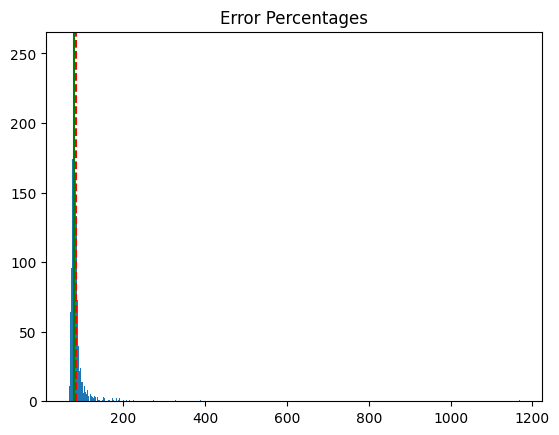

In [ ]:
for k_size, filter_num, dnn, history_dnn in zip(K_MainList, Filter_MainList, dnn_list, dnn_history_list):
    y_predict, err_perc = predictions(dnn)
    print(f'For the model with kernel = {str(k_size)} and filters = {str(filter_num)} the error is {str(np.mean(err_perc))}')
    model_plots(dnn, history_dnn)
    model_error_plots(history_dnn)
    model_error_hist_plots(y_predict)
